### DMLP-pitmodel

test the new feature 'cur_cautionlaps'

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.dmlp import DMLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid, include_end = False):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
        
    # calc cur_cautionlaps
    # accumulate consecutive caution laps
    trackstatus = rec[COL_TRACKSTATUS,:]
    lapstatus = rec[COL_LAPSTATUS,:]
    
    #import pdb; pdb.set_trace()
    
    cur_cautionlaps = np.zeros_like(trackstatus)
    cautionlaps_acc = 0
    for idx in range(len(trackstatus)):
        if (trackstatus[idx] == 0) or (lapstatus[idx] == 1):
            #reset
            cautionlaps_acc = 0
        else:
            cautionlaps_acc += 1
            
        #save state
        cur_cautionlaps[idx] = cautionlaps_acc
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    if include_end:
        #rec = rec[:, ~np.isnan(rec[run_ts,:])]
        totallen = len(rec[COL_RANK, ~np.isnan(rec[COL_RANK,:])])
    else:
        totallen = pitstops[-1]
        
    # set the last stint target = 999, an invalid lap2nextpit
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx] if idx < pitstops[-1] else 999
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                        ,cur_cautionlaps[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018', include_end = False):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid, include_end= include_end)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [4]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        if feature_cnt == 3:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break
        
    return db, scaler, df


def make_fulltestdb(scaler, maxgap=60, maxcautionlen=20, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            if feature_cnt == 2:        
                data.append([0.,caution_lap, pitage, 0])
            elif feature_cnt == 3:        
                for cur_cautionlap in range(0, caution_lap+1):
                    data.append([0.,caution_lap, pitage, cur_cautionlap])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        if feature_cnt == 3:        
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break

    #reset data, used by PitModel.save_model()
    if feature_cnt == 2:
        data = data[:,:3]            
            
    return db, scaler, df, data

In [5]:
def train_model(epochs, layers=[10,10,5,1], output = 'student', dropout = .5, id='all', feature_cnt = 2):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'dmlp-d%s-f%d-e%s-l%s-%s-d%s'%(id, feature_cnt,
                                            epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = DMLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        #distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=10,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae

def decode(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    sampleCnt = forecasts[0].samples.shape[0]
    samples = np.zeros((sampleCnt, len(tss)))
    
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        #pred
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        
            
        #samples
        for sid in range(sampleCnt):
            rec[0] = forecasts[idx].samples[sid]
            if isinstance(scaler, str):
                pred.append(int(rec[0]))    
                samples[sid, idx] = int(rec[0])
            else:
                samples[sid, idx] = int(scaler.inverse_transform(rec)[0])        
    
    return truth, pred, samples

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 


In [15]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                #onecast[i] = self.predict(feat[0], feat[1],feat[2])
                onecast[i] = self.predict(*feat)
        
            nf[idx].samples = onecast

        return nf
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    
def save_full_pitmodel(mid, scaler, maxgap=60, feature_cnt = 2):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    #scaler = _data[runid][-1]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap, feature_cnt = feature_cnt)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}-1k.pickle', test_all, forecasts, scaler)

    return pitmodel

### create dbs

In [7]:
def build_datasets(test_event, include_end, feature_cnt=2):
    
    _data = {}
    
    train, test =  make_dataset_byevent(test_event = test_event, include_end = include_end)
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
    df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    
    # select
    train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
    train_sel_2013_2017 = train_sel[train_sel['eid']<5]
    train_all_2013_2017 = df_train[df_train['eid']<5]

    print(len(train_all_2013_2017), len(train_sel_2013_2017))    

    test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
    test_all = df_test

    train_sel_noshort = df_train[(df_train['stint_len']>15)]
    train_sel_noshort_2013_2017 = train_sel_noshort[train_sel_noshort['eid']<5]
    test_sel_noshort = df_test[(df_test['stint_len']>15)]    
    
    
    # selected db
    trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_all[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['all'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_sel_noshort_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_noshort[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['noshort'] = [trainset, testset, train_ds, test_ds, scaler]    

    # add normal (normal pit only, with short pits)
    train_sel_normal = df_train[(df_train['pit_oncaution']==0)]
    train_sel_normal_2013_2017 = train_sel_normal[train_sel_normal['eid']<5]
    test_sel_normal = df_test[(df_test['pit_oncaution']==0)]

    trainset = train_sel_normal_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_normal[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['normal'] = [trainset, testset, train_ds, test_ds, scaler]
    
    # add caution pits
    train_sel_caution = df_train[(df_train['pit_oncaution']==1)]
    train_sel_caution_2013_2017 = train_sel_caution[train_sel_caution['eid']<5]
    test_sel_caution = df_test[(df_test['pit_oncaution']==1)]

    trainset = train_sel_caution_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_caution[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['caution'] = [trainset, testset, train_ds, test_ds, scaler]
    
    # add plen=2
    train_sel_plen2 = df_train[(df_train['lap2nextpit']==2)]
    train_sel_plen2_2013_2017 = train_sel_caution[train_sel_caution['eid']<5]
    test_sel_plen2 = df_test[(df_test['lap2nextpit']==2)]

    trainset = train_sel_plen2_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['plen2'] = [trainset, testset, train_ds, test_ds, scaler]
        
    
    return df_train, df_test, _data

In [8]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [9]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'


In [10]:
include_end = True
includeend_str = '-includeend' if include_end else ''

In [11]:
#model store
#dataset = {}
import pickle
datafile = f'pitstop_nextpit_dataset-{dbid}-alldata-{includeend_str}.pickle'
with open(datafile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    dataset = pickle.load(f, encoding='latin1') 

In [12]:
testevents = ['Indy500-2018','Indy500-2019']


### train the models

In [13]:
p, t, s, e = {}, {} ,{}, {}

In [16]:
#sync_test_ds = _data['all'][3]
cols = ['Year','Model','MAE','50-Risk','90-Risk']

### run train on all data
allruns = ['sel','all','noshort','normal','caution','plen2']
testevent='Indy500-2018'

retdata = []
for feature_cnt in [2,3]:
    for tid in allruns:
        #train
        key = f'{testevent}-{feature_cnt}'
        df_train, df_test, _data = dataset[key]
        
        trainset, testset, train_ds, test_ds, scaler = _data[tid]
        pm, mid = train_model(500,dropout = 0.1, id=tid, feature_cnt=feature_cnt)

        #test
        sync_testset = _data['normal'][1]
        sync_test_ds, _, _ = makedb(sync_testset, scaler, perm=False, feature_cnt=feature_cnt)
        t[mid],s[mid], e[mid] = eval_model(pm, sync_test_ds)
        p[mid] = pm

        mae = raw_eval(t[mid],s[mid])
        retdata.append([testevent,tid, mae, e[mid]["wQuantileLoss[0.5]"],e[mid]["wQuantileLoss[0.9]"]])

        #run_test(t[mid], s[mid], [31,816,846,856])
        pitmodel = save_full_pitmodel(mid, scaler, maxgap=65,feature_cnt=feature_cnt)
    
pitmodel_result = pd.DataFrame(data=retdata, columns=cols)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 287.12it/s, avg_epoch_loss=0.358]
INFO:root:Epoch[0] Elapsed time 0.350 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.357742
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 299.83it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[1] Elapsed time 0.335 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.137783
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 294.15it/s, avg_epoch_loss=0.0974]
INFO:root:Epoch[2] Elapsed time 0.341 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.097421
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 301.35it/s, avg_epoch_loss=0.0868]
INFO:root:Epoch[3] Elapsed time 0.333 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.086819
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 293.09

100%|██████████| 100/100 [00:00<00:00, 291.18it/s, avg_epoch_loss=0.0579]
INFO:root:Epoch[36] Elapsed time 0.345 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.057922
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 287.91it/s, avg_epoch_loss=0.0618]
INFO:root:Epoch[37] Elapsed time 0.349 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.061808
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 269.62it/s, avg_epoch_loss=0.058]
INFO:root:Epoch[38] Elapsed time 0.372 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.058025
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 305.62it/s, avg_epoch_loss=0.0587]
INFO:root:Epoch[39] Elapsed time 0.328 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.058672
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 298.96it/s, avg_epoch_loss=0.056]
INFO:root:Epoch[40] Elapsed time

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.053225
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 300.18it/s, avg_epoch_loss=0.0534]
INFO:root:Epoch[73] Elapsed time 0.335 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.053373
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 302.77it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[74] Elapsed time 0.332 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.053501
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 302.48it/s, avg_epoch_loss=0.0559]
INFO:root:Epoch[75] Elapsed time 0.332 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.055927
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 252.43it/s, avg_epoch_loss=0.0549]
INFO:root:Epoch[76] Elapsed time 0.398 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.054919
INFO:root:Epoch[77] Learning rate is 0.0

100%|██████████| 100/100 [00:00<00:00, 306.01it/s, avg_epoch_loss=0.055]
INFO:root:Epoch[108] Elapsed time 0.328 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.055016
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 303.51it/s, avg_epoch_loss=0.0524]
INFO:root:Epoch[109] Elapsed time 0.331 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.052377
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 301.90it/s, avg_epoch_loss=0.0564]
INFO:root:Epoch[110] Elapsed time 0.333 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.056410
INFO:root:Loading parameters from best epoch (70)
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 306.52it/s, avg_epoch_loss=0.0554]
INFO:root:Epoch[111] Elapsed time 0.328 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.055415
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00

100%|██████████| 100/100 [00:00<00:00, 296.73it/s, avg_epoch_loss=0.059]
INFO:root:Epoch[144] Elapsed time 0.338 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.059016
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.18it/s, avg_epoch_loss=0.0554]
INFO:root:Epoch[145] Elapsed time 0.333 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.055393
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.35it/s, avg_epoch_loss=0.0583]
INFO:root:Epoch[146] Elapsed time 0.338 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.058260
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.80it/s, avg_epoch_loss=0.0591]
INFO:root:Epoch[147] Elapsed time 0.320 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.059117
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.95it/s, avg_epoch_loss=0.055]
INFO:root:Epoch[148]

100%|██████████| 100/100 [00:00<00:00, 295.90it/s, avg_epoch_loss=0.0521]
INFO:root:Epoch[180] Elapsed time 0.339 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.052071
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.87it/s, avg_epoch_loss=0.0565]
INFO:root:Epoch[181] Elapsed time 0.340 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.056506
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.58it/s, avg_epoch_loss=0.0558]
INFO:root:Epoch[182] Elapsed time 0.337 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.055823
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.90it/s, avg_epoch_loss=0.0548]
INFO:root:Epoch[183] Elapsed time 0.337 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.054830
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.92it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[18

100%|██████████| 100/100 [00:00<00:00, 291.46it/s, avg_epoch_loss=0.0563]
INFO:root:Epoch[216] Elapsed time 0.344 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.056309
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.35it/s, avg_epoch_loss=0.0573]
INFO:root:Epoch[217] Elapsed time 0.346 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.057287
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.16it/s, avg_epoch_loss=0.0551]
INFO:root:Epoch[218] Elapsed time 0.343 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.055101
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 242.25it/s, avg_epoch_loss=0.0558]
INFO:root:Epoch[219] Elapsed time 0.414 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.055798
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.17it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 292.23it/s, avg_epoch_loss=0.0536]
INFO:root:Epoch[252] Elapsed time 0.343 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.053608
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.13it/s, avg_epoch_loss=0.0551]
INFO:root:Epoch[253] Elapsed time 0.346 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.055141
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.91it/s, avg_epoch_loss=0.0501]
INFO:root:Epoch[254] Elapsed time 0.346 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.050136
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.14it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[255] Elapsed time 0.350 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.054023
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.62it/s, avg_epoch_loss=0.0528]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 301.70it/s, avg_epoch_loss=0.0544]
INFO:root:Epoch[288] Elapsed time 0.333 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.054450
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.22it/s, avg_epoch_loss=0.0554]
INFO:root:Epoch[289] Elapsed time 0.326 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.055435
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.50it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[290] Elapsed time 0.335 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.053995
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.76it/s, avg_epoch_loss=0.0515]
INFO:root:Epoch[291] Elapsed time 0.331 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.051507
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.08it/s, avg_epoch_loss=0.0532]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 300.91it/s, avg_epoch_loss=0.0533]
INFO:root:Epoch[324] Elapsed time 0.334 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.053253
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.16it/s, avg_epoch_loss=0.0542]
INFO:root:Epoch[325] Elapsed time 0.347 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.054178
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.67it/s, avg_epoch_loss=0.0508]
INFO:root:Epoch[326] Elapsed time 0.350 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.050845
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.01it/s, avg_epoch_loss=0.0548]
INFO:root:Epoch[327] Elapsed time 0.336 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.054832
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 264.35it/s, avg_epoch_loss=0.0548]
INFO:root:Epoch[32

100%|██████████| 100/100 [00:00<00:00, 314.86it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[360] Elapsed time 0.319 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.053519
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 312.06it/s, avg_epoch_loss=0.051]
INFO:root:Epoch[361] Elapsed time 0.322 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.051049
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.85it/s, avg_epoch_loss=0.0536]
INFO:root:Epoch[362] Elapsed time 0.320 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.053646
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 309.89it/s, avg_epoch_loss=0.0528]
INFO:root:Epoch[363] Elapsed time 0.324 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.052763
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.68it/s, avg_epoch_loss=0.0532]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 288.31it/s, avg_epoch_loss=0.0543]
INFO:root:Epoch[396] Elapsed time 0.348 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.054290
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.55it/s, avg_epoch_loss=0.0529]
INFO:root:Epoch[397] Elapsed time 0.349 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.052875
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.94it/s, avg_epoch_loss=0.0548]
INFO:root:Epoch[398] Elapsed time 0.349 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.054846
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.12it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[399] Elapsed time 0.340 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.053985
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.57it/s, avg_epoch_loss=0.056]
INFO:root:Epoch[400]

100%|██████████| 100/100 [00:00<00:00, 211.21it/s, avg_epoch_loss=0.0531]
INFO:root:Epoch[432] Elapsed time 0.475 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.053098
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 237.70it/s, avg_epoch_loss=0.0503]
INFO:root:Epoch[433] Elapsed time 0.425 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.050338
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.32it/s, avg_epoch_loss=0.0533]
INFO:root:Epoch[434] Elapsed time 0.332 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.053269
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 306.86it/s, avg_epoch_loss=0.0546]
INFO:root:Epoch[435] Elapsed time 0.330 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.054593
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 318.68it/s, avg_epoch_loss=0.0557]
INFO:root:Epoch[43

100%|██████████| 100/100 [00:00<00:00, 302.95it/s, avg_epoch_loss=0.052]
INFO:root:Epoch[468] Elapsed time 0.332 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.052022
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 248.75it/s, avg_epoch_loss=0.053]
INFO:root:Epoch[469] Elapsed time 0.403 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.053015
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.23it/s, avg_epoch_loss=0.0537]
INFO:root:Epoch[470] Elapsed time 0.348 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.053670
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.07it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[471] Elapsed time 0.343 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.053524
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 248.51it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[472] 

{
    "MSE": 1745.4656022779593,
    "abs_error": 71975.11940561688,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9277884984552361,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14796.258974133732,
    "Coverage[0.1]": 0.14084507042253522,
    "QuantileLoss[0.5]": 71975.11940561688,
    "Coverage[0.5]": 0.14084507042253522,
    "QuantileLoss[0.9]": 129153.97983710004,
    "Coverage[0.9]": 0.14084507042253522,
    "RMSE": 41.778769755438695,
    "NRMSE": 2.4415667665611553,
    "ND": 0.9711966325541175,
    "wQuantileLoss[0.1]": 0.19965339423884157,
    "wQuantileLoss[0.5]": 0.9711966325541175,
    "wQuantileLoss[0.9]": 1.7427398708693937,
    "mean_wQuantileLoss": 0.9711966325541176,
    "MAE_Coverage": 0.3863849765258216
}
mae =  151.72338951743245
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 201.89it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


{
    "MSE": 1.4061803892562197,
    "abs_error": 2003.5462450096225,
    "abs_target_sum": 3779.5638833230714,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.761534356099315,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2999.631092929145,
    "Coverage[0.1]": 0.6736596736596736,
    "QuantileLoss[0.5]": 2003.5462450096225,
    "Coverage[0.5]": 0.6736596736596736,
    "QuantileLoss[0.9]": 1007.4613970901007,
    "Coverage[0.9]": 0.6736596736596736,
    "RMSE": 1.1858247717332522,
    "NRMSE": 0.6729861470502372,
    "ND": 0.5300998493106731,
    "wQuantileLoss[0.1]": 0.793644765779645,
    "wQuantileLoss[0.5]": 0.5300998493106731,
    "wQuantileLoss[0.9]": 0.26655493284170123,
    "mean_wQuantileLoss": 0.5300998493106731,
    "MAE_Coverage": 0.32455322455322455
}
save model pitmodel-m65-dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1-1k.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 284.53it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[0] Elapsed time 0.353 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.467024
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 300.92it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[1] Elapsed time 0.334 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.476740
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 308.36it/s, avg_epoch_loss=0.539]
INFO:root:Epoch[2] Elapsed time 0.326 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.539304
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 304.55it/s, avg_epoch_loss=0.488]
INFO:root:Epoch[3] Elapsed time 0.330 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.488181
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 304.62it/s, avg_epoch_loss=0.515]
INFO:root:Epoch[4] Elapsed time 0.330 seconds
I

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 303.79it/s, avg_epoch_loss=0.509]
INFO:root:Epoch[37] Elapsed time 0.331 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.508689
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 301.40it/s, avg_epoch_loss=0.503]
INFO:root:Epoch[38] Elapsed time 0.333 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.502557
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 303.71it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[39] Elapsed time 0.331 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.519838
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 308.97it/s, avg_epoch_loss=0.482]
INFO:root:Epoch[40] Elapsed time 0.325 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.482225
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 299.72it/s, avg_epoch_

100%|██████████| 100/100 [00:00<00:00, 306.43it/s, avg_epoch_loss=0.516]
INFO:root:Epoch[73] Elapsed time 0.328 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.516063
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 313.26it/s, avg_epoch_loss=0.488]
INFO:root:Epoch[74] Elapsed time 0.321 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.488274
INFO:root:Loading parameters from best epoch (44)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 308.26it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[75] Elapsed time 0.326 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.490034
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 306.57it/s, avg_epoch_loss=0.515]
INFO:root:Epoch[76] Elapsed time 0.328 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.514736
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 299.65it

100%|██████████| 100/100 [00:00<00:00, 289.91it/s, avg_epoch_loss=0.496]
INFO:root:Epoch[109] Elapsed time 0.346 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.496165
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.73it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[110] Elapsed time 0.347 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.499660
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.22it/s, avg_epoch_loss=0.504]
INFO:root:Epoch[111] Elapsed time 0.337 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.504414
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.17it/s, avg_epoch_loss=0.485]
INFO:root:Epoch[112] Elapsed time 0.339 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.485100
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.45it/s, avg_epoch_loss=0.495]
INFO:root:Epoch[113] Elap

100%|██████████| 100/100 [00:00<00:00, 311.42it/s, avg_epoch_loss=0.506]
INFO:root:Epoch[145] Elapsed time 0.325 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.505513
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.57it/s, avg_epoch_loss=0.497]
INFO:root:Epoch[146] Elapsed time 0.323 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.497004
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.55it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[147] Elapsed time 0.329 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.500455
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.68it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[148] Elapsed time 0.327 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.477975
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.68it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[149] Elap

100%|██████████| 100/100 [00:00<00:00, 305.01it/s, avg_epoch_loss=0.493]
INFO:root:Epoch[181] Elapsed time 0.329 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.492719
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.32it/s, avg_epoch_loss=0.515]
INFO:root:Epoch[182] Elapsed time 0.327 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.515362
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.35it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[183] Elapsed time 0.330 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.449725
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.85it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[184] Elapsed time 0.343 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.499966
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.81it/s, avg_epoch_loss=0.451]
INFO:root:Epoch[185] Elaps

100%|██████████| 100/100 [00:00<00:00, 279.38it/s, avg_epoch_loss=0.504]
INFO:root:Epoch[217] Elapsed time 0.360 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.504358
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.00it/s, avg_epoch_loss=0.476]
INFO:root:Epoch[218] Elapsed time 0.345 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.476042
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.66it/s, avg_epoch_loss=0.488]
INFO:root:Epoch[219] Elapsed time 0.345 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.488171
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.08it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[220] Elapsed time 0.347 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.449524
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.32it/s, avg_epoch_loss=0.469]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 304.13it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[253] Elapsed time 0.330 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.474163
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.62it/s, avg_epoch_loss=0.501]
INFO:root:Epoch[254] Elapsed time 0.331 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.501311
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.84it/s, avg_epoch_loss=0.441]
INFO:root:Epoch[255] Elapsed time 0.334 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.441202
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.11it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[256] Elapsed time 0.347 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.464349
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 261.51it/s, avg_epoch_loss=0.508]
INFO:root:Epoch[257] El

100%|██████████| 100/100 [00:00<00:00, 293.07it/s, avg_epoch_loss=0.489]
INFO:root:Epoch[289] Elapsed time 0.343 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.488575
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.46it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[290] Elapsed time 0.339 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.451765
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.15it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[291] Elapsed time 0.357 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.474875
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 251.41it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[292] Elapsed time 0.400 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.467622
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.65it/s, avg_epoch_loss=0.529]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 289.34it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[325] Elapsed time 0.347 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.489601
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.22it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[326] Elapsed time 0.348 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.447903
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.18it/s, avg_epoch_loss=0.479]
INFO:root:Epoch[327] Elapsed time 0.352 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.479021
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.95it/s, avg_epoch_loss=0.521]
INFO:root:Epoch[328] Elapsed time 0.349 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.520669
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.87it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 288.79it/s, avg_epoch_loss=0.453]
INFO:root:Epoch[361] Elapsed time 0.348 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.452515
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.60it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[362] Elapsed time 0.339 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.461257
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.26it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[363] Elapsed time 0.338 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.520414
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.92it/s, avg_epoch_loss=0.493]
INFO:root:Epoch[364] Elapsed time 0.331 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.492980
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.57it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[365] Elaps

100%|██████████| 100/100 [00:00<00:00, 301.60it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[397] Elapsed time 0.333 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.459721
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.20it/s, avg_epoch_loss=0.511]
INFO:root:Epoch[398] Elapsed time 0.326 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.510876
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 312.75it/s, avg_epoch_loss=0.504]
INFO:root:Epoch[399] Elapsed time 0.321 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.503564
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.37it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[400] Elapsed time 0.339 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.499835
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.39it/s, avg_epoch_loss=0.491]
INFO:root:Epoch[401] Elaps

100%|██████████| 100/100 [00:00<00:00, 284.71it/s, avg_epoch_loss=0.484]
INFO:root:Epoch[433] Elapsed time 0.353 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.484078
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.03it/s, avg_epoch_loss=0.515]
INFO:root:Epoch[434] Elapsed time 0.363 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.515411
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.35it/s, avg_epoch_loss=0.494]
INFO:root:Epoch[435] Elapsed time 0.368 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.494028
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.06it/s, avg_epoch_loss=0.494]
INFO:root:Epoch[436] Elapsed time 0.365 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.493517
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.59it/s, avg_epoch_loss=0.506]
INFO:root:Epoch[437] El

100%|██████████| 100/100 [00:00<00:00, 289.23it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[469] Elapsed time 0.347 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.520470
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.77it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[470] Elapsed time 0.372 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.482910
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.43it/s, avg_epoch_loss=0.503]
INFO:root:Epoch[471] Elapsed time 0.342 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.502840
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.31it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[472] Elapsed time 0.348 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.499903
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.24it/s, avg_epoch_loss=0.496]
INFO:root:Epoch[473] Elaps

{
    "MSE": 1.3848349697945281,
    "abs_error": 3277.0188554254573,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.555194018062466,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2959.108113127965,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3277.0188554254573,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 3594.9295977229494,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.1767901128895195,
    "NRMSE": 1.6526038513546033,
    "ND": 1.062577232431027,
    "wQuantileLoss[0.1]": 0.9594942989436926,
    "wQuantileLoss[0.5]": 1.062577232431027,
    "wQuantileLoss[0.9]": 1.1656601659183612,
    "mean_wQuantileLoss": 1.062577232431027,
    "MAE_Coverage": 0.383229431232202
}
mae =  236.55275917801893
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 201.44it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


{
    "MSE": 1.7856198961191405,
    "abs_error": 2316.834240972262,
    "abs_target_sum": 867.4244591064861,
    "abs_target_mean": 0.40439368722913105,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.67918409220926,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4170.30163375007,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 2316.834240972262,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 463.36684819445225,
    "Coverage[0.9]": 1.0,
    "RMSE": 1.3362708917428159,
    "NRMSE": 3.304381185816285,
    "ND": 2.6709348769791195,
    "wQuantileLoss[0.1]": 4.807682778562414,
    "wQuantileLoss[0.5]": 2.6709348769791195,
    "wQuantileLoss[0.9]": 0.5341869753958238,
    "mean_wQuantileLoss": 2.6709348769791195,
    "MAE_Coverage": 0.5
}
save model pitmodel-m65-dmlp-dall-f2-e500-l10-10-5-1-student-d0.1-1k.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 276.68it/s, avg_epoch_loss=0.462]
INFO:root:Epoch[0] Elapsed time 0.363 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.461883
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 288.00it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[1] Elapsed time 0.349 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.334251
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 287.14it/s, avg_epoch_loss=0.298]
INFO:root:Epoch[2] Elapsed time 0.350 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.298220
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 285.76it/s, avg_epoch_loss=0.274]
INFO:root:Epoch[3] Elapsed time 0.351 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.273588
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 295.45it/s, avg_epoch_loss=0.266]
INFO:root:Epoch[4] Elapsed time 0.340 seconds
I

100%|██████████| 100/100 [00:00<00:00, 305.47it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[37] Elapsed time 0.329 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.178959
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 305.91it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[38] Elapsed time 0.329 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.180035
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 310.76it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[39] Elapsed time 0.323 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.178409
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 316.00it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[40] Elapsed time 0.318 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.177716
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 320.41it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[41] Elapsed time 0.3

INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 293.58it/s, avg_epoch_loss=0.189]
INFO:root:Epoch[73] Elapsed time 0.342 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.188563
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 298.71it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[74] Elapsed time 0.336 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.183980
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 299.05it/s, avg_epoch_loss=0.183]
INFO:root:Epoch[75] Elapsed time 0.336 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.183361
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 298.82it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[76] Elapsed time 0.336 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.178388
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 296.53it/s,

100%|██████████| 100/100 [00:00<00:00, 289.57it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[109] Elapsed time 0.347 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.181605
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.72it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[110] Elapsed time 0.349 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.187660
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.78it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[111] Elapsed time 0.352 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.184771
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.90it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[112] Elapsed time 0.359 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.183663
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.83it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[113] El

100%|██████████| 100/100 [00:00<00:00, 295.29it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[145] Elapsed time 0.340 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.184096
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.21it/s, avg_epoch_loss=0.181]
INFO:root:Epoch[146] Elapsed time 0.333 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.180853
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.83it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[147] Elapsed time 0.364 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.185615
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.65it/s, avg_epoch_loss=0.183]
INFO:root:Epoch[148] Elapsed time 0.372 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.183176
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.71it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 305.69it/s, avg_epoch_loss=0.189]
INFO:root:Epoch[181] Elapsed time 0.328 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.189008
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.28it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[182] Elapsed time 0.335 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.185457
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.05it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[183] Elapsed time 0.347 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.179180
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.03it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[184] Elapsed time 0.332 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.187132
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.78it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 292.98it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[217] Elapsed time 0.343 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.178348
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.59it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[218] Elapsed time 0.348 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.184428
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.22it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[219] Elapsed time 0.338 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.179626
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.01it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[220] Elapsed time 0.333 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.179524
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.56it/s, avg_epoch_loss=0.183]
INFO:root:Epoch[221] Elap

100%|██████████| 100/100 [00:00<00:00, 301.67it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[253] Elapsed time 0.333 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.177157
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.97it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[254] Elapsed time 0.332 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.174321
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.39it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[255] Elapsed time 0.334 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.184598
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.80it/s, avg_epoch_loss=0.183]
INFO:root:Epoch[256] Elapsed time 0.335 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.183199
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.99it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 309.37it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[289] Elapsed time 0.324 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.178930
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.75it/s, avg_epoch_loss=0.175]
INFO:root:Epoch[290] Elapsed time 0.330 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.174608
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.65it/s, avg_epoch_loss=0.173]
INFO:root:Epoch[291] Elapsed time 0.331 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.173020
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.33it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[292] Elapsed time 0.329 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.187723
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.78it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:00<00:00, 277.79it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[325] Elapsed time 0.362 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.188041
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.76it/s, avg_epoch_loss=0.181]
INFO:root:Epoch[326] Elapsed time 0.326 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.180599
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.01it/s, avg_epoch_loss=0.176]
INFO:root:Epoch[327] Elapsed time 0.334 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.175590
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.05it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[328] Elapsed time 0.336 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.173617
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.90it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[329] El

100%|██████████| 100/100 [00:00<00:00, 264.48it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[361] Elapsed time 0.380 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.180439
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 256.75it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[362] Elapsed time 0.391 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.187352
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 262.42it/s, avg_epoch_loss=0.181]
INFO:root:Epoch[363] Elapsed time 0.383 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.181169
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 235.15it/s, avg_epoch_loss=0.175]
INFO:root:Epoch[364] Elapsed time 0.427 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.175168
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 231.76it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:00<00:00, 241.95it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[397] Elapsed time 0.415 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.179398
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.41it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[398] Elapsed time 0.337 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.180158
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.23it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[399] Elapsed time 0.338 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.187011
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.95it/s, avg_epoch_loss=0.181]
INFO:root:Epoch[400] Elapsed time 0.353 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.181335
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 263.56it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:00<00:00, 285.12it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[433] Elapsed time 0.352 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.184232
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.00it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[434] Elapsed time 0.357 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.182276
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.61it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[435] Elapsed time 0.370 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.180283
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.66it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[436] Elapsed time 0.342 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.182265
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.47it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 234.29it/s, avg_epoch_loss=0.176]
INFO:root:Epoch[469] Elapsed time 0.428 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.175676
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.15it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[470] Elapsed time 0.364 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.182261
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 266.59it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[471] Elapsed time 0.377 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.184581
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.19it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[472] Elapsed time 0.357 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.178445
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.21it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[473] El

{
    "MSE": 1879.3784463390612,
    "abs_error": 75358.93095911901,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1194396465015204,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15788.349684664143,
    "Coverage[0.1]": 0.20434079889171092,
    "QuantileLoss[0.5]": 75358.93095911901,
    "Coverage[0.5]": 0.20434079889171092,
    "QuantileLoss[0.9]": 134929.51223357389,
    "Coverage[0.9]": 0.20434079889171092,
    "RMSE": 43.351798651717566,
    "NRMSE": 2.440362049560548,
    "ND": 0.9794757471516844,
    "wQuantileLoss[0.1]": 0.20520866481064606,
    "wQuantileLoss[0.5]": 0.9794757471516844,
    "wQuantileLoss[0.9]": 1.7537428294927229,
    "mean_wQuantileLoss": 0.9794757471516844,
    "MAE_Coverage": 0.365219733702763
}
mae =  153.2523666589702
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 203.38it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


{
    "MSE": 3.346233445079351,
    "abs_error": 3438.4311138266276,
    "abs_target_sum": 3621.070977480014,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2998476393719822,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5661.606849038634,
    "Coverage[0.1]": 0.7948717948717948,
    "QuantileLoss[0.5]": 3438.4311138266276,
    "Coverage[0.5]": 0.7948717948717948,
    "QuantileLoss[0.9]": 1215.2553786146195,
    "Coverage[0.9]": 0.7948717948717948,
    "RMSE": 1.8292712879940336,
    "NRMSE": 1.0835984539242185,
    "ND": 0.949561921103107,
    "wQuantileLoss[0.1]": 1.5635172257735406,
    "wQuantileLoss[0.5]": 0.949561921103107,
    "wQuantileLoss[0.9]": 0.3356066164326731,
    "mean_wQuantileLoss": 0.9495619211031069,
    "MAE_Coverage": 0.364957264957265
}
save model pitmodel-m65-dmlp-dnoshort-f2-e500-l10-10-5-1-student-d0.1-1k.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 275.57it/s, avg_epoch_loss=0.528]
INFO:root:Epoch[0] Elapsed time 0.364 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.527835
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 272.53it/s, avg_epoch_loss=0.488]
INFO:root:Epoch[1] Elapsed time 0.368 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.487925
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 280.66it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[2] Elapsed time 0.358 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.466621
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 286.00it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[3] Elapsed time 0.351 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.467401
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 312.32it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[4] Elapsed time 0.322 seconds
I

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.458418
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 305.40it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[37] Elapsed time 0.329 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.458271
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 302.07it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[38] Elapsed time 0.333 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.445463
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 298.56it/s, avg_epoch_loss=0.473]
INFO:root:Epoch[39] Elapsed time 0.336 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.473219
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 314.17it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[40] Elapsed time 0.320 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.463434
INFO:root:Epoch[41] Learning rate is 0.0

100%|██████████| 100/100 [00:00<00:00, 275.69it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[72] Elapsed time 0.364 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.476793
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.28it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[73] Elapsed time 0.364 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.468332
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.45it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[74] Elapsed time 0.353 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.463662
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.80it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[75] Elapsed time 0.365 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.449571
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.22it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[76] Elapsed time 0.3

INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.18it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[109] Elapsed time 0.370 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.445869
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.07it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[110] Elapsed time 0.340 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.465043
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.12it/s, avg_epoch_loss=0.476]
INFO:root:Epoch[111] Elapsed time 0.358 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.476456
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.15it/s, avg_epoch_loss=0.447]
INFO:root:Epoch[112] Elapsed time 0.365 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.447358
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.56it/s, a

100%|██████████| 100/100 [00:00<00:00, 278.70it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[145] Elapsed time 0.361 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.444924
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.62it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[146] Elapsed time 0.365 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.461239
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.56it/s, avg_epoch_loss=0.454]
INFO:root:Epoch[147] Elapsed time 0.347 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.454309
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 316.41it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[148] Elapsed time 0.318 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.448080
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.69it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 293.57it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[181] Elapsed time 0.342 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.446076
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 247.96it/s, avg_epoch_loss=0.466]
INFO:root:Epoch[182] Elapsed time 0.405 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.465733
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.80it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[183] Elapsed time 0.354 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.474445
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 264.41it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[184] Elapsed time 0.380 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.444820
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.41it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 301.23it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[217] Elapsed time 0.334 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.452064
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.93it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[218] Elapsed time 0.331 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.454979
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.57it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[219] Elapsed time 0.335 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.449941
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.11it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[220] Elapsed time 0.353 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.457974
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.76it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 290.39it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[253] Elapsed time 0.346 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.452317
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.20it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[254] Elapsed time 0.346 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.475492
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.53it/s, avg_epoch_loss=0.457]
INFO:root:Epoch[255] Elapsed time 0.347 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.457414
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 227.76it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[256] Elapsed time 0.441 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.447799
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.62it/s, avg_epoch_loss=0.454]
INFO:root:Epoch[257] El

100%|██████████| 100/100 [00:00<00:00, 290.50it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[289] Elapsed time 0.346 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.452256
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.91it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[290] Elapsed time 0.345 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.461391
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 263.24it/s, avg_epoch_loss=0.436]
INFO:root:Epoch[291] Elapsed time 0.381 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.436128
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.36it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[292] Elapsed time 0.364 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.474392
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.14it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 268.08it/s, avg_epoch_loss=0.471]
INFO:root:Epoch[325] Elapsed time 0.375 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.470998
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.38it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[326] Elapsed time 0.365 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.464387
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.09it/s, avg_epoch_loss=0.453]
INFO:root:Epoch[327] Elapsed time 0.373 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.453060
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.67it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[328] Elapsed time 0.366 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.460696
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.45it/s, avg_epoch_loss=0.439]
INFO:root:Epoch[329] El

100%|██████████| 100/100 [00:00<00:00, 278.00it/s, avg_epoch_loss=0.453]
INFO:root:Epoch[361] Elapsed time 0.361 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.453172
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.89it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[362] Elapsed time 0.351 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.448621
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.48it/s, avg_epoch_loss=0.444]
INFO:root:Epoch[363] Elapsed time 0.346 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.443630
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.06it/s, avg_epoch_loss=0.466]
INFO:root:Epoch[364] Elapsed time 0.339 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.466250
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.13it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 302.50it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[397] Elapsed time 0.332 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.473525
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.95it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[398] Elapsed time 0.338 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.460255
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.69it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[399] Elapsed time 0.370 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.455795
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 236.14it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[400] Elapsed time 0.425 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.448277
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.83it/s, avg_epoch_loss=0.431]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:00<00:00, 286.44it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[433] Elapsed time 0.351 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.449702
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.04it/s, avg_epoch_loss=0.438]
INFO:root:Epoch[434] Elapsed time 0.354 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.437769
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.31it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[435] Elapsed time 0.376 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.467406
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.90it/s, avg_epoch_loss=0.471]
INFO:root:Epoch[436] Elapsed time 0.352 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.471062
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.41it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 289.83it/s, avg_epoch_loss=0.471]
INFO:root:Epoch[469] Elapsed time 0.346 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.471091
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.38it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[470] Elapsed time 0.338 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.445041
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.79it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[471] Elapsed time 0.334 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.458093
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.93it/s, avg_epoch_loss=0.453]
INFO:root:Epoch[472] Elapsed time 0.336 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.452904
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.99it/s, avg_epoch_loss=0.447]
INFO:root:Epoch[473] El

{
    "MSE": 1.0811042944197087,
    "abs_error": 3468.616642724385,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4556540117660988,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4048.4335990015184,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3468.616642724385,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 2888.799686447252,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.0397616526972462,
    "NRMSE": 1.4578795217297376,
    "ND": 1.122938467203023,
    "wQuantileLoss[0.1]": 1.3106498320509896,
    "wQuantileLoss[0.5]": 1.122938467203023,
    "wQuantileLoss[0.9]": 0.9352271023550564,
    "mean_wQuantileLoss": 1.122938467203023,
    "MAE_Coverage": 0.383229431232202
}
mae =  303.60655737704917
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 204.50it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


{
    "MSE": 2.761033732999211,
    "abs_error": 2926.7052729567677,
    "abs_target_sum": 1101.954234419911,
    "abs_target_mean": 0.5137315778181404,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6560566413692308,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5262.659320464231,
    "Coverage[0.1]": 0.972027972027972,
    "QuantileLoss[0.5]": 2926.7052729567677,
    "Coverage[0.5]": 0.972027972027972,
    "QuantileLoss[0.9]": 590.7512254493031,
    "Coverage[0.9]": 0.972027972027972,
    "RMSE": 1.6616358605299812,
    "NRMSE": 3.234443690588543,
    "ND": 2.655922706715165,
    "wQuantileLoss[0.1]": 4.775751257251252,
    "wQuantileLoss[0.5]": 2.655922706715165,
    "wQuantileLoss[0.9]": 0.5360941561790771,
    "mean_wQuantileLoss": 2.6559227067151645,
    "MAE_Coverage": 0.47202797202797203
}
save model pitmodel-m65-dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1-1k.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 281.99it/s, avg_epoch_loss=0.434]
INFO:root:Epoch[0] Elapsed time 0.356 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.434150
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 275.49it/s, avg_epoch_loss=0.374]
INFO:root:Epoch[1] Elapsed time 0.365 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.373784
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 245.51it/s, avg_epoch_loss=0.364]
INFO:root:Epoch[2] Elapsed time 0.409 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.363912
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 295.18it/s, avg_epoch_loss=0.364]
INFO:root:Epoch[3] Elapsed time 0.340 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.364253
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 317.83it/s, avg_epoch_loss=0.35]
INFO:root:Epoch[4] Elapsed time 0.316 seconds
IN

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 276.20it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[37] Elapsed time 0.363 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.321787
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 286.72it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[38] Elapsed time 0.350 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.328347
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 305.32it/s, avg_epoch_loss=0.35]
INFO:root:Epoch[39] Elapsed time 0.329 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.350301
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 266.93it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[40] Elapsed time 0.378 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.329407
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 284.35it/s, avg_epoch_

INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 319.56it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[73] Elapsed time 0.315 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.328309
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 313.31it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[74] Elapsed time 0.321 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.333079
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 325.17it/s, avg_epoch_loss=0.354]
INFO:root:Epoch[75] Elapsed time 0.309 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.353881
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 323.10it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[76] Elapsed time 0.312 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.327549
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 319.70it/s,

100%|██████████| 100/100 [00:00<00:00, 238.39it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[109] Elapsed time 0.421 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.329894
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.44it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[110] Elapsed time 0.354 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.326755
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.90it/s, avg_epoch_loss=0.348]
INFO:root:Epoch[111] Elapsed time 0.334 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.347538
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.26it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[112] Elapsed time 0.332 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.330543
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.61it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[113] Ela

100%|██████████| 100/100 [00:00<00:00, 275.45it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[145] Elapsed time 0.364 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.337548
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 239.65it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[146] Elapsed time 0.419 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.328281
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.21it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[147] Elapsed time 0.352 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.326780
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.29it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[148] Elapsed time 0.350 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.346624
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.65it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 289.39it/s, avg_epoch_loss=0.348]
INFO:root:Epoch[181] Elapsed time 0.347 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.348095
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.79it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[182] Elapsed time 0.335 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.326885
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.12it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[183] Elapsed time 0.340 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.331033
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.05it/s, avg_epoch_loss=0.354]
INFO:root:Epoch[184] Elapsed time 0.340 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.353608
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 241.13it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:00<00:00, 304.48it/s, avg_epoch_loss=0.351]
INFO:root:Epoch[217] Elapsed time 0.330 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.351030
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.56it/s, avg_epoch_loss=0.324]
INFO:root:Epoch[218] Elapsed time 0.333 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.323578
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.74it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[219] Elapsed time 0.330 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.325936
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.38it/s, avg_epoch_loss=0.346]
INFO:root:Epoch[220] Elapsed time 0.331 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.345750
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.69it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[221] El

100%|██████████| 100/100 [00:00<00:00, 299.88it/s, avg_epoch_loss=0.345]
INFO:root:Epoch[253] Elapsed time 0.335 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.345291
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.44it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[254] Elapsed time 0.340 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.335039
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.47it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[255] Elapsed time 0.340 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.329956
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.41it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[256] Elapsed time 0.342 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.339263
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.78it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 304.39it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[289] Elapsed time 0.330 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.334519
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.47it/s, avg_epoch_loss=0.348]
INFO:root:Epoch[290] Elapsed time 0.332 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.347968
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.45it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[291] Elapsed time 0.338 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.323419
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 306.96it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[292] Elapsed time 0.327 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.330514
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.69it/s, avg_epoch_loss=0.35]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:00<00:00, 276.80it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[325] Elapsed time 0.362 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.339501
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.87it/s, avg_epoch_loss=0.346]
INFO:root:Epoch[326] Elapsed time 0.365 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.346331
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.27it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[327] Elapsed time 0.331 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.325121
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.56it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[328] Elapsed time 0.332 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.329342
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.69it/s, avg_epoch_loss=0.342]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 291.60it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[361] Elapsed time 0.344 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.327319
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.30it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[362] Elapsed time 0.338 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.341218
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.23it/s, avg_epoch_loss=0.336]
INFO:root:Epoch[363] Elapsed time 0.340 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.335980
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.70it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[364] Elapsed time 0.341 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.326114
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.75it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 300.11it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[397] Elapsed time 0.335 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.320206
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.51it/s, avg_epoch_loss=0.337]
INFO:root:Epoch[398] Elapsed time 0.337 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.336592
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.80it/s, avg_epoch_loss=0.344]
INFO:root:Epoch[399] Elapsed time 0.342 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.343789
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.83it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[400] Elapsed time 0.335 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.329517
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 233.58it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[401] Elap

100%|██████████| 100/100 [00:00<00:00, 295.86it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[433] Elapsed time 0.339 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.324674
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.68it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[434] Elapsed time 0.333 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.329231
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.61it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[435] Elapsed time 0.337 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.346707
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.56it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[436] Elapsed time 0.342 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.327495
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.33it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[437] El

100%|██████████| 100/100 [00:00<00:00, 309.24it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[469] Elapsed time 0.325 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.323392
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.07it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[470] Elapsed time 0.329 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.328546
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 306.01it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[471] Elapsed time 0.328 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.338389
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.59it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[472] Elapsed time 0.323 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.325800
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.73it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[473] El

{
    "MSE": 2258.5561621768334,
    "abs_error": 83963.24338133173,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.402519613825953,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17096.18427172535,
    "Coverage[0.1]": 0.11567767259293465,
    "QuantileLoss[0.5]": 83963.24338133173,
    "Coverage[0.5]": 0.11567767259293465,
    "QuantileLoss[0.9]": 150830.3024909381,
    "Coverage[0.9]": 0.11567767259293465,
    "RMSE": 47.52426919140191,
    "NRMSE": 2.437795244466882,
    "ND": 0.9944496540397634,
    "wQuantileLoss[0.1]": 0.20248496663240334,
    "wQuantileLoss[0.5]": 0.9944496540397634,
    "wQuantileLoss[0.9]": 1.7864143414471232,
    "mean_wQuantileLoss": 0.9944496540397633,
    "MAE_Coverage": 0.39477410913568844
}
mae =  156.6019395058878
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 204.46it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


{
    "MSE": 1.398948866493787,
    "abs_error": 2002.0837146774134,
    "abs_target_sum": 3282.838098998321,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9522545762065103,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3442.8279515200684,
    "Coverage[0.1]": 0.7785547785547785,
    "QuantileLoss[0.5]": 2002.0837146774134,
    "Coverage[0.5]": 0.7785547785547785,
    "QuantileLoss[0.9]": 561.3394778347588,
    "Coverage[0.9]": 0.7785547785547785,
    "RMSE": 1.1827716882364858,
    "NRMSE": 0.7728207102389181,
    "ND": 0.6098636771908736,
    "wQuantileLoss[0.1]": 1.048735224734526,
    "wQuantileLoss[0.5]": 0.6098636771908736,
    "wQuantileLoss[0.9]": 0.1709921296472214,
    "mean_wQuantileLoss": 0.6098636771908738,
    "MAE_Coverage": 0.3595182595182595
}
save model pitmodel-m65-dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1-1k.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 288.33it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[0] Elapsed time 0.349 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.452336
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 280.56it/s, avg_epoch_loss=0.396]
INFO:root:Epoch[1] Elapsed time 0.358 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.395632
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 281.98it/s, avg_epoch_loss=0.372]
INFO:root:Epoch[2] Elapsed time 0.356 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.372240
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 245.74it/s, avg_epoch_loss=0.362]
INFO:root:Epoch[3] Elapsed time 0.409 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.362408
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 303.89it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[4] Elapsed time 0.331 seconds
I

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.345147
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 305.74it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[37] Elapsed time 0.328 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.341064
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 301.03it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[38] Elapsed time 0.333 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.347298
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 310.32it/s, avg_epoch_loss=0.353]
INFO:root:Epoch[39] Elapsed time 0.324 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.352590
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 311.40it/s, avg_epoch_loss=0.345]
INFO:root:Epoch[40] Elapsed time 0.323 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.344535
INFO:root:Loading parameters from best e

100%|██████████| 100/100 [00:00<00:00, 294.23it/s, avg_epoch_loss=0.349]
INFO:root:Epoch[72] Elapsed time 0.341 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.349282
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.53it/s, avg_epoch_loss=0.346]
INFO:root:Epoch[73] Elapsed time 0.333 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.346325
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.00it/s, avg_epoch_loss=0.345]
INFO:root:Epoch[74] Elapsed time 0.329 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.344646
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.04it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[75] Elapsed time 0.336 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.356844
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.37it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[76] Elapsed time 0.

INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.32it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[109] Elapsed time 0.343 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.335241
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.92it/s, avg_epoch_loss=0.346]
INFO:root:Epoch[110] Elapsed time 0.345 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.346283
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.48it/s, avg_epoch_loss=0.352]
INFO:root:Epoch[111] Elapsed time 0.335 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.352351
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.53it/s, avg_epoch_loss=0.343]
INFO:root:Epoch[112] Elapsed time 0.333 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.342773
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.49it/s, a

100%|██████████| 100/100 [00:00<00:00, 301.29it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[145] Elapsed time 0.333 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.339627
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.45it/s, avg_epoch_loss=0.332]
INFO:root:Epoch[146] Elapsed time 0.329 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.331656
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.42it/s, avg_epoch_loss=0.348]
INFO:root:Epoch[147] Elapsed time 0.347 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.348282
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.08it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[148] Elapsed time 0.339 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.340155
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.50it/s, avg_epoch_loss=0.337]
INFO:root:Epoch[149] Elap

100%|██████████| 100/100 [00:00<00:00, 294.06it/s, avg_epoch_loss=0.344]
INFO:root:Epoch[181] Elapsed time 0.342 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.343565
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.91it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[182] Elapsed time 0.343 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.334518
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.97it/s, avg_epoch_loss=0.346]
INFO:root:Epoch[183] Elapsed time 0.338 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.346429
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.69it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[184] Elapsed time 0.333 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.347126
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.38it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 310.27it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[217] Elapsed time 0.324 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.347130
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.58it/s, avg_epoch_loss=0.336]
INFO:root:Epoch[218] Elapsed time 0.329 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.336351
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.46it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[219] Elapsed time 0.334 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.334617
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.26it/s, avg_epoch_loss=0.345]
INFO:root:Epoch[220] Elapsed time 0.337 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.345047
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.22it/s, avg_epoch_loss=0.344]
INFO:root:Epoch[221] El

100%|██████████| 100/100 [00:00<00:00, 295.63it/s, avg_epoch_loss=0.349]
INFO:root:Epoch[253] Elapsed time 0.340 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.349325
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.84it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[254] Elapsed time 0.365 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.340244
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.23it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[255] Elapsed time 0.373 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.338384
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 278.03it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[256] Elapsed time 0.361 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.340727
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.23it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[257] Elap

100%|██████████| 100/100 [00:00<00:00, 289.51it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[289] Elapsed time 0.347 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.339502
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.20it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[290] Elapsed time 0.329 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.334736
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.35it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[291] Elapsed time 0.337 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.340177
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.98it/s, avg_epoch_loss=0.336]
INFO:root:Epoch[292] Elapsed time 0.336 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.336396
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.72it/s, avg_epoch_loss=0.343]
INFO:root:Epoch[293] Elap

100%|██████████| 100/100 [00:00<00:00, 290.20it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[325] Elapsed time 0.346 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.340629
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 261.36it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[326] Elapsed time 0.384 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.337508
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.20it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[327] Elapsed time 0.363 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.333449
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.88it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[328] Elapsed time 0.340 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.328631
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.71it/s, avg_epoch_loss=0.347]
INFO:root:Epoch[329] El

100%|██████████| 100/100 [00:00<00:00, 240.10it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[361] Elapsed time 0.419 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.326716
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.81it/s, avg_epoch_loss=0.348]
INFO:root:Epoch[362] Elapsed time 0.344 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.347738
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 221.26it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[363] Elapsed time 0.454 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.334437
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 263.15it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[364] Elapsed time 0.382 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.338783
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 250.53it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 280.31it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[397] Elapsed time 0.358 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.338765
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.02it/s, avg_epoch_loss=0.342]
INFO:root:Epoch[398] Elapsed time 0.347 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.342292
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.41it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[399] Elapsed time 0.336 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.341012
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.15it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[400] Elapsed time 0.337 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.329234
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 241.62it/s, avg_epoch_loss=0.332]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 303.57it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[433] Elapsed time 0.331 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.328659
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.02it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[434] Elapsed time 0.331 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.334415
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.40it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[435] Elapsed time 0.333 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.340073
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.47it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[436] Elapsed time 0.337 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.330665
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.16it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 306.44it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[469] Elapsed time 0.329 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.331462
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.67it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[470] Elapsed time 0.326 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.329330
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.59it/s, avg_epoch_loss=0.346]
INFO:root:Epoch[471] Elapsed time 0.343 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.345687
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.84it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[472] Elapsed time 0.347 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.330867
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.67it/s, avg_epoch_loss=0.337]
INFO:root:Epoch[473] El

{
    "MSE": 2258.3386749029314,
    "abs_error": 83933.91366161537,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.394856298460795,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17133.149699129932,
    "Coverage[0.1]": 0.12814592472870007,
    "QuantileLoss[0.5]": 83933.91366161537,
    "Coverage[0.5]": 0.12814592472870007,
    "QuantileLoss[0.9]": 150734.67762410082,
    "Coverage[0.9]": 0.12814592472870007,
    "RMSE": 47.52198096568504,
    "NRMSE": 2.4376778681060083,
    "ND": 0.9941022766821194,
    "wQuantileLoss[0.1]": 0.202922780311503,
    "wQuantileLoss[0.5]": 0.9941022766821194,
    "wQuantileLoss[0.9]": 1.785281773052736,
    "mean_wQuantileLoss": 0.9941022766821194,
    "MAE_Coverage": 0.39061802509043336
}
mae =  156.51096744400832
make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:10<00:00, 202.52it/s]
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 211


{
    "MSE": 1.9190967097488971,
    "abs_error": 2378.3202573309472,
    "abs_target_sum": 3282.838098998321,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0296980116318168,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4003.0749449942264,
    "Coverage[0.1]": 0.7561771561771562,
    "QuantileLoss[0.5]": 2378.3202573309472,
    "Coverage[0.5]": 0.7561771561771562,
    "QuantileLoss[0.9]": 753.5655696676675,
    "Coverage[0.9]": 0.7561771561771562,
    "RMSE": 1.3853146609160307,
    "NRMSE": 0.905161892866897,
    "ND": 0.7244707736444981,
    "wQuantileLoss[0.1]": 1.2193945678331406,
    "wQuantileLoss[0.5]": 0.7244707736444981,
    "wQuantileLoss[0.9]": 0.22954697945585556,
    "mean_wQuantileLoss": 0.7244707736444981,
    "MAE_Coverage": 0.3520590520590521
}
save model pitmodel-m65-dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1-1k.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 276.46it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[0] Elapsed time 0.364 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.454681
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 291.22it/s, avg_epoch_loss=0.263]
INFO:root:Epoch[1] Elapsed time 0.345 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.262716
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 281.43it/s, avg_epoch_loss=0.152]
INFO:root:Epoch[2] Elapsed time 0.357 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.151618
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 285.01it/s, avg_epoch_loss=0.118]
INFO:root:Epoch[3] Elapsed time 0.352 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.118372
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 286.32it/s, avg_epoch_loss=0.106]
INFO:root:Epoch[4] Elapsed time 0.351 seconds
I

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 295.50it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[37] Elapsed time 0.340 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.053998
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 293.36it/s, avg_epoch_loss=0.0529]
INFO:root:Epoch[38] Elapsed time 0.342 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.052909
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 288.83it/s, avg_epoch_loss=0.0546]
INFO:root:Epoch[39] Elapsed time 0.348 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.054572
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 306.12it/s, avg_epoch_loss=0.056]
INFO:root:Epoch[40] Elapsed time 0.328 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.056022
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 300.87it/s, avg_epoch_lo

100%|██████████| 100/100 [00:00<00:00, 297.39it/s, avg_epoch_loss=0.0492]
INFO:root:Epoch[73] Elapsed time 0.338 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.049218
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 286.89it/s, avg_epoch_loss=0.0507]
INFO:root:Epoch[74] Elapsed time 0.350 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.050718
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 303.88it/s, avg_epoch_loss=0.0504]
INFO:root:Epoch[75] Elapsed time 0.331 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.050401
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 297.06it/s, avg_epoch_loss=0.053]
INFO:root:Epoch[76] Elapsed time 0.338 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.052990
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 299.61it/s, avg_epoch_loss=0.0485]
INFO:root:Epoch[77] Ela

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.051343
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.05it/s, avg_epoch_loss=0.051]
INFO:root:Epoch[109] Elapsed time 0.324 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.050965
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.85it/s, avg_epoch_loss=0.0524]
INFO:root:Epoch[110] Elapsed time 0.335 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.052427
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.95it/s, avg_epoch_loss=0.0542]
INFO:root:Epoch[111] Elapsed time 0.338 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.054222
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.11it/s, avg_epoch_loss=0.0511]
INFO:root:Epoch[112] Elapsed time 0.347 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.051067
INFO:root:Epoch[113] Learning ra

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.19it/s, avg_epoch_loss=0.0519]
INFO:root:Epoch[145] Elapsed time 0.327 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.051914
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.41it/s, avg_epoch_loss=0.0534]
INFO:root:Epoch[146] Elapsed time 0.329 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.053422
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.18it/s, avg_epoch_loss=0.0494]
INFO:root:Epoch[147] Elapsed time 0.327 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.049360
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.25it/s, avg_epoch_loss=0.053]
INFO:root:Epoch[148] Elapsed time 0.321 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.052998
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 311.39it/s

100%|██████████| 100/100 [00:00<00:00, 285.75it/s, avg_epoch_loss=0.0549]
INFO:root:Epoch[181] Elapsed time 0.351 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.054905
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.14it/s, avg_epoch_loss=0.0533]
INFO:root:Epoch[182] Elapsed time 0.355 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.053289
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.02it/s, avg_epoch_loss=0.0481]
INFO:root:Epoch[183] Elapsed time 0.351 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.048073
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 278.64it/s, avg_epoch_loss=0.0522]
INFO:root:Epoch[184] Elapsed time 0.360 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.052175
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.09it/s, avg_epoch_loss=0.0507]
INFO:root:Epoch[18

100%|██████████| 100/100 [00:00<00:00, 287.56it/s, avg_epoch_loss=0.05]
INFO:root:Epoch[217] Elapsed time 0.349 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.050019
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.78it/s, avg_epoch_loss=0.0524]
INFO:root:Epoch[218] Elapsed time 0.338 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.052384
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 232.72it/s, avg_epoch_loss=0.0506]
INFO:root:Epoch[219] Elapsed time 0.431 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.050635
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 270.08it/s, avg_epoch_loss=0.0504]
INFO:root:Epoch[220] Elapsed time 0.372 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.050383
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.61it/s, avg_epoch_loss=0.0494]
INFO:root:Epoch[221]

100%|██████████| 100/100 [00:00<00:00, 307.20it/s, avg_epoch_loss=0.0499]
INFO:root:Epoch[253] Elapsed time 0.328 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.049889
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.61it/s, avg_epoch_loss=0.0525]
INFO:root:Epoch[254] Elapsed time 0.330 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.052535
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 309.22it/s, avg_epoch_loss=0.0515]
INFO:root:Epoch[255] Elapsed time 0.325 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.051504
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.95it/s, avg_epoch_loss=0.052]
INFO:root:Epoch[256] Elapsed time 0.329 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.052027
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.85it/s, avg_epoch_loss=0.0511]
INFO:root:Epoch[257

100%|██████████| 100/100 [00:00<00:00, 295.36it/s, avg_epoch_loss=0.056]
INFO:root:Epoch[289] Elapsed time 0.340 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.055986
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.06it/s, avg_epoch_loss=0.0537]
INFO:root:Epoch[290] Elapsed time 0.349 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.053702
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.95it/s, avg_epoch_loss=0.0484]
INFO:root:Epoch[291] Elapsed time 0.334 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.048441
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.73it/s, avg_epoch_loss=0.048]
INFO:root:Epoch[292] Elapsed time 0.341 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.048000
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.70it/s, avg_epoch_loss=0.052]
INFO:root:Epoch[293] 

100%|██████████| 100/100 [00:00<00:00, 291.48it/s, avg_epoch_loss=0.0514]
INFO:root:Epoch[325] Elapsed time 0.345 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.051378
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.02it/s, avg_epoch_loss=0.0492]
INFO:root:Epoch[326] Elapsed time 0.349 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.049219
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.42it/s, avg_epoch_loss=0.0495]
INFO:root:Epoch[327] Elapsed time 0.334 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.049506
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.65it/s, avg_epoch_loss=0.0483]
INFO:root:Epoch[328] Elapsed time 0.337 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.048295
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.11it/s, avg_epoch_loss=0.0496]
INFO:root:Epoch[32

100%|██████████| 100/100 [00:00<00:00, 271.95it/s, avg_epoch_loss=0.0472]
INFO:root:Epoch[361] Elapsed time 0.369 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.047219
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.88it/s, avg_epoch_loss=0.0489]
INFO:root:Epoch[362] Elapsed time 0.375 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.048926
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.39it/s, avg_epoch_loss=0.0501]
INFO:root:Epoch[363] Elapsed time 0.362 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.050114
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.87it/s, avg_epoch_loss=0.0504]
INFO:root:Epoch[364] Elapsed time 0.334 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.050432
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.51it/s, avg_epoch_loss=0.0515]
INFO:root:Epoch[36

100%|██████████| 100/100 [00:00<00:00, 255.28it/s, avg_epoch_loss=0.0476]
INFO:root:Epoch[397] Elapsed time 0.393 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.047570
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 262.65it/s, avg_epoch_loss=0.049]
INFO:root:Epoch[398] Elapsed time 0.382 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.048993
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 262.88it/s, avg_epoch_loss=0.0506]
INFO:root:Epoch[399] Elapsed time 0.382 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.050590
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 261.43it/s, avg_epoch_loss=0.0506]
INFO:root:Epoch[400] Elapsed time 0.384 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.050605
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 265.23it/s, avg_epoch_loss=0.0479]
INFO:root:Epoch[401

100%|██████████| 100/100 [00:00<00:00, 268.25it/s, avg_epoch_loss=0.0515]
INFO:root:Epoch[433] Elapsed time 0.374 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.051545
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.96it/s, avg_epoch_loss=0.0501]
INFO:root:Epoch[434] Elapsed time 0.362 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.050099
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 237.93it/s, avg_epoch_loss=0.0485]
INFO:root:Epoch[435] Elapsed time 0.422 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.048501
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.79it/s, avg_epoch_loss=0.0475]
INFO:root:Epoch[436] Elapsed time 0.338 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.047527
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.81it/s, avg_epoch_loss=0.0508]
INFO:root:Epoch[43

100%|██████████| 100/100 [00:00<00:00, 315.00it/s, avg_epoch_loss=0.0513]
INFO:root:Epoch[469] Elapsed time 0.319 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.051344
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 322.50it/s, avg_epoch_loss=0.047]
INFO:root:Epoch[470] Elapsed time 0.312 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.047001
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 317.21it/s, avg_epoch_loss=0.0466]
INFO:root:Epoch[471] Elapsed time 0.317 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.046613
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 311.51it/s, avg_epoch_loss=0.0492]
INFO:root:Epoch[472] Elapsed time 0.323 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.049227
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.67it/s, avg_epoch_loss=0.0498]
INFO:root:Epoch[473

{
    "MSE": 1744.03105155162,
    "abs_error": 71841.90989123285,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.882484187716019,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14816.869026127695,
    "Coverage[0.1]": 0.154698683906719,
    "QuantileLoss[0.5]": 71841.90989123285,
    "Coverage[0.5]": 0.154698683906719,
    "QuantileLoss[0.9]": 128866.95075633802,
    "Coverage[0.9]": 0.154698683906719,
    "RMSE": 41.76159780889161,
    "NRMSE": 2.4405632316497172,
    "ND": 0.969399169307619,
    "wQuantileLoss[0.1]": 0.19993149607817995,
    "wQuantileLoss[0.5]": 0.969399169307619,
    "wQuantileLoss[0.9]": 1.7388668425370584,
    "mean_wQuantileLoss": 0.969399169307619,
    "MAE_Coverage": 0.381767105364427
}
mae =  151.3592703763565
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:55<00:00, 203.64it/s]


{
    "MSE": 2.508138510372055,
    "abs_error": 66528.77379423332,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1154667991862723,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 99220.79711423893,
    "Coverage[0.1]": 0.7414048637929235,
    "QuantileLoss[0.5]": 66528.77379423332,
    "Coverage[0.5]": 0.7414048637929235,
    "QuantileLoss[0.9]": 33836.750474227694,
    "Coverage[0.9]": 0.7414048637929235,
    "RMSE": 1.5837103618945148,
    "NRMSE": 0.8987964831743944,
    "ND": 0.7881598012640718,
    "wQuantileLoss[0.1]": 1.17545896722359,
    "wQuantileLoss[0.5]": 0.7881598012640718,
    "wQuantileLoss[0.9]": 0.4008606353045533,
    "mean_wQuantileLoss": 0.7881598012640717,
    "MAE_Coverage": 0.34713495459764115
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 211


save model pitmodel-m65-dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1-1k.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 280.15it/s, avg_epoch_loss=0.584]
INFO:root:Epoch[0] Elapsed time 0.359 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.583843
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 291.54it/s, avg_epoch_loss=0.506]
INFO:root:Epoch[1] Elapsed time 0.345 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.505772
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 293.42it/s, avg_epoch_loss=0.548]
INFO:root:Epoch[2] Elapsed time 0.343 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.548257
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 305.21it/s, avg_epoch_loss=0.508]
INFO:root:Epoch[3] Elapsed time 0.329 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.507762
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 310.34it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[4] Elapsed time 0.324 seconds
IN

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 285.67it/s, avg_epoch_loss=0.537]
INFO:root:Epoch[37] Elapsed time 0.352 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.536740
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 292.12it/s, avg_epoch_loss=0.517]
INFO:root:Epoch[38] Elapsed time 0.344 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.517029
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 284.11it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[39] Elapsed time 0.354 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.463534
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 295.56it/s, avg_epoch_loss=0.508]
INFO:root:Epoch[40] Elapsed time 0.340 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.508342
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 298.85it/s, avg_epoch

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.522475
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 297.88it/s, avg_epoch_loss=0.511]
INFO:root:Epoch[73] Elapsed time 0.337 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.510692
INFO:root:Loading parameters from best epoch (33)
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 316.11it/s, avg_epoch_loss=0.489]
INFO:root:Epoch[74] Elapsed time 0.318 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.488946
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.91it/s, avg_epoch_loss=0.497]
INFO:root:Epoch[75] Elapsed time 0.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.497295
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.83it/s, avg_epoch_loss=0.497]
INFO:root:Epoch[76] Elapsed time 0.334 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.49

100%|██████████| 100/100 [00:00<00:00, 308.60it/s, avg_epoch_loss=0.481]
INFO:root:Epoch[109] Elapsed time 0.326 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.481368
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.60it/s, avg_epoch_loss=0.487]
INFO:root:Epoch[110] Elapsed time 0.330 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.487427
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.77it/s, avg_epoch_loss=0.517]
INFO:root:Epoch[111] Elapsed time 0.333 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.517092
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.81it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[112] Elapsed time 0.342 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.450192
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.83it/s, avg_epoch_loss=0.476]
INFO:root:Epoch[113] Ela

100%|██████████| 100/100 [00:00<00:00, 230.44it/s, avg_epoch_loss=0.473]
INFO:root:Epoch[145] Elapsed time 0.438 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.473050
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 243.63it/s, avg_epoch_loss=0.503]
INFO:root:Epoch[146] Elapsed time 0.412 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.503078
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.11it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[147] Elapsed time 0.364 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.474770
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 264.21it/s, avg_epoch_loss=0.462]
INFO:root:Epoch[148] Elapsed time 0.380 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.462264
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.12it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 294.17it/s, avg_epoch_loss=0.494]
INFO:root:Epoch[181] Elapsed time 0.341 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.494186
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.83it/s, avg_epoch_loss=0.487]
INFO:root:Epoch[182] Elapsed time 0.337 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.487317
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.40it/s, avg_epoch_loss=0.447]
INFO:root:Epoch[183] Elapsed time 0.339 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.447323
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.30it/s, avg_epoch_loss=0.491]
INFO:root:Epoch[184] Elapsed time 0.342 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.491089
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.70it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:00<00:00, 297.20it/s, avg_epoch_loss=0.495]
INFO:root:Epoch[217] Elapsed time 0.338 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.495238
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.48it/s, avg_epoch_loss=0.424]
INFO:root:Epoch[218] Elapsed time 0.345 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.424394
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.78it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[219] Elapsed time 0.350 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.480187
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.80it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[220] Elapsed time 0.342 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.480407
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.44it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[221] Elap

100%|██████████| 100/100 [00:00<00:00, 310.45it/s, avg_epoch_loss=0.431]
INFO:root:Epoch[253] Elapsed time 0.324 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.430566
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 313.30it/s, avg_epoch_loss=0.473]
INFO:root:Epoch[254] Elapsed time 0.321 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.473425
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.49it/s, avg_epoch_loss=0.485]
INFO:root:Epoch[255] Elapsed time 0.324 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.485004
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.87it/s, avg_epoch_loss=0.473]
INFO:root:Epoch[256] Elapsed time 0.329 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.473474
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.65it/s, avg_epoch_loss=0.515]
INFO:root:Epoch[257] El

100%|██████████| 100/100 [00:00<00:00, 323.06it/s, avg_epoch_loss=0.459]
INFO:root:Epoch[289] Elapsed time 0.312 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.459163
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 322.62it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[290] Elapsed time 0.312 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.480123
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 323.02it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[291] Elapsed time 0.311 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.459784
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.40it/s, avg_epoch_loss=0.514]
INFO:root:Epoch[292] Elapsed time 0.368 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.514322
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 250.48it/s, avg_epoch_loss=0.512]
INFO:root:Epoch[293] Elap

100%|██████████| 100/100 [00:00<00:00, 283.04it/s, avg_epoch_loss=0.481]
INFO:root:Epoch[325] Elapsed time 0.356 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.481429
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 314.39it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[326] Elapsed time 0.320 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.480426
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 312.24it/s, avg_epoch_loss=0.485]
INFO:root:Epoch[327] Elapsed time 0.322 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.485089
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 309.55it/s, avg_epoch_loss=0.519]
INFO:root:Epoch[328] Elapsed time 0.325 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.518612
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.66it/s, avg_epoch_loss=0.499]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 280.22it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[361] Elapsed time 0.358 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.475234
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.20it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[362] Elapsed time 0.357 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.483179
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.88it/s, avg_epoch_loss=0.53]
INFO:root:Epoch[363] Elapsed time 0.343 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.529581
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 263.81it/s, avg_epoch_loss=0.51]
INFO:root:Epoch[364] Elapsed time 0.381 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.509569
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.42it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[365] Elap

100%|██████████| 100/100 [00:00<00:00, 290.69it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[397] Elapsed time 0.345 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.471878
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.49it/s, avg_epoch_loss=0.511]
INFO:root:Epoch[398] Elapsed time 0.343 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.511368
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.59it/s, avg_epoch_loss=0.526]
INFO:root:Epoch[399] Elapsed time 0.362 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.526054
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 234.20it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[400] Elapsed time 0.428 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.464671
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.04it/s, avg_epoch_loss=0.501]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 300.48it/s, avg_epoch_loss=0.519]
INFO:root:Epoch[433] Elapsed time 0.335 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.519489
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.14it/s, avg_epoch_loss=0.499]
INFO:root:Epoch[434] Elapsed time 0.341 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.499457
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.50it/s, avg_epoch_loss=0.488]
INFO:root:Epoch[435] Elapsed time 0.346 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.487893
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.12it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[436] Elapsed time 0.327 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.489688
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.58it/s, avg_epoch_loss=0.51]
INFO:root:Epoch[437] Elap

100%|██████████| 100/100 [00:00<00:00, 309.05it/s, avg_epoch_loss=0.517]
INFO:root:Epoch[469] Elapsed time 0.326 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.517431
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.26it/s, avg_epoch_loss=0.5]
INFO:root:Epoch[470] Elapsed time 0.338 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.500225
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.68it/s, avg_epoch_loss=0.469]
INFO:root:Epoch[471] Elapsed time 0.350 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.468764
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.88it/s, avg_epoch_loss=0.512]
INFO:root:Epoch[472] Elapsed time 0.349 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.512298
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.89it/s, avg_epoch_loss=0.469]
INFO:root:Epoch[473] Elap

{
    "MSE": 1.3084630379087114,
    "abs_error": 3174.6523698595565,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.572080199216603,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2820.0276831448264,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3174.6523698595565,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 3529.2770565742867,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.1438806921653637,
    "NRMSE": 1.6063881032454967,
    "ND": 1.0293847786414427,
    "wQuantileLoss[0.1]": 0.9143973053355756,
    "wQuantileLoss[0.5]": 1.0293847786414427,
    "wQuantileLoss[0.9]": 1.1443722519473098,
    "mean_wQuantileLoss": 1.0293847786414427,
    "MAE_Coverage": 0.383229431232202
}
mae =  229.18517663357193
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:55<00:00, 203.68it/s]


{
    "MSE": 0.5128045956849094,
    "abs_error": 31660.55523203324,
    "abs_target_sum": 19372.479586711524,
    "abs_target_mean": 0.4043936872291311,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.704959489393949,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 56104.55205277691,
    "Coverage[0.1]": 0.9260828723515291,
    "QuantileLoss[0.5]": 31660.55523203324,
    "Coverage[0.5]": 0.9260828723515291,
    "QuantileLoss[0.9]": 7216.558411289557,
    "Coverage[0.9]": 0.9260828723515291,
    "RMSE": 0.7161037604180762,
    "NRMSE": 1.7708084548123249,
    "ND": 1.634305773317251,
    "wQuantileLoss[0.1]": 2.896095556671104,
    "wQuantileLoss[0.5]": 1.634305773317251,
    "wQuantileLoss[0.9]": 0.3725159899633977,
    "mean_wQuantileLoss": 1.6343057733172508,
    "MAE_Coverage": 0.42608287235152903
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 211


save model pitmodel-m65-dmlp-dall-f3-e500-l10-10-5-1-student-d0.1-1k.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 254.34it/s, avg_epoch_loss=0.486]
INFO:root:Epoch[0] Elapsed time 0.396 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.486475
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 270.15it/s, avg_epoch_loss=0.354]
INFO:root:Epoch[1] Elapsed time 0.372 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.354164
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 274.98it/s, avg_epoch_loss=0.314]
INFO:root:Epoch[2] Elapsed time 0.366 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.313988
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 228.53it/s, avg_epoch_loss=0.3]
INFO:root:Epoch[3] Elapsed time 0.439 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.299778
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 263.52it/s, avg_epoch_loss=0.285]
INFO:root:Epoch[4] Elapsed time 0.382 seconds
INF

100%|██████████| 100/100 [00:00<00:00, 293.70it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[37] Elapsed time 0.342 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.187614
INFO:root:Loading parameters from best epoch (27)
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 233.27it/s, avg_epoch_loss=0.199]
INFO:root:Epoch[38] Elapsed time 0.430 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.199197
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 273.25it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[39] Elapsed time 0.368 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.184107
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 273.50it/s, avg_epoch_loss=0.194]
INFO:root:Epoch[40] Elapsed time 0.367 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.194460
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 274.40it/s, avg

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.199304
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 281.89it/s, avg_epoch_loss=0.195]
INFO:root:Epoch[73] Elapsed time 0.356 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.194642
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 287.30it/s, avg_epoch_loss=0.19]
INFO:root:Epoch[74] Elapsed time 0.350 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.190332
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 283.42it/s, avg_epoch_loss=0.191]
INFO:root:Epoch[75] Elapsed time 0.354 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.191097
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 239.80it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[76] Elapsed time 0.419 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.193228
INFO:root:Epoch[77] Learning rate is 

100%|██████████| 100/100 [00:00<00:00, 268.90it/s, avg_epoch_loss=0.191]
INFO:root:Epoch[109] Elapsed time 0.374 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.190657
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 265.50it/s, avg_epoch_loss=0.199]
INFO:root:Epoch[110] Elapsed time 0.378 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.199270
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 250.72it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[111] Elapsed time 0.400 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.193040
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 241.78it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[112] Elapsed time 0.415 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.192875
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.06it/s, avg_epoch_loss=0.194]
INFO:root:Epoch[113] El

100%|██████████| 100/100 [00:00<00:00, 287.70it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[145] Elapsed time 0.349 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.188478
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.75it/s, avg_epoch_loss=0.202]
INFO:root:Epoch[146] Elapsed time 0.353 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.202146
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.51it/s, avg_epoch_loss=0.192]
INFO:root:Epoch[147] Elapsed time 0.370 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.192160
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.58it/s, avg_epoch_loss=0.195]
INFO:root:Epoch[148] Elapsed time 0.346 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.194514
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 234.37it/s, avg_epoch_loss=0.199]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 286.01it/s, avg_epoch_loss=0.189]
INFO:root:Epoch[181] Elapsed time 0.351 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.189395
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 223.85it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[182] Elapsed time 0.448 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.182441
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.22it/s, avg_epoch_loss=0.191]
INFO:root:Epoch[183] Elapsed time 0.373 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.190523
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 265.21it/s, avg_epoch_loss=0.196]
INFO:root:Epoch[184] Elapsed time 0.378 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.196412
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 272.60it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 232.79it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[217] Elapsed time 0.431 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.185046
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 222.81it/s, avg_epoch_loss=0.189]
INFO:root:Epoch[218] Elapsed time 0.452 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.188766
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.94it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[219] Elapsed time 0.354 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.187696
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.42it/s, avg_epoch_loss=0.192]
INFO:root:Epoch[220] Elapsed time 0.341 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.191535
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.69it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[221] El

100%|██████████| 100/100 [00:00<00:00, 287.61it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[253] Elapsed time 0.349 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.187579
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.83it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[254] Elapsed time 0.354 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.182327
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.55it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[255] Elapsed time 0.358 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.186455
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.84it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[256] Elapsed time 0.375 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.186698
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.23it/s, avg_epoch_loss=0.19]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 264.75it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[289] Elapsed time 0.379 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.193493
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 262.34it/s, avg_epoch_loss=0.192]
INFO:root:Epoch[290] Elapsed time 0.383 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.191524
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 257.21it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[291] Elapsed time 0.390 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.188085
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 262.37it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[292] Elapsed time 0.383 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.186482
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.73it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 244.56it/s, avg_epoch_loss=0.191]
INFO:root:Epoch[325] Elapsed time 0.410 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.191303
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.12it/s, avg_epoch_loss=0.189]
INFO:root:Epoch[326] Elapsed time 0.365 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.189355
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.61it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[327] Elapsed time 0.357 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.186612
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.82it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[328] Elapsed time 0.365 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.186103
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.07it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[329] El

100%|██████████| 100/100 [00:00<00:00, 295.36it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[361] Elapsed time 0.340 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.186052
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.37it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[362] Elapsed time 0.344 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.185537
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.29it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[363] Elapsed time 0.343 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.184826
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.32it/s, avg_epoch_loss=0.187]
INFO:root:Epoch[364] Elapsed time 0.331 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.187282
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.06it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 287.07it/s, avg_epoch_loss=0.193]
INFO:root:Epoch[397] Elapsed time 0.350 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.193249
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.86it/s, avg_epoch_loss=0.19]
INFO:root:Epoch[398] Elapsed time 0.365 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.189577
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 268.41it/s, avg_epoch_loss=0.185]
INFO:root:Epoch[399] Elapsed time 0.374 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.184692
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 272.86it/s, avg_epoch_loss=0.189]
INFO:root:Epoch[400] Elapsed time 0.368 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.189043
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.27it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:00<00:00, 281.69it/s, avg_epoch_loss=0.188]
INFO:root:Epoch[433] Elapsed time 0.357 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.187858
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 266.26it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[434] Elapsed time 0.377 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.185872
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.55it/s, avg_epoch_loss=0.19]
INFO:root:Epoch[435] Elapsed time 0.366 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.189590
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 214.13it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[436] Elapsed time 0.468 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.185836
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 262.18it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 273.24it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[469] Elapsed time 0.367 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.185560
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.35it/s, avg_epoch_loss=0.184]
INFO:root:Epoch[470] Elapsed time 0.357 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.184017
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.29it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[471] Elapsed time 0.326 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.182178
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.09it/s, avg_epoch_loss=0.19]
INFO:root:Epoch[472] Elapsed time 0.362 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.189668
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.98it/s, avg_epoch_loss=0.186]
INFO:root:Epoch[473] Ela

{
    "MSE": 1887.1136815684267,
    "abs_error": 76062.18333839765,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2631199463077694,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15709.256226707354,
    "Coverage[0.1]": 0.16693604248441468,
    "QuantileLoss[0.5]": 76062.18333839765,
    "Coverage[0.5]": 0.16693604248441468,
    "QuantileLoss[0.9]": 136415.110450088,
    "Coverage[0.9]": 0.16693604248441468,
    "RMSE": 43.44092173939713,
    "NRMSE": 2.445378971757022,
    "ND": 0.9886162516793271,
    "wQuantileLoss[0.1]": 0.20418064964587332,
    "wQuantileLoss[0.5]": 0.9886162516793271,
    "wQuantileLoss[0.9]": 1.7730518537127815,
    "mean_wQuantileLoss": 0.9886162516793272,
    "MAE_Coverage": 0.3776879858385285
}
mae =  154.73701223735858
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:55<00:00, 203.29it/s]


{
    "MSE": 1.6069155384661722,
    "abs_error": 56687.32189971989,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1109797098451462,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 102037.17941949578,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 56687.32189971989,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 11337.464379943973,
    "Coverage[0.9]": 1.0,
    "RMSE": 1.2676417232271002,
    "NRMSE": 0.7509080913444033,
    "ND": 0.7009634193317378,
    "wQuantileLoss[0.1]": 1.2617341547971275,
    "wQuantileLoss[0.5]": 0.7009634193317378,
    "wQuantileLoss[0.9]": 0.14019268386634748,
    "mean_wQuantileLoss": 0.7009634193317376,
    "MAE_Coverage": 0.5
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 211


save model pitmodel-m65-dmlp-dnoshort-f3-e500-l10-10-5-1-student-d0.1-1k.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 253.47it/s, avg_epoch_loss=0.545]
INFO:root:Epoch[0] Elapsed time 0.396 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.545129
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 270.84it/s, avg_epoch_loss=0.491]
INFO:root:Epoch[1] Elapsed time 0.371 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.491287
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 286.03it/s, avg_epoch_loss=0.485]
INFO:root:Epoch[2] Elapsed time 0.351 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.484818
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 271.13it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[3] Elapsed time 0.370 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.471616
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 274.95it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[4] Elapsed time 0.365 seconds
I

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.445783
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 238.55it/s, avg_epoch_loss=0.471]
INFO:root:Epoch[37] Elapsed time 0.421 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.470898
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 296.93it/s, avg_epoch_loss=0.479]
INFO:root:Epoch[38] Elapsed time 0.338 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.478620
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 239.09it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[39] Elapsed time 0.420 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.447823
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 277.68it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[40] Elapsed time 0.362 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.451907
INFO:root:Epoch[41] Learning rate is 0.0

100%|██████████| 100/100 [00:00<00:00, 276.57it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[72] Elapsed time 0.363 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.446390
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 236.65it/s, avg_epoch_loss=0.459]
INFO:root:Epoch[73] Elapsed time 0.424 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.458702
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.47it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[74] Elapsed time 0.347 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.462523
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.56it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[75] Elapsed time 0.340 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.457652
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.44it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[76] Elapsed time 0.

INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.86it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[109] Elapsed time 0.375 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.473940
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 243.95it/s, avg_epoch_loss=0.459]
INFO:root:Epoch[110] Elapsed time 0.411 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.459381
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 232.42it/s, avg_epoch_loss=0.448]
INFO:root:Epoch[111] Elapsed time 0.432 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.447679
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.21it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[112] Elapsed time 0.366 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.475304
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.18it/s, a

100%|██████████| 100/100 [00:00<00:00, 302.08it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[145] Elapsed time 0.332 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.468189
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.09it/s, avg_epoch_loss=0.443]
INFO:root:Epoch[146] Elapsed time 0.351 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.442975
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.92it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[147] Elapsed time 0.340 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.463909
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.08it/s, avg_epoch_loss=0.493]
INFO:root:Epoch[148] Elapsed time 0.354 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.492844
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.41it/s, avg_epoch_loss=0.435]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 232.41it/s, avg_epoch_loss=0.482]
INFO:root:Epoch[181] Elapsed time 0.432 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.482001
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.90it/s, avg_epoch_loss=0.435]
INFO:root:Epoch[182] Elapsed time 0.372 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.434968
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 258.84it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[183] Elapsed time 0.388 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.450311
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 270.89it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[184] Elapsed time 0.371 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.464276
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 268.37it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[185] Ela

100%|██████████| 100/100 [00:00<00:00, 235.47it/s, avg_epoch_loss=0.466]
INFO:root:Epoch[217] Elapsed time 0.426 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.465875
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.25it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[218] Elapsed time 0.368 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.451522
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 245.24it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[219] Elapsed time 0.409 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.467646
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.02it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[220] Elapsed time 0.358 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.459976
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 268.30it/s, avg_epoch_loss=0.442]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 292.89it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[253] Elapsed time 0.343 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.459887
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.25it/s, avg_epoch_loss=0.439]
INFO:root:Epoch[254] Elapsed time 0.364 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.438766
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 282.39it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[255] Elapsed time 0.356 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.464568
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.58it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[256] Elapsed time 0.362 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.448888
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.52it/s, avg_epoch_loss=0.459]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 286.67it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[289] Elapsed time 0.350 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.451630
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 282.02it/s, avg_epoch_loss=0.459]
INFO:root:Epoch[290] Elapsed time 0.356 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.458649
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.88it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[291] Elapsed time 0.364 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.475414
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.75it/s, avg_epoch_loss=0.431]
INFO:root:Epoch[292] Elapsed time 0.363 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.431489
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.70it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 281.94it/s, avg_epoch_loss=0.435]
INFO:root:Epoch[325] Elapsed time 0.356 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.435094
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.43it/s, avg_epoch_loss=0.451]
INFO:root:Epoch[326] Elapsed time 0.367 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.451409
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.49it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[327] Elapsed time 0.353 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.452036
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 243.31it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[328] Elapsed time 0.413 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.449119
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 261.00it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 279.83it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[361] Elapsed time 0.359 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.445194
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.66it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[362] Elapsed time 0.330 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.460964
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.57it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[363] Elapsed time 0.349 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.467051
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.19it/s, avg_epoch_loss=0.444]
INFO:root:Epoch[364] Elapsed time 0.334 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.444181
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.87it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 295.81it/s, avg_epoch_loss=0.442]
INFO:root:Epoch[397] Elapsed time 0.340 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.442021
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 238.28it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[398] Elapsed time 0.421 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.446079
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 282.01it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[399] Elapsed time 0.356 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.458211
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.56it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[400] Elapsed time 0.366 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.455144
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.40it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 290.17it/s, avg_epoch_loss=0.449]
INFO:root:Epoch[433] Elapsed time 0.346 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.449343
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.00it/s, avg_epoch_loss=0.473]
INFO:root:Epoch[434] Elapsed time 0.324 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.472583
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.22it/s, avg_epoch_loss=0.45]
INFO:root:Epoch[435] Elapsed time 0.347 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.449985
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.14it/s, avg_epoch_loss=0.445]
INFO:root:Epoch[436] Elapsed time 0.338 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.444954
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.43it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 230.24it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[469] Elapsed time 0.436 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.446311
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.43it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[470] Elapsed time 0.358 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.463217
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.51it/s, avg_epoch_loss=0.435]
INFO:root:Epoch[471] Elapsed time 0.347 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.435273
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.99it/s, avg_epoch_loss=0.457]
INFO:root:Epoch[472] Elapsed time 0.363 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.457328
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.68it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[473] El

{
    "MSE": 0.9396309569835983,
    "abs_error": 3277.7011465482765,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.496648444000829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3769.4102090798083,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3277.7011465482765,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 2785.9920840167442,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 0.9693456333958483,
    "NRMSE": 1.3591472091127752,
    "ND": 1.0611310157825866,
    "wQuantileLoss[0.1]": 1.2203181148087008,
    "wQuantileLoss[0.5]": 1.0611310157825866,
    "wQuantileLoss[0.9]": 0.9019439167564726,
    "mean_wQuantileLoss": 1.0611310157825866,
    "MAE_Coverage": 0.383229431232202
}
mae =  286.79427383975985
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:56<00:00, 202.75it/s]


{
    "MSE": 0.8383651582610234,
    "abs_error": 43438.90278740098,
    "abs_target_sum": 24610.311235378,
    "abs_target_mean": 0.51373157781814,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.9587095823178071,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 78154.24694845438,
    "Coverage[0.1]": 0.9945934662352572,
    "QuantileLoss[0.5]": 43438.90278740098,
    "Coverage[0.5]": 0.9945934662352572,
    "QuantileLoss[0.9]": 8723.55862634763,
    "Coverage[0.9]": 0.9945934662352572,
    "RMSE": 0.9156228253276693,
    "NRMSE": 1.7822981199956487,
    "ND": 1.765069217205037,
    "wQuantileLoss[0.1]": 3.1756708072876987,
    "wQuantileLoss[0.5]": 1.765069217205037,
    "wQuantileLoss[0.9]": 0.35446762712237767,
    "mean_wQuantileLoss": 1.7650692172050377,
    "MAE_Coverage": 0.4945934662352573
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 211


save model pitmodel-m65-dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1-1k.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 265.95it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[0] Elapsed time 0.378 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.519527
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 288.00it/s, avg_epoch_loss=0.416]
INFO:root:Epoch[1] Elapsed time 0.349 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.416421
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 269.52it/s, avg_epoch_loss=0.383]
INFO:root:Epoch[2] Elapsed time 0.372 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.383154
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 275.10it/s, avg_epoch_loss=0.371]
INFO:root:Epoch[3] Elapsed time 0.365 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.370726
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 283.76it/s, avg_epoch_loss=0.358]
INFO:root:Epoch[4] Elapsed time 0.354 seconds
IN

100%|██████████| 100/100 [00:00<00:00, 283.43it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[37] Elapsed time 0.354 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.327071
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 275.85it/s, avg_epoch_loss=0.332]
INFO:root:Epoch[38] Elapsed time 0.364 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.332053
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 276.34it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[39] Elapsed time 0.363 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.325912
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 277.06it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[40] Elapsed time 0.362 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.322545
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 272.14it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[41] Elapsed time 0.

100%|██████████| 100/100 [00:00<00:00, 282.42it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[73] Elapsed time 0.356 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.321874
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 275.71it/s, avg_epoch_loss=0.342]
INFO:root:Epoch[74] Elapsed time 0.364 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.341620
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 286.01it/s, avg_epoch_loss=0.319]
INFO:root:Epoch[75] Elapsed time 0.351 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.318714
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 276.09it/s, avg_epoch_loss=0.324]
INFO:root:Epoch[76] Elapsed time 0.364 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.323581
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 275.78it/s, avg_epoch_loss=0.319]
INFO:root:Epoch[77] Ela

100%|██████████| 100/100 [00:00<00:00, 299.54it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[109] Elapsed time 0.336 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.324588
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.14it/s, avg_epoch_loss=0.321]
INFO:root:Epoch[110] Elapsed time 0.335 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.321272
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.91it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[111] Elapsed time 0.364 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.325796
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 306.11it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[112] Elapsed time 0.328 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.324754
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.68it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[113] El

100%|██████████| 100/100 [00:00<00:00, 297.21it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[145] Elapsed time 0.338 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.319918
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.31it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[146] Elapsed time 0.335 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.327493
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.24it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[147] Elapsed time 0.337 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.319504
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.70it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[148] Elapsed time 0.344 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.326463
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.57it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[149] Elaps

100%|██████████| 100/100 [00:00<00:00, 292.24it/s, avg_epoch_loss=0.318]
INFO:root:Epoch[181] Elapsed time 0.344 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.318083
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.25it/s, avg_epoch_loss=0.316]
INFO:root:Epoch[182] Elapsed time 0.340 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.316337
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.68it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[183] Elapsed time 0.349 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.331093
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.89it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[184] Elapsed time 0.345 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.325808
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.99it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 222.89it/s, avg_epoch_loss=0.318]
INFO:root:Epoch[217] Elapsed time 0.450 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.318277
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.92it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[218] Elapsed time 0.340 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.322049
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.72it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[219] Elapsed time 0.331 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.319661
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.73it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[220] Elapsed time 0.323 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.325554
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.98it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 299.19it/s, avg_epoch_loss=0.321]
INFO:root:Epoch[253] Elapsed time 0.336 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.321434
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.99it/s, avg_epoch_loss=0.321]
INFO:root:Epoch[254] Elapsed time 0.356 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.321168
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.30it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[255] Elapsed time 0.376 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.329732
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 236.44it/s, avg_epoch_loss=0.321]
INFO:root:Epoch[256] Elapsed time 0.424 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.320885
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 278.33it/s, avg_epoch_loss=0.315]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 285.61it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[289] Elapsed time 0.352 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.322009
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.90it/s, avg_epoch_loss=0.324]
INFO:root:Epoch[290] Elapsed time 0.366 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.323740
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.63it/s, avg_epoch_loss=0.319]
INFO:root:Epoch[291] Elapsed time 0.373 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.318861
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 217.92it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[292] Elapsed time 0.460 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.337585
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.45it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 279.54it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[325] Elapsed time 0.359 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.330927
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.84it/s, avg_epoch_loss=0.317]
INFO:root:Epoch[326] Elapsed time 0.369 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.317174
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 271.62it/s, avg_epoch_loss=0.318]
INFO:root:Epoch[327] Elapsed time 0.370 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.318252
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 235.62it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[328] Elapsed time 0.426 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.329628
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 266.04it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 267.50it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[361] Elapsed time 0.375 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.326564
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 249.19it/s, avg_epoch_loss=0.321]
INFO:root:Epoch[362] Elapsed time 0.403 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.321492
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 256.32it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[363] Elapsed time 0.392 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.325659
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 260.08it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[364] Elapsed time 0.386 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.333746
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 259.00it/s, avg_epoch_loss=0.317]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 294.24it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[397] Elapsed time 0.341 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.329863
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.03it/s, avg_epoch_loss=0.313]
INFO:root:Epoch[398] Elapsed time 0.350 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.312984
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.26it/s, avg_epoch_loss=0.313]
INFO:root:Epoch[399] Elapsed time 0.345 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.312914
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.09it/s, avg_epoch_loss=0.313]
INFO:root:Epoch[400] Elapsed time 0.343 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.313278
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.38it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:00<00:00, 276.02it/s, avg_epoch_loss=0.316]
INFO:root:Epoch[433] Elapsed time 0.364 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.316417
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.93it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[434] Elapsed time 0.329 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.327836
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.64it/s, avg_epoch_loss=0.315]
INFO:root:Epoch[435] Elapsed time 0.335 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.314986
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.11it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[436] Elapsed time 0.341 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.326555
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.34it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[437] El

100%|██████████| 100/100 [00:00<00:00, 287.01it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[469] Elapsed time 0.350 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.325278
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.84it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[470] Elapsed time 0.328 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.326277
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.29it/s, avg_epoch_loss=0.317]
INFO:root:Epoch[471] Elapsed time 0.348 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.317132
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 309.25it/s, avg_epoch_loss=0.324]
INFO:root:Epoch[472] Elapsed time 0.325 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.324407
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.39it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[473] El

{
    "MSE": 2259.588245961349,
    "abs_error": 83982.0308076565,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4348655418447074,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17367.810804431036,
    "Coverage[0.1]": 0.17201570076194875,
    "QuantileLoss[0.5]": 83982.0308076565,
    "Coverage[0.5]": 0.17201570076194875,
    "QuantileLoss[0.9]": 150596.25081088196,
    "Coverage[0.9]": 0.17201570076194875,
    "RMSE": 47.53512644309836,
    "NRMSE": 2.438352175841186,
    "ND": 0.9946721698556914,
    "wQuantileLoss[0.1]": 0.20570207569821689,
    "wQuantileLoss[0.5]": 0.9946721698556914,
    "wQuantileLoss[0.9]": 1.783642264013166,
    "mean_wQuantileLoss": 0.9946721698556914,
    "MAE_Coverage": 0.37599476641268376
}
mae =  156.52759178018934
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:57<00:00, 201.52it/s]


{
    "MSE": 7.238343683379747,
    "abs_error": 106290.12489010583,
    "abs_target_sum": 73316.71754429584,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.440312237747452,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 190687.24383411376,
    "Coverage[0.1]": 0.9352677173572695,
    "QuantileLoss[0.5]": 106290.12489010583,
    "Coverage[0.5]": 0.9352677173572695,
    "QuantileLoss[0.9]": 21893.005946097917,
    "Coverage[0.9]": 0.9352677173572695,
    "RMSE": 2.690417009197598,
    "NRMSE": 1.7579132173742325,
    "ND": 1.4497392743461055,
    "wQuantileLoss[0.1]": 2.6008699000866486,
    "wQuantileLoss[0.5]": 1.4497392743461055,
    "wQuantileLoss[0.9]": 0.2986086486055625,
    "mean_wQuantileLoss": 1.4497392743461057,
    "MAE_Coverage": 0.4352677173572696
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 211


save model pitmodel-m65-dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1-1k.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 204.19it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[0] Elapsed time 0.492 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.478452
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 229.03it/s, avg_epoch_loss=0.423]
INFO:root:Epoch[1] Elapsed time 0.438 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.422564
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 282.07it/s, avg_epoch_loss=0.395]
INFO:root:Epoch[2] Elapsed time 0.356 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.395089
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 283.99it/s, avg_epoch_loss=0.367]
INFO:root:Epoch[3] Elapsed time 0.354 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.367435
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 270.78it/s, avg_epoch_loss=0.369]
INFO:root:Epoch[4] Elapsed time 0.371 seconds
I

100%|██████████| 100/100 [00:00<00:00, 297.16it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[37] Elapsed time 0.338 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.338191
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 213.89it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[38] Elapsed time 0.469 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.334592
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 219.10it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[39] Elapsed time 0.458 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.331031
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 277.52it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[40] Elapsed time 0.362 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.324673
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 280.63it/s, avg_e

100%|██████████| 100/100 [00:00<00:00, 292.39it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[73] Elapsed time 0.344 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.323088
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 288.41it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[74] Elapsed time 0.348 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.339049
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 224.59it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[75] Elapsed time 0.447 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.327777
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 272.89it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[76] Elapsed time 0.368 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.327599
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 269.57it/s, avg_epoch_loss=0.342]
INFO:root:Epoch[77] Ela

100%|██████████| 100/100 [00:00<00:00, 289.27it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[109] Elapsed time 0.347 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.326003
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.26it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[110] Elapsed time 0.348 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.335457
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.23it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[111] Elapsed time 0.355 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.328357
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 233.19it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[112] Elapsed time 0.430 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.327376
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.91it/s, avg_epoch_loss=0.336]
INFO:root:Epoch[113] El

100%|██████████| 100/100 [00:00<00:00, 278.92it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[145] Elapsed time 0.360 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.326757
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.06it/s, avg_epoch_loss=0.339]
INFO:root:Epoch[146] Elapsed time 0.364 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.339105
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.69it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[147] Elapsed time 0.353 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.329462
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 234.59it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[148] Elapsed time 0.428 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.333702
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 229.75it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 281.31it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[181] Elapsed time 0.357 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.330603
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.63it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[182] Elapsed time 0.353 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.325977
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.21it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[183] Elapsed time 0.357 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.339603
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.70it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[184] Elapsed time 0.344 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.329874
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 282.86it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[185] Elap

100%|██████████| 100/100 [00:00<00:00, 296.07it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[217] Elapsed time 0.339 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.329106
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.15it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[218] Elapsed time 0.357 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.334395
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.33it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[219] Elapsed time 0.347 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.340518
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.39it/s, avg_epoch_loss=0.33]
INFO:root:Epoch[220] Elapsed time 0.352 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.330218
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.03it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 274.57it/s, avg_epoch_loss=0.319]
INFO:root:Epoch[253] Elapsed time 0.366 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.319287
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.01it/s, avg_epoch_loss=0.324]
INFO:root:Epoch[254] Elapsed time 0.337 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.324297
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.74it/s, avg_epoch_loss=0.327]
INFO:root:Epoch[255] Elapsed time 0.348 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.326662
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.70it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[256] Elapsed time 0.339 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.330913
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.54it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[257] El

100%|██████████| 100/100 [00:00<00:00, 289.27it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[289] Elapsed time 0.347 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.334561
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 247.35it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[290] Elapsed time 0.406 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.329290
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 258.85it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[291] Elapsed time 0.392 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.330740
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.55it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[292] Elapsed time 0.358 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.340422
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.34it/s, avg_epoch_loss=0.318]
INFO:root:Epoch[293] Ela

100%|██████████| 100/100 [00:00<00:00, 290.59it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[325] Elapsed time 0.345 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.340182
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.62it/s, avg_epoch_loss=0.316]
INFO:root:Epoch[326] Elapsed time 0.359 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.315544
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.80it/s, avg_epoch_loss=0.337]
INFO:root:Epoch[327] Elapsed time 0.345 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.337282
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.56it/s, avg_epoch_loss=0.344]
INFO:root:Epoch[328] Elapsed time 0.358 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.343805
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.49it/s, avg_epoch_loss=0.328]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 306.01it/s, avg_epoch_loss=0.337]
INFO:root:Epoch[361] Elapsed time 0.328 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.337193
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.90it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[362] Elapsed time 0.343 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.323009
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.54it/s, avg_epoch_loss=0.325]
INFO:root:Epoch[363] Elapsed time 0.334 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.325035
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.01it/s, avg_epoch_loss=0.326]
INFO:root:Epoch[364] Elapsed time 0.348 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.326000
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.77it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[365] El

100%|██████████| 100/100 [00:00<00:00, 289.46it/s, avg_epoch_loss=0.338]
INFO:root:Epoch[397] Elapsed time 0.347 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.338330
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.43it/s, avg_epoch_loss=0.332]
INFO:root:Epoch[398] Elapsed time 0.354 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.332300
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.26it/s, avg_epoch_loss=0.322]
INFO:root:Epoch[399] Elapsed time 0.344 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.321867
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.32it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[400] Elapsed time 0.348 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.328516
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.69it/s, avg_epoch_loss=0.341]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 237.33it/s, avg_epoch_loss=0.332]
INFO:root:Epoch[433] Elapsed time 0.423 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.331615
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.90it/s, avg_epoch_loss=0.34]
INFO:root:Epoch[434] Elapsed time 0.344 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.340017
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.27it/s, avg_epoch_loss=0.319]
INFO:root:Epoch[435] Elapsed time 0.337 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.319390
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.81it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[436] Elapsed time 0.340 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.328790
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.88it/s, avg_epoch_loss=0.333]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 298.30it/s, avg_epoch_loss=0.329]
INFO:root:Epoch[469] Elapsed time 0.337 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.329400
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.39it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[470] Elapsed time 0.349 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.331155
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.41it/s, avg_epoch_loss=0.323]
INFO:root:Epoch[471] Elapsed time 0.354 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.323480
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.34it/s, avg_epoch_loss=0.331]
INFO:root:Epoch[472] Elapsed time 0.358 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.330945
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 264.89it/s, avg_epoch_loss=0.336]
INFO:root:Epoch[473] El

{
    "MSE": 2258.352077112584,
    "abs_error": 83955.09411444933,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4164867334656355,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17253.55787212914,
    "Coverage[0.1]": 0.1655506811359963,
    "QuantileLoss[0.5]": 83955.09411444933,
    "Coverage[0.5]": 0.1655506811359963,
    "QuantileLoss[0.9]": 150656.6303567695,
    "Coverage[0.9]": 0.1655506811359963,
    "RMSE": 47.52212197611323,
    "NRMSE": 2.437685101348247,
    "ND": 0.9943531351904964,
    "wQuantileLoss[0.1]": 0.20434887893705042,
    "wQuantileLoss[0.5]": 0.9943531351904964,
    "wQuantileLoss[0.9]": 1.7843573914439423,
    "mean_wQuantileLoss": 0.9943531351904964,
    "MAE_Coverage": 0.3781497729546679
}
mae =  156.4851073655045
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:55<00:00, 203.08it/s]


{
    "MSE": 1.4678142763069852,
    "abs_error": 49452.579430159865,
    "abs_target_sum": 73316.71754429584,
    "abs_target_mean": 1.5304606522136694,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1029930886599797,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 81218.06794453037,
    "Coverage[0.1]": 0.7762446508715165,
    "QuantileLoss[0.5]": 49452.579430159865,
    "Coverage[0.5]": 0.7762446508715165,
    "QuantileLoss[0.9]": 17687.090915789377,
    "Coverage[0.9]": 0.7762446508715165,
    "RMSE": 1.2115338527284267,
    "NRMSE": 0.791613852323518,
    "ND": 0.6745061847631415,
    "wQuantileLoss[0.1]": 1.1077701057123945,
    "wQuantileLoss[0.5]": 0.6745061847631415,
    "wQuantileLoss[0.9]": 0.24124226381388866,
    "mean_wQuantileLoss": 0.6745061847631416,
    "MAE_Coverage": 0.35874821695717224
}
save model pitmodel-m65-dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1-1k.pickle with 47905 keys.


In [17]:
#savedata('mlp-train-savedata.pickle',[p,t,s,e])
p.keys()

dict_keys(['dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1', 'dmlp-dall-f2-e500-l10-10-5-1-student-d0.1', 'dmlp-dnoshort-f2-e500-l10-10-5-1-student-d0.1', 'dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1', 'dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1', 'dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1', 'dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1', 'dmlp-dall-f3-e500-l10-10-5-1-student-d0.1', 'dmlp-dnoshort-f3-e500-l10-10-5-1-student-d0.1', 'dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1', 'dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1', 'dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1'])

In [18]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,Indy500-2018,sel,151.723390,0.971197,1.742740
1,Indy500-2018,all,236.552759,1.062577,1.165660
2,Indy500-2018,noshort,153.252367,0.979476,1.753743
3,Indy500-2018,normal,303.606557,1.122938,0.935227
4,Indy500-2018,caution,156.601940,0.994450,1.786414
5,Indy500-2018,plen2,156.510967,0.994102,1.785282
6,Indy500-2018,sel,151.359270,0.969399,1.738867
7,Indy500-2018,all,229.185177,1.029385,1.144372
8,Indy500-2018,noshort,154.737012,0.988616,1.773052
9,Indy500-2018,normal,286.794274,1.061131,0.901944


## evaluate 

In [20]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','MAE','50-Risk','90-Risk']

trainruns = ['sel','all','normal','caution','plen2']
testruns = ['sel','all','normal','caution','plen2']

for feature_cnt in [2,3]:
    for tid in trainruns:
        mid = f"dmlp-d{tid}-f{feature_cnt}-e500-l10-10-5-1-student-d0.1"

        for testevent in ['Indy500-2018','Indy500-2019']:
            key = f'{testevent}-{feature_cnt}'
            df_train, df_test, _data = dataset[key]
            scaler = _data[tid][-1]

            for testid in testruns:
                #trainset, testset, train_ds, test_ds, scaler
                sync_testset = _data[testid][1]
                test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

                tx,sx, ex = eval_model(p[mid], test_ds)
                mae = raw_eval(tx,sx)
                print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )

                # prisk direct
                truth[mid], pred[mid], samples[mid] = decode(tx,sx)
                idx = np.where(samples[mid] < 0)
                samples[mid][idx] = 0

                _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
                print(prisk_vals[1], prisk_vals[2])        

                retdata.append([testevent,tid + '-' + testid, mae, 
                               #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                               prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 204.27it/s]


{
    "MSE": 0.39131657913835505,
    "abs_error": 1743.0572199453602,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7267226802412508,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 606.2609948653981,
    "Coverage[0.1]": 0.1561297416162727,
    "QuantileLoss[0.5]": 1743.0572199453602,
    "Coverage[0.5]": 0.1561297416162727,
    "QuantileLoss[0.9]": 2879.853445025323,
    "Coverage[0.9]": 0.1561297416162727,
    "RMSE": 0.6255530186469849,
    "NRMSE": 0.6022048324310918,
    "ND": 0.46124222812246124,
    "wQuantileLoss[0.1]": 0.16042684594383078,
    "wQuantileLoss[0.5]": 0.46124222812246124,
    "wQuantileLoss[0.9]": 0.7620576103010919,
    "mean_wQuantileLoss": 0.4612422281224613,
    "MAE_Coverage": 0.38129008612790916
}
mae =  4.750412314458494
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 4.750412314458494 0.46124222812246124 0.7620576103010919
dict_values([0.07858316703838479, 0.2535802

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 200.70it/s]


{
    "MSE": 1357.3567666217525,
    "abs_error": 73457.2364450327,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0792562231337364,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17302.375095100386,
    "Coverage[0.1]": 0.2909711003410519,
    "QuantileLoss[0.5]": 73457.2364450327,
    "Coverage[0.5]": 0.2909711003410519,
    "QuantileLoss[0.9]": 129612.09779496503,
    "Coverage[0.9]": 0.2909711003410519,
    "RMSE": 36.84232303508768,
    "NRMSE": 2.730838011465064,
    "ND": 0.9773505468816529,
    "wQuantileLoss[0.1]": 0.23020857549142618,
    "wQuantileLoss[0.5]": 0.9773505468816529,
    "wQuantileLoss[0.9]": 1.7244925182718798,
    "mean_wQuantileLoss": 0.9773505468816529,
    "MAE_Coverage": 0.3363429665529827
}
mae =  120.28397056183809
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 120.28397056183809 0.9773505468816529 1.7244925182718798
dict_values([0.2132066127203592, 0.91425211235130

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 200.64it/s]


{
    "MSE": 1745.4656022779593,
    "abs_error": 71975.11940561688,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9277884984552361,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14796.258974133732,
    "Coverage[0.1]": 0.14084507042253522,
    "QuantileLoss[0.5]": 71975.11940561688,
    "Coverage[0.5]": 0.14084507042253522,
    "QuantileLoss[0.9]": 129153.97983710004,
    "Coverage[0.9]": 0.14084507042253522,
    "RMSE": 41.778769755438695,
    "NRMSE": 2.4415667665611553,
    "ND": 0.9711966325541175,
    "wQuantileLoss[0.1]": 0.19965339423884157,
    "wQuantileLoss[0.5]": 0.9711966325541175,
    "wQuantileLoss[0.9]": 1.7427398708693937,
    "mean_wQuantileLoss": 0.9711966325541176,
    "MAE_Coverage": 0.3863849765258216
}
mae =  151.72338951743245
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 151.72338951743245 0.9711966325541175 1.7427398708693937
dict_values([0.18724298272220571, 0.9142760

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 204.63it/s]


{
    "MSE": 1.7927607935006498,
    "abs_error": 1482.1170394158173,
    "abs_target_sum": 1049.8301950763753,
    "abs_target_mean": 0.846637254093851,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.608293896990659,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2506.116120966656,
    "Coverage[0.1]": 0.8153225806451613,
    "QuantileLoss[0.5]": 1482.1170394158173,
    "Coverage[0.5]": 0.8153225806451613,
    "QuantileLoss[0.9]": 458.1179578649785,
    "Coverage[0.9]": 0.8153225806451613,
    "RMSE": 1.3389401754748602,
    "NRMSE": 1.5814803435597893,
    "ND": 1.411768347268763,
    "wQuantileLoss[0.1]": 2.3871633076664707,
    "wQuantileLoss[0.5]": 1.411768347268763,
    "wQuantileLoss[0.9]": 0.43637338687105526,
    "mean_wQuantileLoss": 1.4117683472687628,
    "MAE_Coverage": 0.37177419354838714
}
mae =  10.474193548387097
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 10.474193548387097 1.411768347268763 0.43637338687105526


Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 191.91it/s]

dict_values([1.5250333919156414, 0.9130404217926187, 0.30104745166959573])
0.9130404217926187 0.30104745166959573


{
    "MSE": 1.490243446656694,
    "abs_error": 142.33848541778988,
    "abs_target_sum": 269.91518338631795,
    "abs_target_mean": 1.5423724764932454,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7973875938189607,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 252.88544067732113,
    "Coverage[0.1]": 0.8171428571428572,
    "QuantileLoss[0.5]": 142.33848541778988,
    "Coverage[0.5]": 0.8171428571428572,
    "QuantileLoss[0.9]": 31.791530158258645,
    "Coverage[0.9]": 0.8171428571428572,
    "RMSE": 1.2207552771365333,
    "NRMSE": 0.7914789039234256,
    "ND": 0.5273452335360733,
    "wQuantileLoss[0.1]": 0.936907059116334,
    "wQuantileLoss[0.5]": 0.5273452335360733,
    "wQuantileLoss[0.9]": 0.11778340795581255,
    "mean_wQuantileLoss": 0.5273452335360732,
    "MAE_Coverage": 0.3723809523809523
}
mae =  7.0685714285714285
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 7.0685714285714285 0.5273452335360733 0.11778340795581255
dict_values([6.188000000000001, 3.534285714

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 204.33it/s]


{
    "MSE": 0.14277624125311397,
    "abs_error": 1230.3088591309788,
    "abs_target_sum": 3779.6978793239105,
    "abs_target_mean": 0.94729270158494,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5446022602776766,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 508.91620445852334,
    "Coverage[0.1]": 0.2025062656641604,
    "QuantileLoss[0.5]": 1230.3088591309788,
    "Coverage[0.5]": 0.2025062656641604,
    "QuantileLoss[0.9]": 1951.7015138034344,
    "Coverage[0.9]": 0.2025062656641604,
    "RMSE": 0.37785743509042397,
    "NRMSE": 0.3988813958539118,
    "ND": 0.32550455047244387,
    "wQuantileLoss[0.1]": 0.13464467814807335,
    "wQuantileLoss[0.5]": 0.32550455047244387,
    "wQuantileLoss[0.9]": 0.5163644227968144,
    "mean_wQuantileLoss": 0.32550455047244387,
    "MAE_Coverage": 0.36583124477861323
}
mae =  3.169674185463659
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 3.169674185463659 0.32550455047244387 0.5163644227968144
dict_values([0.06125845331198262, 0.180

Running evaluation: 100%|██████████| 5843/5843 [00:28<00:00, 203.84it/s]


{
    "MSE": 1048.9965941894286,
    "abs_error": 59472.468079319064,
    "abs_target_sum": 62574.95187380822,
    "abs_target_mean": 10.709387621736816,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.780026545505384,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13361.940935598734,
    "Coverage[0.1]": 0.21427348964572993,
    "QuantileLoss[0.5]": 59472.468079319064,
    "Coverage[0.5]": 0.21427348964572993,
    "QuantileLoss[0.9]": 105582.99522303941,
    "Coverage[0.9]": 0.21427348964572993,
    "RMSE": 32.388216903519535,
    "NRMSE": 3.024282811258158,
    "ND": 0.9504197174494712,
    "wQuantileLoss[0.1]": 0.21353497742267694,
    "wQuantileLoss[0.5]": 0.9504197174494712,
    "wQuantileLoss[0.9]": 1.6873044574762657,
    "mean_wQuantileLoss": 0.9504197174494712,
    "MAE_Coverage": 0.3619088367847567
}
mae =  93.00872839294883
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 93.00872839294883 0.9504197174494712 1.6873044574762657
dict_values([0.19476364924598033, 0.87511372

Running evaluation: 100%|██████████| 4607/4607 [00:22<00:00, 200.55it/s]


{
    "MSE": 1330.043032538246,
    "abs_error": 58438.71818073081,
    "abs_target_sum": 61288.54619504899,
    "abs_target_mean": 13.303352766453004,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7302915759182117,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 12139.925691457283,
    "Coverage[0.1]": 0.19383546776644237,
    "QuantileLoss[0.5]": 58438.71818073081,
    "Coverage[0.5]": 0.19383546776644237,
    "QuantileLoss[0.9]": 104737.51067000433,
    "Coverage[0.9]": 0.19383546776644237,
    "RMSE": 36.46975503808938,
    "NRMSE": 2.7413957728051064,
    "ND": 0.9535014584087427,
    "wQuantileLoss[0.1]": 0.1980782127352528,
    "wQuantileLoss[0.5]": 0.9535014584087427,
    "wQuantileLoss[0.9]": 1.7089247040822324,
    "mean_wQuantileLoss": 0.9535014584087426,
    "MAE_Coverage": 0.36872151074451925
}
mae =  115.86086390275668
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 115.86086390275668 0.9535014584087427 1.7089247040822324
dict_values([0.18290004184572875, 0.88635065

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 203.90it/s]


{
    "MSE": 1.439198175674441,
    "abs_error": 1033.749898588262,
    "abs_target_sum": 1286.4056787592249,
    "abs_target_mean": 1.0407812934945184,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9654059992983475,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1222.015244141449,
    "Coverage[0.1]": 0.290453074433657,
    "QuantileLoss[0.5]": 1033.749898588262,
    "Coverage[0.5]": 0.290453074433657,
    "QuantileLoss[0.9]": 845.4845530350754,
    "Coverage[0.9]": 0.290453074433657,
    "RMSE": 1.1996658600103784,
    "NRMSE": 1.152658937577933,
    "ND": 0.8035955652693818,
    "wQuantileLoss[0.1]": 0.9499454676849046,
    "wQuantileLoss[0.5]": 0.8035955652693818,
    "wQuantileLoss[0.9]": 0.6572456628538591,
    "mean_wQuantileLoss": 0.8035955652693819,
    "MAE_Coverage": 0.33651564185544763
}
mae =  7.830906148867314
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 7.830906148867314 0.8035955652693818 0.6572456628538591


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([0.5749268344596392, 0.5150321928377587, 0.45513755121587823])
0.5150321928377587 0.45513755121587823


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 187.01it/s]


{
    "MSE": 1.7365090027937022,
    "abs_error": 145.17717784040894,
    "abs_target_sum": 299.2202604396895,
    "abs_target_mean": 1.542372476493245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5575273914322846,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 260.48866501315194,
    "Coverage[0.1]": 0.9381443298969072,
    "QuantileLoss[0.5]": 145.17717784040894,
    "Coverage[0.5]": 0.9381443298969072,
    "QuantileLoss[0.9]": 29.86569066766588,
    "Coverage[0.9]": 0.9381443298969072,
    "RMSE": 1.3177666723641566,
    "NRMSE": 0.8543764184383305,
    "ND": 0.485184985893262,
    "wQuantileLoss[0.1]": 0.8705582457229888,
    "wQuantileLoss[0.5]": 0.485184985893262,
    "wQuantileLoss[0.9]": 0.09981172606353497,
    "mean_wQuantileLoss": 0.4851849858932619,
    "MAE_Coverage": 0.43814432989690716
}
mae =  6.365979381443299
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 6.365979381443299 0.485184985893262 0.09981172606353497
dict_values([5.679896907216495, 3.18298969072164

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 200.46it/s]


{
    "MSE": 0.21941866721199613,
    "abs_error": 1423.5144954190603,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.47915072369787,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2562.3260917543084,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1423.5144954190603,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 284.702899083812,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4684214632272908,
    "NRMSE": 1.3595182793395362,
    "ND": 1.1356577369893153,
    "wQuantileLoss[0.1]": 2.0441839265807675,
    "wQuantileLoss[0.5]": 1.1356577369893153,
    "wQuantileLoss[0.9]": 0.227131547397863,
    "mean_wQuantileLoss": 1.1356577369893153,
    "MAE_Coverage": 0.5
}
mae =  122.03600879604178
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 122.03600879604178 1.1356577369893153 0.227131547397863
dict_values([11.782216259251614, 6.545675699584231, 1.3091351399168458])
6.545675699584231 1.3091351399168458

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 203.73it/s]


{
    "MSE": 1.114262106166353,
    "abs_error": 3755.8322251123254,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5864525128914118,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3820.9721785643287,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 3755.8322251123254,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3690.692271660323,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 1.0555861434133895,
    "NRMSE": 1.6611899005428246,
    "ND": 1.0609590626320042,
    "wQuantileLoss[0.1]": 1.079359997448059,
    "wQuantileLoss[0.5]": 1.0609590626320042,
    "wQuantileLoss[0.9]": 1.0425581278159497,
    "mean_wQuantileLoss": 1.0609590626320042,
    "MAE_Coverage": 0.39438161909890496
}
mae =  210.70472087596482
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 210.70472087596482 1.0609590626320042 1.0425581278159497
dict_values([1.6275031671836093, 1.6024802324

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 201.60it/s]


{
    "MSE": 1.3848349697945281,
    "abs_error": 3277.0188554254573,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.555194018062466,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2959.108113127965,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3277.0188554254573,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 3594.9295977229494,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.1767901128895195,
    "NRMSE": 1.6526038513546033,
    "ND": 1.062577232431027,
    "wQuantileLoss[0.1]": 0.9594942989436926,
    "wQuantileLoss[0.5]": 1.062577232431027,
    "wQuantileLoss[0.9]": 1.1656601659183612,
    "mean_wQuantileLoss": 1.062577232431027,
    "MAE_Coverage": 0.383229431232202
}
mae =  236.55275917801893
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 236.55275917801893 1.062577232431027 1.1656601659183612
dict_values([1.285333994064555, 1.4261076063897906

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 200.34it/s]


{
    "MSE": 0.16922091876826556,
    "abs_error": 478.81336968686844,
    "abs_target_sum": 456.0061449065473,
    "abs_target_mean": 0.3677468910536672,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6956303686205765,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 861.864065436363,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 478.81336968686844,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 95.76267393737366,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4113647028711452,
    "NRMSE": 1.118608240827011,
    "ND": 1.0500151698284574,
    "wQuantileLoss[0.1]": 1.890027305691223,
    "wQuantileLoss[0.5]": 1.0500151698284574,
    "wQuantileLoss[0.9]": 0.21000303396569142,
    "mean_wQuantileLoss": 1.0500151698284574,
    "MAE_Coverage": 0.5
}
mae =  120.4241935483871
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 120.4241935483871 1.0500151698284574 0.21000303396569142


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([19.041286483423065, 10.578492490790593, 2.115698498158118])
10.578492490790593 2.115698498158118


Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 184.85it/s]


{
    "MSE": 0.2548761564698756,
    "abs_error": 74.16339031599821,
    "abs_target_sum": 69.65081375085177,
    "abs_target_mean": 0.39800465000486723,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.405503948133043,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 133.49410256879682,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 74.16339031599821,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 14.83267806319964,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.5048526086590774,
    "NRMSE": 1.2684590711513133,
    "ND": 1.0647885691800874,
    "wQuantileLoss[0.1]": 1.916619424524158,
    "wQuantileLoss[0.5]": 1.0647885691800874,
    "wQuantileLoss[0.9]": 0.21295771383601747,
    "mean_wQuantileLoss": 1.0647885691800874,
    "MAE_Coverage": 0.5
}
mae =  132.14285714285714
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 132.14285714285714 1.0647885691800874 0.21295771383601747
dict_values([118.92857142857144, 66.07142857142857, 13.214285714285712])
66.07142857142857 13.214285714285

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 199.97it/s]


{
    "MSE": 0.10632286951394741,
    "abs_error": 1232.9708952464807,
    "abs_target_sum": 1390.0965967558968,
    "abs_target_mean": 0.3483951370315531,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4602813332708606,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2219.3476114436653,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1232.9708952464807,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 246.59417904929603,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.32607187783362646,
    "NRMSE": 0.9359254569735717,
    "ND": 0.8869677820403962,
    "wQuantileLoss[0.1]": 1.596542007672713,
    "wQuantileLoss[0.5]": 0.8869677820403962,
    "wQuantileLoss[0.9]": 0.17739355640807913,
    "mean_wQuantileLoss": 0.8869677820403962,
    "MAE_Coverage": 0.5
}
mae =  96.26992481203007
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 96.26992481203007 0.8869677820403962 0.17739355640807913
dict_values([9.934203077630425, 5.519001709794681, 1.103800341958936])
5.519001709794681 1.10380034195

Running evaluation: 100%|██████████| 5843/5843 [00:29<00:00, 199.82it/s]


{
    "MSE": 0.7755486653965922,
    "abs_error": 3083.625245006947,
    "abs_target_sum": 3344.354236046044,
    "abs_target_mean": 0.572369371221298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.488620259670632,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3224.948511366207,
    "Coverage[0.1]": 0.9089508813965429,
    "QuantileLoss[0.5]": 3083.625245006947,
    "Coverage[0.5]": 0.9089508813965429,
    "QuantileLoss[0.9]": 2942.301978647687,
    "Coverage[0.9]": 0.9089508813965429,
    "RMSE": 0.8806524089540618,
    "NRMSE": 1.5386085511091592,
    "ND": 0.9220390626600156,
    "wQuantileLoss[0.1]": 0.9642963286027356,
    "wQuantileLoss[0.5]": 0.9220390626600156,
    "wQuantileLoss[0.9]": 0.8797817967172955,
    "mean_wQuantileLoss": 0.9220390626600156,
    "MAE_Coverage": 0.40895088139654295
}
mae =  164.8268013007017
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 164.8268013007017 0.9220390626600156 0.8797817967172955
dict_values([1.6197176380345855, 1.5519804174032432

Running evaluation: 100%|██████████| 4607/4607 [00:23<00:00, 199.33it/s]


{
    "MSE": 0.957530707294977,
    "abs_error": 2716.981792274006,
    "abs_target_sum": 2904.5582269086317,
    "abs_target_mean": 0.6304662962684245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5164365354457197,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2564.990296446913,
    "Coverage[0.1]": 0.8845235511178641,
    "QuantileLoss[0.5]": 2716.981792274006,
    "Coverage[0.5]": 0.8845235511178641,
    "QuantileLoss[0.9]": 2868.9732881010987,
    "Coverage[0.9]": 0.8845235511178641,
    "RMSE": 0.9785349801080067,
    "NRMSE": 1.5520813497877926,
    "ND": 0.9354199778483124,
    "wQuantileLoss[0.1]": 0.8830913674527618,
    "wQuantileLoss[0.5]": 0.9354199778483124,
    "wQuantileLoss[0.9]": 0.9877485882438629,
    "mean_wQuantileLoss": 0.9354199778483124,
    "MAE_Coverage": 0.3948411837059547
}
mae =  184.26329498589104
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 184.26329498589104 0.9354199778483124 0.9877485882438629
dict_values([1.328529012512856, 1.4104602225430

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 197.03it/s]


{
    "MSE": 0.09723857880609107,
    "abs_error": 366.6434527329412,
    "abs_target_sum": 439.7960091374126,
    "abs_target_mean": 0.35582201386522055,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3849393676837152,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 659.9582149192942,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 366.6434527329412,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 73.32869054658823,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.31183101001358265,
    "NRMSE": 0.8763679532534461,
    "ND": 0.8336670754517576,
    "wQuantileLoss[0.1]": 1.5006007358131634,
    "wQuantileLoss[0.5]": 0.8336670754517576,
    "wQuantileLoss[0.9]": 0.16673341509035147,
    "mean_wQuantileLoss": 0.8336670754517576,
    "MAE_Coverage": 0.5
}
mae =  92.38025889967638
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 92.38025889967638 0.8336670754517576 0.16673341509035147


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 182.38it/s]

dict_values([10.996661316211878, 6.109256286784377, 1.221851257356875])
6.109256286784377 1.221851257356875


{
    "MSE": 0.09787510897438649,
    "abs_error": 57.5065558424232,
    "abs_target_sum": 77.21290210094426,
    "abs_target_mean": 0.39800465000486734,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.15658456842085,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 103.51180051636176,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 57.5065558424232,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 11.501311168484632,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.3128499783832284,
    "NRMSE": 0.7860460383550857,
    "ND": 0.744779101389584,
    "wQuantileLoss[0.1]": 1.3406023825012514,
    "wQuantileLoss[0.5]": 0.744779101389584,
    "wQuantileLoss[0.9]": 0.1489558202779167,
    "mean_wQuantileLoss": 0.744779101389584,
    "MAE_Coverage": 0.5
}
mae =  92.21134020618557
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 92.21134020618557 0.744779101389584 0.1489558202779167
dict_values([82.99020618556702, 46.105670103092784, 9.221134020618555])
46.105670103092784 9.221134020618555


Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 203.33it/s]


{
    "MSE": 0.47989531494998,
    "abs_error": 2073.7104348728926,
    "abs_target_sum": 1689.458584247392,
    "abs_target_mean": 0.46439213420763936,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3819024119965229,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3732.678782771206,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 2073.7104348728926,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 414.74208697457834,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6927447689805964,
    "NRMSE": 1.491723735076994,
    "ND": 1.2274408228815352,
    "wQuantileLoss[0.1]": 2.2093934811867633,
    "wQuantileLoss[0.5]": 1.2274408228815352,
    "wQuantileLoss[0.9]": 0.24548816457630696,
    "mean_wQuantileLoss": 1.2274408228815352,
    "MAE_Coverage": 0.5
}
mae =  215.95299615173172
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 215.95299615173172 1.2274408228815352 0.24548816457630696
dict_values([20.780993387215283, 11.544996326230713, 2.308999265246142])
11.544996326230713 2.30899926

Running evaluation: 100%|██████████| 5571/5571 [00:30<00:00, 184.07it/s]


{
    "MSE": 0.9345621185317017,
    "abs_error": 4199.984116239852,
    "abs_target_sum": 3688.4368114661484,
    "abs_target_mean": 0.6620780490874436,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4929562202986209,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5364.8950513293585,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 4199.984116239852,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3035.0731811503456,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 0.9667275306577866,
    "NRMSE": 1.4601413413271258,
    "ND": 1.138689458684359,
    "wQuantileLoss[0.1]": 1.4545172726428843,
    "wQuantileLoss[0.5]": 1.138689458684359,
    "wQuantileLoss[0.9]": 0.822861644725834,
    "mean_wQuantileLoss": 1.1386894586843592,
    "MAE_Coverage": 0.39438161909890496
}
mae =  285.76611021360617
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 285.76611021360617 1.138689458684359 0.822861644725834
dict_values([2.7763924117197925, 2.17448427804

Running evaluation: 100%|██████████| 4331/4331 [00:25<00:00, 170.00it/s]


{
    "MSE": 1.0811042944197087,
    "abs_error": 3468.616642724385,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4556540117660988,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4048.4335990015184,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3468.616642724385,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 2888.799686447252,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.0397616526972462,
    "NRMSE": 1.4578795217297376,
    "ND": 1.122938467203023,
    "wQuantileLoss[0.1]": 1.3106498320509896,
    "wQuantileLoss[0.5]": 1.122938467203023,
    "wQuantileLoss[0.9]": 0.9352271023550564,
    "mean_wQuantileLoss": 1.122938467203023,
    "MAE_Coverage": 0.383229431232202
}
mae =  303.60655737704917
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 303.60655737704917 1.122938467203023 0.9352271023550564
dict_values([2.136482215805975, 1.83144397599339

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 180.25it/s]


{
    "MSE": 0.42272811549060574,
    "abs_error": 731.3674735154665,
    "abs_target_sum": 599.5617359120107,
    "abs_target_mean": 0.48351752896129896,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6232432083263255,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1316.4614523278397,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 731.3674735154665,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 146.27349470309326,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6501754497753708,
    "NRMSE": 1.3446781364309364,
    "ND": 1.2198368069686139,
    "wQuantileLoss[0.1]": 2.195706252543505,
    "wQuantileLoss[0.5]": 1.2198368069686139,
    "wQuantileLoss[0.9]": 0.24396736139372274,
    "mean_wQuantileLoss": 1.2198368069686139,
    "MAE_Coverage": 0.5
}
mae =  223.45403225806453
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 223.45403225806453 1.2198368069686139 0.24396736139372274


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([35.22241525423729, 19.56800847457627, 3.9136016949152537])
19.56800847457627 3.9136016949152537


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 162.82it/s]


{
    "MSE": 0.4771030661523373,
    "abs_error": 95.87253647813537,
    "abs_target_sum": 88.98120557660201,
    "abs_target_mean": 0.5084640318662972,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2158456124930148,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 172.57056566064375,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 95.87253647813537,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 19.17450729562708,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6907264770894028,
    "NRMSE": 1.3584569090445169,
    "ND": 1.0774470390334367,
    "wQuantileLoss[0.1]": 1.9394046702601873,
    "wQuantileLoss[0.5]": 1.0774470390334367,
    "wQuantileLoss[0.9]": 0.21548940780668743,
    "mean_wQuantileLoss": 1.077447039033437,
    "MAE_Coverage": 0.5
}
mae =  207.52
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 207.52 1.0774470390334367 0.21548940780668743
dict_values([186.768, 103.76, 20.751999999999995])
103.76 20.751999999999995


Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 177.73it/s]


{
    "MSE": 0.29583657198870017,
    "abs_error": 1953.322797165127,
    "abs_target_sum": 1865.5750122395023,
    "abs_target_mean": 0.46756265970914845,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.448109026289692,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3515.9810348972287,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1953.322797165127,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 390.6645594330253,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.5439086062829859,
    "NRMSE": 1.163284952269989,
    "ND": 1.047035248837456,
    "wQuantileLoss[0.1]": 1.8846634479074207,
    "wQuantileLoss[0.5]": 1.047035248837456,
    "wQuantileLoss[0.9]": 0.20940704976749114,
    "mean_wQuantileLoss": 1.047035248837456,
    "MAE_Coverage": 0.5
}
mae =  185.39649122807018
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 185.39649122807018 1.047035248837456 0.20940704976749114
dict_values([19.069353383458647, 10.594085213032582, 2.1188170426065156])
10.594085213032582 2.1188170426

Running evaluation: 100%|██████████| 5843/5843 [00:32<00:00, 179.48it/s]


{
    "MSE": 0.5754377739002484,
    "abs_error": 3527.5125213753936,
    "abs_target_sum": 3619.0691354148594,
    "abs_target_mean": 0.6193854416249973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.431232113952686,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4766.753988747745,
    "Coverage[0.1]": 0.9089508813965429,
    "QuantileLoss[0.5]": 3527.5125213753936,
    "Coverage[0.5]": 0.9089508813965429,
    "QuantileLoss[0.9]": 2288.271054003043,
    "Coverage[0.9]": 0.9089508813965429,
    "RMSE": 0.758576149045202,
    "NRMSE": 1.224723892532942,
    "ND": 0.9747016123169555,
    "wQuantileLoss[0.1]": 1.3171215609290439,
    "wQuantileLoss[0.5]": 0.9747016123169555,
    "wQuantileLoss[0.9]": 0.6322816637048673,
    "mean_wQuantileLoss": 0.9747016123169555,
    "MAE_Coverage": 0.40895088139654295
}
mae =  228.74345370528837
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 228.74345370528837 0.9747016123169555 0.6322816637048673
dict_values([2.9103706665290963, 2.154721677

Running evaluation: 100%|██████████| 4607/4607 [00:26<00:00, 173.75it/s]


{
    "MSE": 0.6658685968825252,
    "abs_error": 2990.8667313020082,
    "abs_target_sum": 3033.593400768131,
    "abs_target_mean": 0.6584747993853116,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4634908353756486,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3800.7915666156505,
    "Coverage[0.1]": 0.8845235511178641,
    "QuantileLoss[0.5]": 2990.8667313020082,
    "Coverage[0.5]": 0.8845235511178641,
    "QuantileLoss[0.9]": 2180.941895988366,
    "Coverage[0.9]": 0.8845235511178641,
    "RMSE": 0.8160077186415121,
    "NRMSE": 1.239239101334262,
    "ND": 0.9859154923480175,
    "wQuantileLoss[0.1]": 1.2529007894246007,
    "wQuantileLoss[0.5]": 0.9859154923480175,
    "wQuantileLoss[0.9]": 0.7189301952714341,
    "mean_wQuantileLoss": 0.9859154923480173,
    "MAE_Coverage": 0.3948411837059547
}
mae =  246.00846537877143
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 246.00846537877143 0.9859154923480175 0.7189301952714341
dict_values([2.393013119310588, 1.884049032

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 181.58it/s]


{
    "MSE": 0.2383707824121022,
    "abs_error": 536.6457900733858,
    "abs_target_sum": 585.4757346467286,
    "abs_target_mean": 0.473685869455282,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3109926887135377,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 965.9624221320946,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 536.6457900733858,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 107.32915801467715,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4882323037367583,
    "NRMSE": 1.0307090314900127,
    "ND": 0.9165978337209716,
    "wQuantileLoss[0.1]": 1.6498761006977491,
    "wQuantileLoss[0.5]": 0.9165978337209716,
    "wQuantileLoss[0.9]": 0.18331956674419428,
    "mean_wQuantileLoss": 0.9165978337209717,
    "MAE_Coverage": 0.5
}
mae =  164.39077669902912
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 164.39077669902912 0.9165978337209716 0.18331956674419428


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([19.524695707879562, 10.847053171044202, 2.16941063420884])
10.847053171044202 2.16941063420884


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 173.55it/s]


{
    "MSE": 0.21120205918082371,
    "abs_error": 75.46581589506508,
    "abs_target_sum": 98.64202218206167,
    "abs_target_mean": 0.5084640318662973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.035473034197578,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 135.83846861111718,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 75.46581589506508,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 15.093163179013017,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4595672520761501,
    "NRMSE": 0.9038343388603645,
    "ND": 0.7650473320161593,
    "wQuantileLoss[0.1]": 1.377085197629087,
    "wQuantileLoss[0.5]": 0.7650473320161593,
    "wQuantileLoss[0.9]": 0.15300946640323188,
    "mean_wQuantileLoss": 0.7650473320161594,
    "MAE_Coverage": 0.5
}
mae =  147.21134020618555
dmlp-dnormal-f2-e500-l10-10-5-1-student-d0.1 mae= 147.21134020618555 0.7650473320161593 0.15300946640323188
dict_values([132.490206185567, 73.60567010309278, 14.721134020618555])
73.60567010309278 14.7211340206

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 180.78it/s]


{
    "MSE": 1.97518069475619,
    "abs_error": 4134.710132491883,
    "abs_target_sum": 4663.344554779498,
    "abs_target_mean": 1.2818429232489,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2903038632695398,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1034.888674572996,
    "Coverage[0.1]": 0.1261682242990654,
    "QuantileLoss[0.5]": 4134.710132491883,
    "Coverage[0.5]": 0.1261682242990654,
    "QuantileLoss[0.9]": 7234.53159041077,
    "Coverage[0.9]": 0.1261682242990654,
    "RMSE": 1.4054112190943227,
    "NRMSE": 1.0963989375018215,
    "ND": 0.8866404967340846,
    "wQuantileLoss[0.1]": 0.22191983938058588,
    "wQuantileLoss[0.5]": 0.8866404967340846,
    "wQuantileLoss[0.9]": 1.5513611540875833,
    "mean_wQuantileLoss": 0.8866404967340845,
    "MAE_Coverage": 0.3912772585669782
}
mae =  9.568719076415613
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 9.568719076415613 0.8866404967340846 1.5513611540875833
dict_values([0.12199495245920884, 0.510784716516023

Running evaluation: 100%|██████████| 5571/5571 [00:30<00:00, 180.57it/s]


{
    "MSE": 1756.0204966397666,
    "abs_error": 84873.86879637656,
    "abs_target_sum": 85417.96620672618,
    "abs_target_mean": 15.332609263458298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3798341839658934,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18228.14733489479,
    "Coverage[0.1]": 0.249685873272303,
    "QuantileLoss[0.5]": 84873.86879637656,
    "Coverage[0.5]": 0.249685873272303,
    "QuantileLoss[0.9]": 151519.5902578583,
    "Coverage[0.9]": 0.249685873272303,
    "RMSE": 41.90489824161093,
    "NRMSE": 2.733057206478319,
    "ND": 0.9936301760096603,
    "wQuantileLoss[0.1]": 0.21339945381958098,
    "wQuantileLoss[0.5]": 0.9936301760096603,
    "wQuantileLoss[0.9]": 1.7738608981997395,
    "mean_wQuantileLoss": 0.9936301760096603,
    "MAE_Coverage": 0.35010470890923234
}
mae =  123.00646203554119
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 123.00646203554119 0.9936301760096603 1.7738608981997395
dict_values([0.19918521156257377, 0.93494517368

Running evaluation: 100%|██████████| 4331/4331 [00:24<00:00, 180.34it/s]


{
    "MSE": 2258.5561621768334,
    "abs_error": 83963.24338133173,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.402519613825953,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17096.18427172535,
    "Coverage[0.1]": 0.11567767259293465,
    "QuantileLoss[0.5]": 83963.24338133173,
    "Coverage[0.5]": 0.11567767259293465,
    "QuantileLoss[0.9]": 150830.3024909381,
    "Coverage[0.9]": 0.11567767259293465,
    "RMSE": 47.52426919140191,
    "NRMSE": 2.437795244466882,
    "ND": 0.9944496540397634,
    "wQuantileLoss[0.1]": 0.20248496663240334,
    "wQuantileLoss[0.5]": 0.9944496540397634,
    "wQuantileLoss[0.9]": 1.7864143414471232,
    "mean_wQuantileLoss": 0.9944496540397633,
    "MAE_Coverage": 0.39477410913568844
}
mae =  156.6019395058878
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 156.6019395058878 0.9944496540397634 1.7864143414471232
dict_values([0.19163325105812232, 0.943673945

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 182.46it/s]


{
    "MSE": 0.7931035421558926,
    "abs_error": 910.6254150448094,
    "abs_target_sum": 986.0967397833784,
    "abs_target_mean": 0.7952393062769181,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3005998317691863,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1131.9630631694472,
    "Coverage[0.1]": 0.717741935483871,
    "QuantileLoss[0.5]": 910.6254150448094,
    "Coverage[0.5]": 0.717741935483871,
    "QuantileLoss[0.9]": 689.2877669201719,
    "Coverage[0.9]": 0.717741935483871,
    "RMSE": 0.8905636092699345,
    "NRMSE": 1.1198687014595612,
    "ND": 0.9234645834493396,
    "wQuantileLoss[0.1]": 1.1479229344355322,
    "wQuantileLoss[0.5]": 0.9234645834493396,
    "wQuantileLoss[0.9]": 0.6990062324631473,
    "mean_wQuantileLoss": 0.9234645834493396,
    "MAE_Coverage": 0.33924731182795703
}
mae =  5.666129032258064
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 5.666129032258064 0.9234645834493396 0.6990062324631473


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([0.5807521968365554, 0.49391915641476275, 0.4070861159929701])
0.49391915641476275 0.4070861159929701


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 168.26it/s]


{
    "MSE": 0.6111517375726693,
    "abs_error": 104.66400929397422,
    "abs_target_sum": 224.38483588662996,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6671866427957897,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 185.27090695495292,
    "Coverage[0.1]": 0.8571428571428571,
    "QuantileLoss[0.5]": 104.66400929397422,
    "Coverage[0.5]": 0.8571428571428571,
    "QuantileLoss[0.9]": 24.057111632995507,
    "Coverage[0.9]": 0.8571428571428571,
    "RMSE": 0.7817619443108428,
    "NRMSE": 0.6097040368784977,
    "ND": 0.4664486745746737,
    "wQuantileLoss[0.1]": 0.8256837242270717,
    "wQuantileLoss[0.5]": 0.4664486745746737,
    "wQuantileLoss[0.9]": 0.10721362492227558,
    "mean_wQuantileLoss": 0.46644867457467365,
    "MAE_Coverage": 0.38571428571428573
}
mae =  4.508571428571429
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 4.508571428571429 0.4664486745746737 0.10721362492227558
dict_values([3.916, 2.2542857142857144

Running evaluation: 100%|██████████| 3990/3990 [00:23<00:00, 169.83it/s]


{
    "MSE": 1.4482847115157806,
    "abs_error": 4031.142278289424,
    "abs_target_sum": 4624.8070851738,
    "abs_target_mean": 1.1590995200936842,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2437557921534557,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1001.5961449850099,
    "Coverage[0.1]": 0.13709273182957393,
    "QuantileLoss[0.5]": 4031.142278289424,
    "Coverage[0.5]": 0.13709273182957393,
    "QuantileLoss[0.9]": 7060.688411593839,
    "Coverage[0.9]": 0.13709273182957393,
    "RMSE": 1.2034470123423717,
    "NRMSE": 1.038260297308296,
    "ND": 0.8716346874689009,
    "wQuantileLoss[0.1]": 0.21657036207973418,
    "wQuantileLoss[0.5]": 0.8716346874689009,
    "wQuantileLoss[0.9]": 1.526699012858068,
    "mean_wQuantileLoss": 0.871634687468901,
    "MAE_Coverage": 0.38763575605680867
}
mae =  8.540852130325815
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 8.540852130325815 0.8716346874689009 1.526699012858068
dict_values([0.11412149893484695, 0.4872253120

Running evaluation: 100%|██████████| 5843/5843 [00:32<00:00, 181.03it/s]


{
    "MSE": 1367.6058154095572,
    "abs_error": 70665.11292062307,
    "abs_target_sum": 71284.84846418208,
    "abs_target_mean": 12.20004252339245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3434241023449331,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15079.22439134033,
    "Coverage[0.1]": 0.16909122026356324,
    "QuantileLoss[0.5]": 70665.11292062307,
    "Coverage[0.5]": 0.16909122026356324,
    "QuantileLoss[0.9]": 126251.0014499058,
    "Coverage[0.9]": 0.16909122026356324,
    "RMSE": 36.98115486852131,
    "NRMSE": 3.0312316369072794,
    "ND": 0.9913062094272332,
    "wQuantileLoss[0.1]": 0.21153477514814478,
    "wQuantileLoss[0.5]": 0.9913062094272332,
    "wQuantileLoss[0.9]": 1.7710776437063216,
    "mean_wQuantileLoss": 0.9913062094272332,
    "MAE_Coverage": 0.3769695932454789
}
mae =  97.79702207769981
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 97.79702207769981 0.9913062094272332 1.7710776437063216
dict_values([0.19506058727385447, 0.92016650

Running evaluation: 100%|██████████| 4607/4607 [00:25<00:00, 181.37it/s]


{
    "MSE": 1734.0531093990699,
    "abs_error": 69258.23836346729,
    "abs_target_sum": 69849.41315017876,
    "abs_target_mean": 15.16158305842821,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3277518056395963,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14131.408462531195,
    "Coverage[0.1]": 0.13175602344258736,
    "QuantileLoss[0.5]": 69258.23836346729,
    "Coverage[0.5]": 0.13175602344258736,
    "QuantileLoss[0.9]": 124385.0682644034,
    "Coverage[0.9]": 0.13175602344258736,
    "RMSE": 41.64196332305995,
    "NRMSE": 2.7465445503008667,
    "ND": 0.9915364387465871,
    "wQuantileLoss[0.1]": 0.20231248660812878,
    "wQuantileLoss[0.5]": 0.9915364387465871,
    "wQuantileLoss[0.9]": 1.7807603908850458,
    "mean_wQuantileLoss": 0.9915364387465871,
    "MAE_Coverage": 0.3894146588524709
}
mae =  121.51725634903408
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 121.51725634903408 0.9915364387465871 1.7807603908850458
dict_values([0.18890291126712852, 0.92962

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 180.26it/s]


{
    "MSE": 1.729857958356667,
    "abs_error": 1406.8745571557738,
    "abs_target_sum": 1435.4353140033477,
    "abs_target_mean": 1.1613554320415433,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4018401791422532,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 947.8159288091358,
    "Coverage[0.1]": 0.308252427184466,
    "QuantileLoss[0.5]": 1406.8745571557738,
    "Coverage[0.5]": 0.308252427184466,
    "QuantileLoss[0.9]": 1865.9331855024116,
    "Coverage[0.9]": 0.308252427184466,
    "RMSE": 1.315240646557377,
    "NRMSE": 1.132504838975368,
    "ND": 0.9801030693832384,
    "wQuantileLoss[0.1]": 0.6602986004055669,
    "wQuantileLoss[0.5]": 0.9801030693832384,
    "wQuantileLoss[0.9]": 1.29990753836091,
    "mean_wQuantileLoss": 0.9801030693832384,
    "MAE_Coverage": 0.3305825242718447
}
mae =  9.383495145631068
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 9.383495145631068 0.9801030693832384 1.29990753836091


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([0.3923801415420635, 0.6171446815303571, 0.8419092215186507])
0.6171446815303571 0.8419092215186507


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 170.88it/s]


{
    "MSE": 0.8029139194619355,
    "abs_error": 121.48712825851273,
    "abs_target_sum": 248.74661806860692,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6551242054790919,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 218.6768308653229,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 121.48712825851273,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 24.29742565170254,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.8960546408907971,
    "NRMSE": 0.6988420654019475,
    "ND": 0.48839710546338083,
    "wQuantileLoss[0.1]": 0.8791147898340854,
    "wQuantileLoss[0.5]": 0.48839710546338083,
    "wQuantileLoss[0.9]": 0.09767942109267615,
    "mean_wQuantileLoss": 0.48839710546338083,
    "MAE_Coverage": 0.5
}
mae =  4.530927835051546
dmlp-dcaution-f2-e500-l10-10-5-1-student-d0.1 mae= 4.530927835051546 0.48839710546338083 0.09767942109267615
dict_values([4.0778350515463915, 2.265463917525773, 0.45309278350515453])
2.265463917525773 0.4530

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 180.64it/s]


{
    "MSE": 1.9431864170053312,
    "abs_error": 4109.786618981002,
    "abs_target_sum": 4663.344554779498,
    "abs_target_mean": 1.2818429232489,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.281115436760187,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1074.504092932575,
    "Coverage[0.1]": 0.14101154480483782,
    "QuantileLoss[0.5]": 4109.786618981002,
    "Coverage[0.5]": 0.14101154480483782,
    "QuantileLoss[0.9]": 7145.069145029429,
    "Coverage[0.9]": 0.14101154480483782,
    "RMSE": 1.3939822154551798,
    "NRMSE": 1.0874828656244844,
    "ND": 0.8812959391492635,
    "wQuantileLoss[0.1]": 0.23041490507736717,
    "wQuantileLoss[0.5]": 0.8812959391492635,
    "wQuantileLoss[0.9]": 1.5321769732211599,
    "mean_wQuantileLoss": 0.8812959391492635,
    "MAE_Coverage": 0.3863294850650541
}
mae =  9.476635514018692
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 9.476635514018692 0.8812959391492635 1.5321769732211599
dict_values([0.12500293461673906, 0.505869233478

Running evaluation: 100%|██████████| 5571/5571 [00:31<00:00, 175.65it/s]


{
    "MSE": 1755.8547735602842,
    "abs_error": 84853.51001228842,
    "abs_target_sum": 85417.96620672618,
    "abs_target_mean": 15.332609263458298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3760781081063993,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18284.45885035458,
    "Coverage[0.1]": 0.2586609226350745,
    "QuantileLoss[0.5]": 84853.51001228842,
    "Coverage[0.5]": 0.2586609226350745,
    "QuantileLoss[0.9]": 151422.56117422227,
    "Coverage[0.9]": 0.2586609226350745,
    "RMSE": 41.902920823735954,
    "NRMSE": 2.732928238352868,
    "ND": 0.9933918328952989,
    "wQuantileLoss[0.1]": 0.21405870055607554,
    "wQuantileLoss[0.5]": 0.9933918328952989,
    "wQuantileLoss[0.9]": 1.7727249652345223,
    "mean_wQuantileLoss": 0.9933918328952989,
    "MAE_Coverage": 0.34711302578830844
}
mae =  122.95727876503321
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 122.95727876503321 0.9933918328952989 1.7727249652345223
dict_values([0.19976969811078776, 0.93457134

Running evaluation: 100%|██████████| 4331/4331 [00:23<00:00, 181.13it/s]


{
    "MSE": 2258.3386749029314,
    "abs_error": 83933.91366161537,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.394856298460795,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17133.149699129932,
    "Coverage[0.1]": 0.12814592472870007,
    "QuantileLoss[0.5]": 83933.91366161537,
    "Coverage[0.5]": 0.12814592472870007,
    "QuantileLoss[0.9]": 150734.67762410082,
    "Coverage[0.9]": 0.12814592472870007,
    "RMSE": 47.52198096568504,
    "NRMSE": 2.4376778681060083,
    "ND": 0.9941022766821194,
    "wQuantileLoss[0.1]": 0.202922780311503,
    "wQuantileLoss[0.5]": 0.9941022766821194,
    "wQuantileLoss[0.9]": 1.785281773052736,
    "mean_wQuantileLoss": 0.9941022766821194,
    "MAE_Coverage": 0.39061802509043336
}
mae =  156.51096744400832
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 156.51096744400832 0.9941022766821194 1.785281773052736
dict_values([0.191886476904968, 0.943125753068

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 177.83it/s]


{
    "MSE": 0.8081794352799216,
    "abs_error": 919.5963506730517,
    "abs_target_sum": 986.0967397833784,
    "abs_target_mean": 0.7952393062769181,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3104907351831028,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1151.3091512246474,
    "Coverage[0.1]": 0.714516129032258,
    "QuantileLoss[0.5]": 919.5963506730517,
    "Coverage[0.5]": 0.714516129032258,
    "QuantileLoss[0.9]": 687.883550121456,
    "Coverage[0.9]": 0.714516129032258,
    "RMSE": 0.8989880061935874,
    "NRMSE": 1.1304622383448208,
    "ND": 0.932562002867046,
    "wQuantileLoss[0.1]": 1.1675417885242803,
    "wQuantileLoss[0.5]": 0.932562002867046,
    "wQuantileLoss[0.9]": 0.6975822172098118,
    "mean_wQuantileLoss": 0.932562002867046,
    "MAE_Coverage": 0.3381720430107527
}
mae =  5.762903225806451
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 5.762903225806451 0.932562002867046 0.6975822172098118


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 171.88it/s]

dict_values([0.5980738137082602, 0.5023550087873462, 0.4066362038664323])
0.5023550087873462 0.4066362038664323


{
    "MSE": 0.6541881449487266,
    "abs_error": 111.40502535981659,
    "abs_target_sum": 224.38483588662996,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7022740179420711,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 194.67502651111806,
    "Coverage[0.1]": 0.8685714285714285,
    "QuantileLoss[0.5]": 111.40502535981659,
    "Coverage[0.5]": 0.8685714285714285,
    "QuantileLoss[0.9]": 28.135024208515034,
    "Coverage[0.9]": 0.8685714285714285,
    "RMSE": 0.8088189815704911,
    "NRMSE": 0.6308060935381145,
    "ND": 0.49649088326139734,
    "wQuantileLoss[0.1]": 0.8675943975531273,
    "wQuantileLoss[0.5]": 0.49649088326139734,
    "wQuantileLoss[0.9]": 0.12538736896966693,
    "mean_wQuantileLoss": 0.49649088326139723,
    "MAE_Coverage": 0.38952380952380955
}
mae =  4.725714285714286
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 4.725714285714286 0.49649088326139734 0.12538736896966693
dict_values([4.074857142857143, 2.362

Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 177.54it/s]


{
    "MSE": 1.4274416999851556,
    "abs_error": 3995.1453994081694,
    "abs_target_sum": 4624.8070851738,
    "abs_target_mean": 1.1590995200936842,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2356162261142458,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1012.9790648617851,
    "Coverage[0.1]": 0.14110275689223056,
    "QuantileLoss[0.5]": 3995.1453994081694,
    "Coverage[0.5]": 0.14110275689223056,
    "QuantileLoss[0.9]": 6977.311733954553,
    "Coverage[0.9]": 0.14110275689223056,
    "RMSE": 1.1947559164888684,
    "NRMSE": 1.0307621526685666,
    "ND": 0.8638512538643613,
    "wQuantileLoss[0.1]": 0.21903163660797698,
    "wQuantileLoss[0.5]": 0.8638512538643613,
    "wQuantileLoss[0.9]": 1.5086708711207455,
    "mean_wQuantileLoss": 0.8638512538643613,
    "MAE_Coverage": 0.3862990810359232
}
mae =  8.433333333333334
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 8.433333333333334 0.8638512538643613 1.5086708711207455
dict_values([0.11465622006491001, 0.4810917

Running evaluation: 100%|██████████| 5843/5843 [00:32<00:00, 177.94it/s]


{
    "MSE": 1366.933109533393,
    "abs_error": 70607.1539674949,
    "abs_target_sum": 71284.84846418208,
    "abs_target_mean": 12.20004252339245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3363387271569422,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15086.227569454608,
    "Coverage[0.1]": 0.1743967140167722,
    "QuantileLoss[0.5]": 70607.1539674949,
    "Coverage[0.5]": 0.1743967140167722,
    "QuantileLoss[0.9]": 126128.08036553518,
    "Coverage[0.9]": 0.1743967140167722,
    "RMSE": 36.972058497376004,
    "NRMSE": 3.0304860353138534,
    "ND": 0.990493148105271,
    "wQuantileLoss[0.1]": 0.2116330173169248,
    "wQuantileLoss[0.5]": 0.990493148105271,
    "wQuantileLoss[0.9]": 1.7693532788936168,
    "mean_wQuantileLoss": 0.9904931481052709,
    "MAE_Coverage": 0.37520109532774254
}
mae =  97.68372411432483
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 97.68372411432483 0.990493148105271 1.7693532788936168
dict_values([0.19506896079741712, 0.9191004903342163

Running evaluation: 100%|██████████| 4607/4607 [00:26<00:00, 176.32it/s]


{
    "MSE": 1733.2020872012602,
    "abs_error": 69206.02390895465,
    "abs_target_sum": 69849.41315017876,
    "abs_target_mean": 15.16158305842821,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3202110483084315,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14139.13525977033,
    "Coverage[0.1]": 0.13544606034295636,
    "QuantileLoss[0.5]": 69206.02390895465,
    "Coverage[0.5]": 0.13544606034295636,
    "QuantileLoss[0.9]": 124272.91255813897,
    "Coverage[0.9]": 0.13544606034295636,
    "RMSE": 41.63174374442248,
    "NRMSE": 2.7458705060010016,
    "ND": 0.9907889098532467,
    "wQuantileLoss[0.1]": 0.20242310739777697,
    "wQuantileLoss[0.5]": 0.9907889098532467,
    "wQuantileLoss[0.9]": 1.7791547123087164,
    "mean_wQuantileLoss": 0.9907889098532466,
    "MAE_Coverage": 0.3881846465523479
}
mae =  121.38506620360322
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 121.38506620360322 0.9907889098532467 1.7791547123087164
dict_values([0.18890257915817021, 0.9286115

Running evaluation: 100%|██████████| 1236/1236 [00:07<00:00, 173.70it/s]


{
    "MSE": 1.7217987600408469,
    "abs_error": 1401.1300585402425,
    "abs_target_sum": 1435.4353140033477,
    "abs_target_mean": 1.1613554320415433,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3964521708908324,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 947.0923096842781,
    "Coverage[0.1]": 0.31957928802589,
    "QuantileLoss[0.5]": 1401.1300585402425,
    "Coverage[0.5]": 0.31957928802589,
    "QuantileLoss[0.9]": 1855.1678073962066,
    "Coverage[0.9]": 0.31957928802589,
    "RMSE": 1.3121732964973973,
    "NRMSE": 1.1298636578387822,
    "ND": 0.9761011484610688,
    "wQuantileLoss[0.1]": 0.6597944891315871,
    "wQuantileLoss[0.5]": 0.9761011484610688,
    "wQuantileLoss[0.9]": 1.29240780779055,
    "mean_wQuantileLoss": 0.9761011484610687,
    "MAE_Coverage": 0.32680690399137
}
mae =  9.340614886731391
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 9.340614886731391 0.9761011484610688 1.29240780779055
dict_values([0.39266748257329853, 0.6143244825200873, 0.

Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 170.00it/s]


{
    "MSE": 0.8219627773115222,
    "abs_error": 124.00591603754108,
    "abs_target_sum": 248.74661806860692,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6665020056174221,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 222.79691510945014,
    "Coverage[0.1]": 0.9742268041237113,
    "QuantileLoss[0.5]": 124.00591603754108,
    "Coverage[0.5]": 0.9742268041237113,
    "QuantileLoss[0.9]": 25.214916965632035,
    "Coverage[0.9]": 0.9742268041237113,
    "RMSE": 0.9066216285262129,
    "NRMSE": 0.7070833657950456,
    "ND": 0.49852302314855573,
    "wQuantileLoss[0.1]": 0.8956781677650806,
    "wQuantileLoss[0.5]": 0.49852302314855573,
    "wQuantileLoss[0.9]": 0.10136787853203093,
    "mean_wQuantileLoss": 0.49852302314855573,
    "MAE_Coverage": 0.4742268041237114
}
mae =  4.690721649484536
dmlp-dplen2-f2-e500-l10-10-5-1-student-d0.1 mae= 4.690721649484536 0.49852302314855573 0.10136787853203093
dict_values([4.201030927835052, 2.3453

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 176.42it/s]


{
    "MSE": 0.35299047850068316,
    "abs_error": 1636.5108149234545,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6730053796200725,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 629.558067483048,
    "Coverage[0.1]": 0.1726223199560198,
    "QuantileLoss[0.5]": 1636.5108149234545,
    "Coverage[0.5]": 0.1726223199560198,
    "QuantileLoss[0.9]": 2643.4635623638605,
    "Coverage[0.9]": 0.1726223199560198,
    "RMSE": 0.5941300181784145,
    "NRMSE": 0.5719546663099427,
    "ND": 0.433048259107329,
    "wQuantileLoss[0.1]": 0.16659164280760355,
    "wQuantileLoss[0.5]": 0.433048259107329,
    "wQuantileLoss[0.9]": 0.6995048754070544,
    "mean_wQuantileLoss": 0.43304825910732897,
    "MAE_Coverage": 0.3757925600146601
}
mae =  4.412864211105003
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 4.412864211105003 0.433048259107329 0.6995048754070544
dict_values([0.08037915248268576, 0.2354443009742

Running evaluation: 100%|██████████| 5571/5571 [00:31<00:00, 177.55it/s]


{
    "MSE": 1356.2773503718704,
    "abs_error": 73385.84749876922,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0453377097573626,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17448.439571147854,
    "Coverage[0.1]": 0.302279662538144,
    "QuantileLoss[0.5]": 73385.84749876922,
    "Coverage[0.5]": 0.302279662538144,
    "QuantileLoss[0.9]": 129323.25542639059,
    "Coverage[0.9]": 0.302279662538144,
    "RMSE": 36.827670987612976,
    "NRMSE": 2.729751967890895,
    "ND": 0.9764007149923994,
    "wQuantileLoss[0.1]": 0.23215196735387117,
    "wQuantileLoss[0.5]": 0.9764007149923994,
    "wQuantileLoss[0.9]": 1.7206494626309279,
    "mean_wQuantileLoss": 0.9764007149923994,
    "MAE_Coverage": 0.3325734458206187
}
mae =  120.12798420391312
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 120.12798420391312 0.9764007149923994 1.7206494626309279
dict_values([0.21531835006705768, 0.9130446646501

Running evaluation: 100%|██████████| 4331/4331 [00:24<00:00, 179.34it/s]


{
    "MSE": 1744.03105155162,
    "abs_error": 71841.90989123285,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.882484187716019,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14816.869026127695,
    "Coverage[0.1]": 0.154698683906719,
    "QuantileLoss[0.5]": 71841.90989123285,
    "Coverage[0.5]": 0.154698683906719,
    "QuantileLoss[0.9]": 128866.95075633802,
    "Coverage[0.9]": 0.154698683906719,
    "RMSE": 41.76159780889161,
    "NRMSE": 2.4405632316497172,
    "ND": 0.969399169307619,
    "wQuantileLoss[0.1]": 0.19993149607817995,
    "wQuantileLoss[0.5]": 0.969399169307619,
    "wQuantileLoss[0.9]": 1.7388668425370584,
    "mean_wQuantileLoss": 0.969399169307619,
    "MAE_Coverage": 0.381767105364427
}
mae =  151.3592703763565
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 151.3592703763565 0.969399169307619 1.7388668425370584
dict_values([0.1873807264520833, 0.9120596722534039, 1.63673

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 176.44it/s]


{
    "MSE": 1.9537376222771403,
    "abs_error": 1543.9376075363666,
    "abs_target_sum": 1049.8301950763753,
    "abs_target_mean": 0.846637254093851,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6141430355324102,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2631.5705450201563,
    "Coverage[0.1]": 0.817741935483871,
    "QuantileLoss[0.5]": 1543.9376075363666,
    "Coverage[0.5]": 0.817741935483871,
    "QuantileLoss[0.9]": 456.30467005257674,
    "Coverage[0.9]": 0.817741935483871,
    "RMSE": 1.3977616471620404,
    "NRMSE": 1.6509569362832412,
    "ND": 1.4706546018368665,
    "wQuantileLoss[0.1]": 2.5066630369006573,
    "wQuantileLoss[0.5]": 1.4706546018368665,
    "wQuantileLoss[0.9]": 0.43464616677307566,
    "mean_wQuantileLoss": 1.4706546018368662,
    "MAE_Coverage": 0.37258064516129036
}
mae =  11.04516129032258
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 11.04516129032258 1.4706546018368665 0.43464616677307566


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([1.6268822495606328, 0.9628119507908611, 0.29874165202108965])
0.9628119507908611 0.29874165202108965


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 169.57it/s]


{
    "MSE": 1.691191684782638,
    "abs_error": 155.1667257126365,
    "abs_target_sum": 269.91518338631795,
    "abs_target_mean": 1.5423724764932454,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8312785741304979,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 270.43285541386297,
    "Coverage[0.1]": 0.7142857142857143,
    "QuantileLoss[0.5]": 155.1667257126365,
    "Coverage[0.5]": 0.7142857142857143,
    "QuantileLoss[0.9]": 39.900596011410016,
    "Coverage[0.9]": 0.7142857142857143,
    "RMSE": 1.3004582595310923,
    "NRMSE": 0.8431544775019768,
    "ND": 0.5748721645293776,
    "wQuantileLoss[0.1]": 1.001917906288377,
    "wQuantileLoss[0.5]": 0.5748721645293776,
    "wQuantileLoss[0.9]": 0.14782642277037827,
    "mean_wQuantileLoss": 0.5748721645293776,
    "MAE_Coverage": 0.33809523809523806
}
mae =  7.8742857142857146
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 7.8742857142857146 0.5748721645293776 0.14782642277037827
dict_values([6.748, 3.934285714285714, 1.120

Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 177.35it/s]


{
    "MSE": 0.12602100036195246,
    "abs_error": 1140.303459316442,
    "abs_target_sum": 3779.6978793239105,
    "abs_target_mean": 0.94729270158494,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5255297304699149,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 516.7217689228632,
    "Coverage[0.1]": 0.22380952380952382,
    "QuantileLoss[0.5]": 1140.303459316442,
    "Coverage[0.5]": 0.22380952380952382,
    "QuantileLoss[0.9]": 1763.8851497100209,
    "Coverage[0.9]": 0.22380952380952382,
    "RMSE": 0.35499436666227885,
    "NRMSE": 0.37474622792757567,
    "ND": 0.30169169487176384,
    "wQuantileLoss[0.1]": 0.1367098073498116,
    "wQuantileLoss[0.5]": 0.30169169487176384,
    "wQuantileLoss[0.9]": 0.4666735823937161,
    "mean_wQuantileLoss": 0.30169169487176384,
    "MAE_Coverage": 0.3587301587301588
}
mae =  2.860651629072682
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 2.860651629072682 0.30169169487176384 0.4666735823937161
dict_values([0.061072587678538244, 0.163

Running evaluation: 100%|██████████| 5843/5843 [00:33<00:00, 176.95it/s]


{
    "MSE": 1048.4728938990518,
    "abs_error": 59370.311357004306,
    "abs_target_sum": 62574.95187380822,
    "abs_target_mean": 10.709387621736816,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7644731807226036,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13384.256254251613,
    "Coverage[0.1]": 0.224542187232586,
    "QuantileLoss[0.5]": 59370.311357004306,
    "Coverage[0.5]": 0.224542187232586,
    "QuantileLoss[0.9]": 105356.366459757,
    "Coverage[0.9]": 0.224542187232586,
    "RMSE": 32.38013115938618,
    "NRMSE": 3.0235277966467766,
    "ND": 0.9487871676950459,
    "wQuantileLoss[0.1]": 0.2138915948548067,
    "wQuantileLoss[0.5]": 0.9487871676950459,
    "wQuantileLoss[0.9]": 1.6836827405352852,
    "mean_wQuantileLoss": 0.948787167695046,
    "MAE_Coverage": 0.358485937589138
}
mae =  92.77374636316961
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 92.77374636316961 0.9487871676950459 1.6836827405352852
dict_values([0.1952586533119701, 0.8728480447017335, 1

Running evaluation: 100%|██████████| 4607/4607 [00:25<00:00, 177.28it/s]


{
    "MSE": 1329.3680473702675,
    "abs_error": 58337.009971366395,
    "abs_target_sum": 61288.54619504899,
    "abs_target_mean": 13.303352766453004,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7140060453077853,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 12149.453890462122,
    "Coverage[0.1]": 0.21228565226828738,
    "QuantileLoss[0.5]": 58337.009971366395,
    "Coverage[0.5]": 0.21228565226828738,
    "QuantileLoss[0.9]": 104524.56605227067,
    "Coverage[0.9]": 0.21228565226828738,
    "RMSE": 36.460499823374164,
    "NRMSE": 2.740700067378234,
    "ND": 0.9518419605795605,
    "wQuantileLoss[0.1]": 0.19823367733013023,
    "wQuantileLoss[0.5]": 0.9518419605795605,
    "wQuantileLoss[0.9]": 1.705450243828991,
    "mean_wQuantileLoss": 0.9518419605795606,
    "MAE_Coverage": 0.3625714492439043
}
mae =  115.5637074017799
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 115.5637074017799 0.9518419605795605 1.705450243828991
dict_values([0.1829448765551002, 0.8840773681

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 176.58it/s]


{
    "MSE": 1.4793890107905998,
    "abs_error": 1033.301385637903,
    "abs_target_sum": 1286.4056787592249,
    "abs_target_mean": 1.0407812934945184,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9525816700883554,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1234.8023637894898,
    "Coverage[0.1]": 0.2702265372168285,
    "QuantileLoss[0.5]": 1033.301385637903,
    "Coverage[0.5]": 0.2702265372168285,
    "QuantileLoss[0.9]": 831.8004074863159,
    "Coverage[0.9]": 0.2702265372168285,
    "RMSE": 1.2163013651191057,
    "NRMSE": 1.1686426079347205,
    "ND": 0.8032469093533167,
    "wQuantileLoss[0.1]": 0.9598856598491481,
    "wQuantileLoss[0.5]": 0.8032469093533167,
    "wQuantileLoss[0.9]": 0.6466081588574851,
    "mean_wQuantileLoss": 0.8032469093533167,
    "MAE_Coverage": 0.3432578209277238
}
mae =  7.827669902912621
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 7.827669902912621 0.8032469093533167 0.6466081588574851


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([0.5898472835630287, 0.5130101633586974, 0.436173043154366])
0.5130101633586974 0.436173043154366


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 160.76it/s]


{
    "MSE": 1.8238252632798049,
    "abs_error": 150.42332770791688,
    "abs_target_sum": 299.2202604396895,
    "abs_target_mean": 1.542372476493245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5648714195227097,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 262.60830337839406,
    "Coverage[0.1]": 0.8298969072164949,
    "QuantileLoss[0.5]": 150.42332770791688,
    "Coverage[0.5]": 0.8298969072164949,
    "QuantileLoss[0.9]": 38.23835203743977,
    "Coverage[0.9]": 0.8298969072164949,
    "RMSE": 1.350490749053767,
    "NRMSE": 0.8755931330700725,
    "ND": 0.5027177220114613,
    "wQuantileLoss[0.1]": 0.877642118860882,
    "wQuantileLoss[0.5]": 0.5027177220114613,
    "wQuantileLoss[0.9]": 0.12779332516204078,
    "mean_wQuantileLoss": 0.5027177220114614,
    "MAE_Coverage": 0.37663230240549833
}
mae =  6.793814432989691
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 6.793814432989691 0.5027177220114613 0.12779332516204078
dict_values([5.870618556701031, 3.3737113402061

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 176.97it/s]


{
    "MSE": 0.17142771589618475,
    "abs_error": 1346.890907825624,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5036878642031257,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2424.4036340861235,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1346.890907825624,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 269.37818156512475,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.41403830245061235,
    "NRMSE": 1.2016798646461428,
    "ND": 1.0745286298629788,
    "wQuantileLoss[0.1]": 1.9341515337533621,
    "wQuantileLoss[0.5]": 1.0745286298629788,
    "wQuantileLoss[0.9]": 0.21490572597259575,
    "mean_wQuantileLoss": 1.0745286298629788,
    "MAE_Coverage": 0.5
}
mae =  115.48735568993953
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 115.48735568993953 1.0745286298629788 0.21490572597259575
dict_values([11.149963140978386, 6.194423967210215, 1.2388847934420426])
6.194423967210215 1.238884793

Running evaluation: 100%|██████████| 5571/5571 [00:31<00:00, 178.08it/s]


{
    "MSE": 1.0588111406571288,
    "abs_error": 3688.5889649075334,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.614453354795365,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3745.113554231185,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 3688.5889649075334,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3632.0643755838823,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 1.028985490984751,
    "NRMSE": 1.6193281013537846,
    "ND": 1.0419639792419142,
    "wQuantileLoss[0.1]": 1.0579312194459642,
    "wQuantileLoss[0.5]": 1.0419639792419142,
    "wQuantileLoss[0.9]": 1.0259967390378644,
    "mean_wQuantileLoss": 1.0419639792419144,
    "MAE_Coverage": 0.39438161909890496
}
mae =  206.9553042541734
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 206.9553042541734 1.0419639792419142 1.0259967390378644
dict_values([1.5955451924337076, 1.573964658599

Running evaluation: 100%|██████████| 4331/4331 [00:24<00:00, 179.01it/s]


{
    "MSE": 1.3084630379087114,
    "abs_error": 3174.6523698595565,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.572080199216603,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2820.0276831448264,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3174.6523698595565,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 3529.2770565742867,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.1438806921653637,
    "NRMSE": 1.6063881032454967,
    "ND": 1.0293847786414427,
    "wQuantileLoss[0.1]": 0.9143973053355756,
    "wQuantileLoss[0.5]": 1.0293847786414427,
    "wQuantileLoss[0.9]": 1.1443722519473098,
    "mean_wQuantileLoss": 1.0293847786414427,
    "MAE_Coverage": 0.383229431232202
}
mae =  229.18517663357193
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 229.18517663357193 1.0293847786414427 1.1443722519473098
dict_values([1.2251340486305604, 1.3816905996

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 181.22it/s]


{
    "MSE": 0.18684148985341567,
    "abs_error": 513.9365950479771,
    "abs_target_sum": 456.0061449065473,
    "abs_target_mean": 0.3677468910536672,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.7624518522240902,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 925.085871086359,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 513.9365950479771,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 102.78731900959542,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4322516510707804,
    "NRMSE": 1.1754053170437264,
    "ND": 1.127038748903925,
    "wQuantileLoss[0.1]": 2.028669748027066,
    "wQuantileLoss[0.5]": 1.127038748903925,
    "wQuantileLoss[0.9]": 0.22540774978078504,
    "mean_wQuantileLoss": 1.1270387489039255,
    "MAE_Coverage": 0.5
}
mae =  129.31209677419355
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 129.31209677419355 1.127038748903925 0.22540774978078504


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([20.446627939926326, 11.359237744403513, 2.271847548880702])
11.359237744403513 2.271847548880702


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 164.85it/s]


{
    "MSE": 0.1823634706510751,
    "abs_error": 65.06787556030216,
    "abs_target_sum": 69.65081375085177,
    "abs_target_mean": 0.39800465000486723,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3347436919836932,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 117.1221760085439,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 65.06787556030216,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 13.01357511206043,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4270403618524543,
    "NRMSE": 1.0729531975247826,
    "ND": 0.9342012254595724,
    "wQuantileLoss[0.1]": 1.6815622058272306,
    "wQuantileLoss[0.5]": 0.9342012254595724,
    "wQuantileLoss[0.9]": 0.18684024509191446,
    "mean_wQuantileLoss": 0.9342012254595725,
    "MAE_Coverage": 0.5
}
mae =  115.86285714285714
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 115.86285714285714 0.9342012254595724 0.18684024509191446
dict_values([104.2765714285714, 57.93142857142857, 11.586285714285713])
57.93142857142857 11.586285714285

Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 179.53it/s]


{
    "MSE": 0.13357773975715428,
    "abs_error": 1388.3549355537343,
    "abs_target_sum": 1390.0965967558968,
    "abs_target_mean": 0.3483951370315531,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.596002367970749,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2499.038883996722,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1388.3549355537343,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 277.6709871107468,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.3654828857240162,
    "NRMSE": 1.0490470356103607,
    "ND": 0.9987470933989573,
    "wQuantileLoss[0.1]": 1.7977447681181231,
    "wQuantileLoss[0.5]": 0.9987470933989573,
    "wQuantileLoss[0.9]": 0.1997494186797914,
    "mean_wQuantileLoss": 0.9987470933989573,
    "MAE_Coverage": 0.5
}
mae =  108.50350877192983
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 108.50350877192983 0.9987470933989573 0.1997494186797914
dict_values([11.196600525869625, 6.220333625483125, 1.2440667250966249])
6.220333625483125 1.244066725096

Running evaluation: 100%|██████████| 5843/5843 [00:32<00:00, 177.58it/s]


{
    "MSE": 0.7842406436183592,
    "abs_error": 3259.1016510447544,
    "abs_target_sum": 3344.354236046044,
    "abs_target_mean": 0.572369371221298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5897131768086454,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3567.229076794941,
    "Coverage[0.1]": 0.9089508813965429,
    "QuantileLoss[0.5]": 3259.1016510447544,
    "Coverage[0.5]": 0.9089508813965429,
    "QuantileLoss[0.9]": 2950.974225294568,
    "Coverage[0.9]": 0.9089508813965429,
    "RMSE": 0.8855736240529972,
    "NRMSE": 1.5472065218364095,
    "ND": 0.9745085062812957,
    "wQuantileLoss[0.1]": 1.0666421153437373,
    "wQuantileLoss[0.5]": 0.9745085062812957,
    "wQuantileLoss[0.9]": 0.8823748972188542,
    "mean_wQuantileLoss": 0.9745085062812958,
    "MAE_Coverage": 0.40895088139654295
}
mae =  174.27006674653433
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 174.27006674653433 0.9745085062812957 0.8823748972188542
dict_values([1.7930194295070025, 1.64089655805

Running evaluation: 100%|██████████| 4607/4607 [00:25<00:00, 180.70it/s]


{
    "MSE": 0.9622200167006312,
    "abs_error": 2859.3360595806316,
    "abs_target_sum": 2904.5582269086317,
    "abs_target_mean": 0.6304662962684245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6302325420690975,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2847.65101215952,
    "Coverage[0.1]": 0.8845235511178641,
    "QuantileLoss[0.5]": 2859.3360595806316,
    "Coverage[0.5]": 0.8845235511178641,
    "QuantileLoss[0.9]": 2871.021107001743,
    "Coverage[0.9]": 0.8845235511178641,
    "RMSE": 0.9809281404367147,
    "NRMSE": 1.5558772074615057,
    "ND": 0.9844306211839552,
    "wQuantileLoss[0.1]": 0.9804076178532394,
    "wQuantileLoss[0.5]": 0.9844306211839552,
    "wQuantileLoss[0.9]": 0.988453624514671,
    "mean_wQuantileLoss": 0.9844306211839552,
    "MAE_Coverage": 0.3948411837059547
}
mae =  193.97981332754503
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 193.97981332754503 0.9844306211839552 0.988453624514671
dict_values([1.4760700560428404, 1.4848361997205

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 179.31it/s]


{
    "MSE": 0.12084988974293337,
    "abs_error": 399.76559146412285,
    "abs_target_sum": 439.7960091374126,
    "abs_target_mean": 0.35582201386522055,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4386834715053254,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 719.578064635421,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 399.76559146412285,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 79.95311829282454,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.3476347073336225,
    "NRMSE": 0.9769904440631397,
    "ND": 0.9089795795286937,
    "wQuantileLoss[0.1]": 1.6361632431516484,
    "wQuantileLoss[0.5]": 0.9089795795286937,
    "wQuantileLoss[0.9]": 0.18179591590573868,
    "mean_wQuantileLoss": 0.9089795795286935,
    "MAE_Coverage": 0.5
}
mae =  100.80501618122977
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 100.80501618122977 0.9089795795286937 0.18179591590573868


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([11.999518459069021, 6.666399143927234, 1.3332798287854464])
6.666399143927234 1.3332798287854464


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 170.27it/s]


{
    "MSE": 0.11893027545194944,
    "abs_error": 60.81239165943241,
    "abs_target_sum": 77.21290210094426,
    "abs_target_mean": 0.39800465000486734,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2008638486146062,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 109.46230498697831,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 60.81239165943241,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 12.162478331886476,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.34486269072190084,
    "NRMSE": 0.8664790492213681,
    "ND": 0.7875936534535296,
    "wQuantileLoss[0.1]": 1.417668576216353,
    "wQuantileLoss[0.5]": 0.7875936534535296,
    "wQuantileLoss[0.9]": 0.15751873069070585,
    "mean_wQuantileLoss": 0.7875936534535294,
    "MAE_Coverage": 0.5
}
mae =  97.57731958762886
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 97.57731958762886 0.7875936534535296 0.15751873069070585
dict_values([87.81958762886597, 48.78865979381443, 9.757731958762886])
48.78865979381443 9.7577319587628

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 178.40it/s]


{
    "MSE": 0.3566375632838306,
    "abs_error": 1920.8885345591723,
    "abs_target_sum": 1689.458584247392,
    "abs_target_mean": 0.46439213420763936,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4410421503362032,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3457.59936220651,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1920.8885345591723,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 384.1777069118344,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.5971913958554917,
    "NRMSE": 1.2859636325977801,
    "ND": 1.136984684010396,
    "wQuantileLoss[0.1]": 2.046572431218713,
    "wQuantileLoss[0.5]": 1.136984684010396,
    "wQuantileLoss[0.9]": 0.22739693680207917,
    "mean_wQuantileLoss": 1.136984684010396,
    "MAE_Coverage": 0.5
}
mae =  199.90544255085211
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 199.90544255085211 1.136984684010396 0.22739693680207917
dict_values([19.236749448934603, 10.687083027185892, 2.137416605437178])
10.687083027185892 2.137416605437

Running evaluation: 100%|██████████| 5571/5571 [00:31<00:00, 176.91it/s]


{
    "MSE": 0.8363244437450308,
    "abs_error": 4083.2475075911784,
    "abs_target_sum": 3688.4368114661484,
    "abs_target_mean": 0.6620780490874436,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5585506947357552,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5219.393658957033,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 4083.2475075911784,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 2947.1013562253247,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 0.9145077603525466,
    "NRMSE": 1.3812688120577812,
    "ND": 1.1070401138221189,
    "wQuantileLoss[0.1]": 1.4150692897141788,
    "wQuantileLoss[0.5]": 1.1070401138221189,
    "wQuantileLoss[0.9]": 0.7990109379300594,
    "mean_wQuantileLoss": 1.107040113822119,
    "MAE_Coverage": 0.39438161909890496
}
mae =  277.74241608328845
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 277.74241608328845 1.1070401138221189 0.7990109379300594
dict_values([2.6999588870267397, 2.113429

Running evaluation: 100%|██████████| 4331/4331 [00:24<00:00, 178.30it/s]


{
    "MSE": 0.9396309569835983,
    "abs_error": 3277.7011465482765,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.496648444000829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3769.4102090798083,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3277.7011465482765,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 2785.9920840167442,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 0.9693456333958483,
    "NRMSE": 1.3591472091127752,
    "ND": 1.0611310157825866,
    "wQuantileLoss[0.1]": 1.2203181148087008,
    "wQuantileLoss[0.5]": 1.0611310157825866,
    "wQuantileLoss[0.9]": 0.9019439167564726,
    "mean_wQuantileLoss": 1.0611310157825866,
    "MAE_Coverage": 0.383229431232202
}
mae =  286.79427383975985
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 286.79427383975985 1.0611310157825866 0.9019439167564726
dict_values([1.9880574230920836, 1.7300273

Running evaluation: 100%|██████████| 1240/1240 [00:06<00:00, 195.96it/s]


{
    "MSE": 0.4755014527480663,
    "abs_error": 805.5463610429025,
    "abs_target_sum": 599.5617359120107,
    "abs_target_mean": 0.48351752896129896,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.7747592817784694,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1449.9834498772243,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 805.5463610429025,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 161.10927220858045,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6895661337015228,
    "NRMSE": 1.4261450565874232,
    "ND": 1.3435586575877172,
    "wQuantileLoss[0.1]": 2.4184055836578904,
    "wQuantileLoss[0.5]": 1.3435586575877172,
    "wQuantileLoss[0.9]": 0.26871173151754335,
    "mean_wQuantileLoss": 1.3435586575877168,
    "MAE_Coverage": 0.5
}
mae =  246.1266129032258
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 246.1266129032258 1.3435586575877172 0.26871173151754335


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([38.79622881355932, 21.5534604519774, 4.310692090395479])
21.5534604519774 4.310692090395479


Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 188.80it/s]


{
    "MSE": 0.4291506854467871,
    "abs_error": 98.77859907740691,
    "abs_target_sum": 88.98120557660201,
    "abs_target_mean": 0.5084640318662972,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3617986250321397,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 177.8014783393325,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 98.77859907740691,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 19.75571981548138,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6550959360634037,
    "NRMSE": 1.2883820585281123,
    "ND": 1.1101063245582858,
    "wQuantileLoss[0.1]": 1.9981913842049155,
    "wQuantileLoss[0.5]": 1.1101063245582858,
    "wQuantileLoss[0.9]": 0.22202126491165716,
    "mean_wQuantileLoss": 1.1101063245582863,
    "MAE_Coverage": 0.5
}
mae =  213.73714285714286
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 213.73714285714286 1.1101063245582858 0.22202126491165716
dict_values([192.3634285714287, 106.86857142857143, 21.373714285714282])
106.86857142857143 21.37371428

Running evaluation: 100%|██████████| 3990/3990 [00:19<00:00, 201.13it/s]


{
    "MSE": 0.3033934350287922,
    "abs_error": 1997.5680697586997,
    "abs_target_sum": 1865.5750122395023,
    "abs_target_mean": 0.46756265970914845,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4707709624427527,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3595.62252556566,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1997.5680697586997,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 399.5136139517399,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.5508116148274219,
    "NRMSE": 1.1780487671322155,
    "ND": 1.0707519433167945,
    "wQuantileLoss[0.1]": 1.9273534979702303,
    "wQuantileLoss[0.5]": 1.0707519433167945,
    "wQuantileLoss[0.9]": 0.21415038866335886,
    "mean_wQuantileLoss": 1.0707519433167945,
    "MAE_Coverage": 0.5
}
mae =  189.57443609022556
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 189.57443609022556 1.0707519433167945 0.21415038866335886
dict_values([19.49908485499463, 10.83282491944146, 2.1665649838882914])
10.83282491944146 2.16656498

Running evaluation: 100%|██████████| 5843/5843 [00:37<00:00, 153.91it/s]


{
    "MSE": 0.5960440452992732,
    "abs_error": 3658.80512091746,
    "abs_target_sum": 3619.0691354148594,
    "abs_target_mean": 0.6193854416249973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.479018633127622,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5008.199593000188,
    "Coverage[0.1]": 0.9089508813965429,
    "QuantileLoss[0.5]": 3658.80512091746,
    "Coverage[0.5]": 0.9089508813965429,
    "QuantileLoss[0.9]": 2309.4106488347334,
    "Coverage[0.9]": 0.9089508813965429,
    "RMSE": 0.7720388884630575,
    "NRMSE": 1.246459533239212,
    "ND": 1.0109796149274295,
    "wQuantileLoss[0.1]": 1.3838363970424925,
    "wQuantileLoss[0.5]": 1.0109796149274295,
    "wQuantileLoss[0.9]": 0.6381228328123668,
    "mean_wQuantileLoss": 1.0109796149274295,
    "MAE_Coverage": 0.40895088139654295
}
mae =  237.2541502652747
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 237.2541502652747 1.0109796149274295 0.6381228328123668
dict_values([3.0576983594717295, 2.2348908893933

Running evaluation: 100%|██████████| 4607/4607 [00:29<00:00, 158.79it/s]


{
    "MSE": 0.6708505968069468,
    "abs_error": 3034.5232033647,
    "abs_target_sum": 3033.593400768131,
    "abs_target_mean": 0.6584747993853116,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4831482491753962,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3884.492141405219,
    "Coverage[0.1]": 0.8845235511178641,
    "QuantileLoss[0.5]": 3034.5232033647,
    "Coverage[0.5]": 0.8845235511178641,
    "QuantileLoss[0.9]": 2184.5542653241814,
    "Coverage[0.9]": 0.8845235511178641,
    "RMSE": 0.8190546970788622,
    "NRMSE": 1.2438664286673575,
    "ND": 1.000306502050121,
    "wQuantileLoss[0.1]": 1.2804920199330714,
    "wQuantileLoss[0.5]": 1.000306502050121,
    "wQuantileLoss[0.9]": 0.720120984167171,
    "mean_wQuantileLoss": 1.0003065020501212,
    "MAE_Coverage": 0.3948411837059547
}
mae =  249.5869329281528
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 249.5869329281528 1.000306502050121 0.720120984167171
dict_values([2.44546043926085, 1.9114546276655873, 1.37

Running evaluation: 100%|██████████| 1236/1236 [00:07<00:00, 159.62it/s]


{
    "MSE": 0.31721412394340565,
    "abs_error": 624.2819175527602,
    "abs_target_sum": 585.4757346467286,
    "abs_target_mean": 0.473685869455282,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4636261241210735,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1123.7074515949685,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 624.2819175527602,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 124.85638351055204,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.563217652371981,
    "NRMSE": 1.1890108797622707,
    "ND": 1.0662814538837326,
    "wQuantileLoss[0.1]": 1.919306616990719,
    "wQuantileLoss[0.5]": 1.0662814538837326,
    "wQuantileLoss[0.9]": 0.21325629077674652,
    "mean_wQuantileLoss": 1.0662814538837326,
    "MAE_Coverage": 0.5
}
mae =  191.28559870550163
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 191.28559870550163 1.0662814538837326 0.21325629077674652


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([22.718994234465082, 12.621663463591714, 2.5243326927183425])
12.621663463591714 2.5243326927183425


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 151.86it/s]


{
    "MSE": 0.3026230109572079,
    "abs_error": 91.61457342357875,
    "abs_target_sum": 98.64202218206167,
    "abs_target_mean": 0.5084640318662973,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.223328726513428,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 164.9062321624418,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 91.61457342357875,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 18.322914684715748,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.5501118167765603,
    "NRMSE": 1.0819090088976333,
    "ND": 0.928758062709699,
    "wQuantileLoss[0.1]": 1.6717645128774588,
    "wQuantileLoss[0.5]": 0.928758062709699,
    "wQuantileLoss[0.9]": 0.18575161254193978,
    "mean_wQuantileLoss": 0.9287580627096991,
    "MAE_Coverage": 0.5
}
mae =  178.8298969072165
dmlp-dnormal-f3-e500-l10-10-5-1-student-d0.1 mae= 178.8298969072165 0.928758062709699 0.18575161254193978
dict_values([160.94690721649488, 89.41494845360825, 17.882989690721644])
89.41494845360825 17.88298969072164

Running evaluation: 100%|██████████| 3638/3638 [00:22<00:00, 158.79it/s]


{
    "MSE": 2.01626456904275,
    "abs_error": 4138.070523648821,
    "abs_target_sum": 4663.344554779498,
    "abs_target_mean": 1.2818429232489,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3286212077110895,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1307.0588145345032,
    "Coverage[0.1]": 0.19323804288070368,
    "QuantileLoss[0.5]": 4138.070523648821,
    "Coverage[0.5]": 0.19323804288070368,
    "QuantileLoss[0.9]": 6969.0822327631395,
    "Coverage[0.9]": 0.19323804288070368,
    "RMSE": 1.4199523122424744,
    "NRMSE": 1.107742833765879,
    "ND": 0.8873610935326837,
    "wQuantileLoss[0.1]": 0.2802835602603905,
    "wQuantileLoss[0.5]": 0.8873610935326837,
    "wQuantileLoss[0.9]": 1.494438626804977,
    "mean_wQuantileLoss": 0.8873610935326837,
    "MAE_Coverage": 0.3689206523730988
}
mae =  9.455744914788346
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 9.455744914788346 0.8873610935326837 1.494438626804977
dict_values([0.14802206831787768, 0.5047540791172

Running evaluation: 100%|██████████| 5571/5571 [00:33<00:00, 167.07it/s]


{
    "MSE": 1756.812526393324,
    "abs_error": 84826.52026469298,
    "abs_target_sum": 85417.96620672618,
    "abs_target_mean": 15.332609263458298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3981517492759572,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18383.332976741556,
    "Coverage[0.1]": 0.2911506013283073,
    "QuantileLoss[0.5]": 84826.52026469298,
    "Coverage[0.5]": 0.2911506013283073,
    "QuantileLoss[0.9]": 151269.70755264437,
    "Coverage[0.9]": 0.2911506013283073,
    "RMSE": 41.914347500507795,
    "NRMSE": 2.733673491595516,
    "ND": 0.9930758601697236,
    "wQuantileLoss[0.1]": 0.21521623369316387,
    "wQuantileLoss[0.5]": 0.9930758601697236,
    "wQuantileLoss[0.9]": 1.7709354866462828,
    "mean_wQuantileLoss": 0.9930758601697235,
    "MAE_Coverage": 0.3362831328905642
}
mae =  122.86734877041823
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 122.86734877041823 0.9930758601697236 1.7709354866462828
dict_values([0.20054764916072154, 0.9338878

Running evaluation: 100%|██████████| 4331/4331 [00:26<00:00, 162.99it/s]


{
    "MSE": 2259.588245961349,
    "abs_error": 83982.0308076565,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4348655418447074,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17367.810804431036,
    "Coverage[0.1]": 0.17201570076194875,
    "QuantileLoss[0.5]": 83982.0308076565,
    "Coverage[0.5]": 0.17201570076194875,
    "QuantileLoss[0.9]": 150596.25081088196,
    "Coverage[0.9]": 0.17201570076194875,
    "RMSE": 47.53512644309836,
    "NRMSE": 2.438352175841186,
    "ND": 0.9946721698556914,
    "wQuantileLoss[0.1]": 0.20570207569821689,
    "wQuantileLoss[0.5]": 0.9946721698556914,
    "wQuantileLoss[0.9]": 1.783642264013166,
    "mean_wQuantileLoss": 0.9946721698556914,
    "MAE_Coverage": 0.37599476641268376
}
mae =  156.52759178018934
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 156.52759178018934 0.9946721698556914 1.783642264013166
dict_values([0.19410150738946416, 0.943225930

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 176.09it/s]


{
    "MSE": 0.7466865150063133,
    "abs_error": 844.4894570364819,
    "abs_target_sum": 986.0967397833784,
    "abs_target_mean": 0.7952393062769181,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2699199463604274,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1015.5221723105203,
    "Coverage[0.1]": 0.707258064516129,
    "QuantileLoss[0.5]": 844.4894570364819,
    "Coverage[0.5]": 0.707258064516129,
    "QuantileLoss[0.9]": 673.4567417624436,
    "Coverage[0.9]": 0.707258064516129,
    "RMSE": 0.8641102447062604,
    "NRMSE": 1.0866040421867178,
    "ND": 0.8563961556368148,
    "wQuantileLoss[0.1]": 1.0298403101237368,
    "wQuantileLoss[0.5]": 0.8563961556368148,
    "wQuantileLoss[0.9]": 0.682952001149893,
    "mean_wQuantileLoss": 0.8563961556368148,
    "MAE_Coverage": 0.335752688172043
}
mae =  5.300806451612903
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 5.300806451612903 0.8563961556368148 0.682952001149893


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([0.5262425307557118, 0.4620738137082601, 0.3979050966608085])
0.4620738137082601 0.3979050966608085


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 161.47it/s]


{
    "MSE": 0.6559985889750554,
    "abs_error": 119.07478720215221,
    "abs_target_sum": 224.38483588662996,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.74448974454763,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 214.33461696387394,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 119.07478720215221,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 23.814957440430433,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.8099373981827579,
    "NRMSE": 0.6316783579510518,
    "ND": 0.530672167446799,
    "wQuantileLoss[0.1]": 0.9552099014042381,
    "wQuantileLoss[0.5]": 0.530672167446799,
    "wQuantileLoss[0.9]": 0.10613443348935976,
    "mean_wQuantileLoss": 0.5306721674467989,
    "MAE_Coverage": 0.5
}
mae =  4.937142857142857
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 4.937142857142857 0.530672167446799 0.10613443348935976
dict_values([4.443428571428572, 2.4685714285714284, 0.4937142857142856])
2.4685714285714284 0.49371428571

Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 176.31it/s]


{
    "MSE": 1.4845511312491566,
    "abs_error": 4063.762943663607,
    "abs_target_sum": 4624.8070851738,
    "abs_target_mean": 1.1590995200936842,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.281155919726876,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1202.4789434031977,
    "Coverage[0.1]": 0.17543859649122806,
    "QuantileLoss[0.5]": 4063.762943663607,
    "Coverage[0.5]": 0.17543859649122806,
    "QuantileLoss[0.9]": 6925.046943924018,
    "Coverage[0.9]": 0.17543859649122806,
    "RMSE": 1.2184215736965414,
    "NRMSE": 1.0511794307343536,
    "ND": 0.8786880985136034,
    "wQuantileLoss[0.1]": 0.26000629242635936,
    "wQuantileLoss[0.5]": 0.8786880985136034,
    "wQuantileLoss[0.9]": 1.4973699046008477,
    "mean_wQuantileLoss": 0.8786880985136035,
    "MAE_Coverage": 0.3748538011695907
}
mae =  8.503508771929825
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 8.503508771929825 0.8786880985136034 1.4973699046008477
dict_values([0.13201892969989848, 0.48509500

Running evaluation: 100%|██████████| 5843/5843 [00:32<00:00, 177.31it/s]


{
    "MSE": 1367.7644186089901,
    "abs_error": 70660.71337704649,
    "abs_target_sum": 71284.84846418208,
    "abs_target_mean": 12.20004252339245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3732447536952894,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15244.940035419142,
    "Coverage[0.1]": 0.1981858634263221,
    "QuantileLoss[0.5]": 70660.71337704649,
    "Coverage[0.5]": 0.1981858634263221,
    "QuantileLoss[0.9]": 126076.48671867384,
    "Coverage[0.9]": 0.1981858634263221,
    "RMSE": 36.98329918502391,
    "NRMSE": 3.0314073999424074,
    "ND": 0.9912444916334612,
    "wQuantileLoss[0.1]": 0.2138594717372394,
    "wQuantileLoss[0.5]": 0.9912444916334612,
    "wQuantileLoss[0.9]": 1.768629511529683,
    "mean_wQuantileLoss": 0.9912444916334612,
    "MAE_Coverage": 0.36727137885789257
}
mae =  97.7083689885333
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 97.7083689885333 0.9912444916334612 1.768629511529683
dict_values([0.19660968913293775, 0.9193323725251

Running evaluation: 100%|██████████| 4607/4607 [00:26<00:00, 177.02it/s]


{
    "MSE": 1734.2681786188655,
    "abs_error": 69296.26695065039,
    "abs_target_sum": 69849.41315017876,
    "abs_target_mean": 15.16158305842821,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3619669573518516,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14333.435970122182,
    "Coverage[0.1]": 0.16474929455176904,
    "QuantileLoss[0.5]": 69296.26695065039,
    "Coverage[0.5]": 0.16474929455176904,
    "QuantileLoss[0.9]": 124259.09793117859,
    "Coverage[0.9]": 0.16474929455176904,
    "RMSE": 41.64454560466311,
    "NRMSE": 2.7467148677138447,
    "ND": 0.9920808754922666,
    "wQuantileLoss[0.1]": 0.20520481595607362,
    "wQuantileLoss[0.5]": 0.9920808754922666,
    "wQuantileLoss[0.9]": 1.7789569350284595,
    "mean_wQuantileLoss": 0.9920808754922666,
    "MAE_Coverage": 0.378416901816077
}
mae =  121.48795311482526
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 121.48795311482526 0.9920808754922666 1.7789569350284595
dict_values([0.1910048288642538, 0.929398

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 177.30it/s]


{
    "MSE": 1.6779927469392415,
    "abs_error": 1364.446426396101,
    "abs_target_sum": 1435.4353140033477,
    "abs_target_mean": 1.1613554320415433,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.415281005923621,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 911.5040652969615,
    "Coverage[0.1]": 0.32281553398058255,
    "QuantileLoss[0.5]": 1364.446426396101,
    "Coverage[0.5]": 0.32281553398058255,
    "QuantileLoss[0.9]": 1817.388787495241,
    "Coverage[0.9]": 0.32281553398058255,
    "RMSE": 1.295373593578023,
    "NRMSE": 1.1153980580268088,
    "ND": 0.9505453941987377,
    "wQuantileLoss[0.1]": 0.6350018397936918,
    "wQuantileLoss[0.5]": 0.9505453941987377,
    "wQuantileLoss[0.9]": 1.266088948603784,
    "mean_wQuantileLoss": 0.950545394198738,
    "MAE_Coverage": 0.3257281553398058
}
mae =  9.073624595469255
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 9.073624595469255 0.9505453941987377 1.266088948603784


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([0.3762145479699889, 0.5967647528335018, 0.8173149576970149])
0.5967647528335018 0.8173149576970149


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 164.77it/s]


{
    "MSE": 0.8298766288764182,
    "abs_error": 142.02184294212205,
    "abs_target_sum": 248.74661806860692,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7978407227082845,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 255.3616995062396,
    "Coverage[0.1]": 0.979381443298969,
    "QuantileLoss[0.5]": 142.02184294212205,
    "Coverage[0.5]": 0.979381443298969,
    "QuantileLoss[0.9]": 28.681986378004517,
    "Coverage[0.9]": 0.979381443298969,
    "RMSE": 0.9109756466977689,
    "NRMSE": 0.710479108546607,
    "ND": 0.5709498446445247,
    "wQuantileLoss[0.1]": 1.026593653771036,
    "wQuantileLoss[0.5]": 0.5709498446445247,
    "wQuantileLoss[0.9]": 0.11530603551801345,
    "mean_wQuantileLoss": 0.5709498446445248,
    "MAE_Coverage": 0.4793814432989691
}
mae =  5.34020618556701
dmlp-dcaution-f3-e500-l10-10-5-1-student-d0.1 mae= 5.34020618556701 0.5709498446445247 0.11530603551801345
dict_values([4.789690721649484, 2.67010309278350

Running evaluation: 100%|██████████| 3638/3638 [00:20<00:00, 176.02it/s]


{
    "MSE": 2.006332833412267,
    "abs_error": 4131.217295734705,
    "abs_target_sum": 4663.344554779498,
    "abs_target_mean": 1.2818429232489,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.30688631835675,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1194.2473043761809,
    "Coverage[0.1]": 0.18554150632215502,
    "QuantileLoss[0.5]": 4131.217295734705,
    "Coverage[0.5]": 0.18554150632215502,
    "QuantileLoss[0.9]": 7068.187287093228,
    "Coverage[0.9]": 0.18554150632215502,
    "RMSE": 1.4164507875010226,
    "NRMSE": 1.1050112005228783,
    "ND": 0.8858914985170007,
    "wQuantileLoss[0.1]": 0.25609244402757836,
    "wQuantileLoss[0.5]": 0.8858914985170007,
    "wQuantileLoss[0.9]": 1.5156905530064229,
    "mean_wQuantileLoss": 0.8858914985170007,
    "MAE_Coverage": 0.3714861645592817
}
mae =  9.453545904343045
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 9.453545904343045 0.8858914985170007 1.5156905530064229
dict_values([0.1366328207536096, 0.50462202136400

Running evaluation: 100%|██████████| 5571/5571 [00:31<00:00, 176.18it/s]


{
    "MSE": 1755.8506531918933,
    "abs_error": 84818.1883060055,
    "abs_target_sum": 85417.96620672618,
    "abs_target_mean": 15.332609263458298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3806382358051557,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18306.230088300304,
    "Coverage[0.1]": 0.289355591455753,
    "QuantileLoss[0.5]": 84818.1883060055,
    "Coverage[0.5]": 0.289355591455753,
    "QuantileLoss[0.9]": 151330.1465237107,
    "Coverage[0.9]": 0.289355591455753,
    "RMSE": 41.90287165806054,
    "NRMSE": 2.7329250317443536,
    "ND": 0.9929783167715663,
    "wQuantileLoss[0.1]": 0.21431357946402138,
    "wQuantileLoss[0.5]": 0.9929783167715663,
    "wQuantileLoss[0.9]": 1.7716430540791113,
    "mean_wQuantileLoss": 0.9929783167715662,
    "MAE_Coverage": 0.336881469514749
}
mae =  122.85586070723389
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 122.85586070723389 0.9929783167715663 1.7716430540791113
dict_values([0.1998351867996633, 0.9337963929375906

Running evaluation: 100%|██████████| 4331/4331 [00:24<00:00, 175.89it/s]


{
    "MSE": 2258.352077112584,
    "abs_error": 83955.09411444933,
    "abs_target_sum": 84431.86946694281,
    "abs_target_mean": 19.49477475570141,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4164867334656355,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17253.55787212914,
    "Coverage[0.1]": 0.1655506811359963,
    "QuantileLoss[0.5]": 83955.09411444933,
    "Coverage[0.5]": 0.1655506811359963,
    "QuantileLoss[0.9]": 150656.6303567695,
    "Coverage[0.9]": 0.1655506811359963,
    "RMSE": 47.52212197611323,
    "NRMSE": 2.437685101348247,
    "ND": 0.9943531351904964,
    "wQuantileLoss[0.1]": 0.20434887893705042,
    "wQuantileLoss[0.5]": 0.9943531351904964,
    "wQuantileLoss[0.9]": 1.7843573914439423,
    "mean_wQuantileLoss": 0.9943531351904964,
    "MAE_Coverage": 0.3781497729546679
}
mae =  156.4851073655045
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 156.4851073655045 0.9943531351904964 1.7843573914439423
dict_values([0.1929964965786684, 0.9429657477258371

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 175.82it/s]


{
    "MSE": 0.7428572237384791,
    "abs_error": 863.0941915561709,
    "abs_target_sum": 986.0967397833784,
    "abs_target_mean": 0.7952393062769181,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2554286847023022,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1052.6722161711632,
    "Coverage[0.1]": 0.7217741935483871,
    "QuantileLoss[0.5]": 863.0941915561709,
    "Coverage[0.5]": 0.7217741935483871,
    "QuantileLoss[0.9]": 673.5161669411787,
    "Coverage[0.9]": 0.7217741935483871,
    "RMSE": 0.8618916542921616,
    "NRMSE": 1.0838142022019646,
    "ND": 0.8752632036343329,
    "wQuantileLoss[0.1]": 1.0675141430874315,
    "wQuantileLoss[0.5]": 0.8752632036343329,
    "wQuantileLoss[0.9]": 0.6830122641812342,
    "mean_wQuantileLoss": 0.8752632036343329,
    "MAE_Coverage": 0.3405913978494624
}
mae =  5.39758064516129
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 5.39758064516129 0.8752632036343329 0.6830122641812342


Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

dict_values([0.5453637961335678, 0.4705096660808436, 0.39565553602811954])
0.4705096660808436 0.39565553602811954


Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 166.28it/s]


{
    "MSE": 0.5777895766657734,
    "abs_error": 109.56319365170856,
    "abs_target_sum": 224.38483588662996,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6752276468177221,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 197.21374857307535,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 109.56319365170856,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 21.912638730341698,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.7601247112584706,
    "NRMSE": 0.592828940265114,
    "ND": 0.488282522385181,
    "wQuantileLoss[0.1]": 0.8789085402933255,
    "wQuantileLoss[0.5]": 0.488282522385181,
    "wQuantileLoss[0.9]": 0.09765650447703614,
    "mean_wQuantileLoss": 0.48828252238518083,
    "MAE_Coverage": 0.5
}
mae =  4.531428571428571
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 4.531428571428571 0.488282522385181 0.09765650447703614
dict_values([4.078285714285714, 2.2657142857142856, 0.45314285714285696])
2.2657142857142856 0.4531428571

Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 176.41it/s]


{
    "MSE": 1.4195453842428445,
    "abs_error": 3961.2611615113574,
    "abs_target_sum": 4624.8070851738,
    "abs_target_mean": 1.1590995200936842,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2531723357617572,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1182.1098179086432,
    "Coverage[0.1]": 0.1924812030075188,
    "QuantileLoss[0.5]": 3961.2611615113574,
    "Coverage[0.5]": 0.1924812030075188,
    "QuantileLoss[0.9]": 6740.412505114072,
    "Coverage[0.9]": 0.1924812030075188,
    "RMSE": 1.191446760977109,
    "NRMSE": 1.0279072161817566,
    "ND": 0.8565246265536919,
    "wQuantileLoss[0.1]": 0.25560197347436375,
    "wQuantileLoss[0.5]": 0.8565246265536919,
    "wQuantileLoss[0.9]": 1.45744727963302,
    "mean_wQuantileLoss": 0.8565246265536919,
    "MAE_Coverage": 0.36917293233082704
}
mae =  8.3203007518797
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 8.3203007518797 0.8565246265536919 1.45744727963302
dict_values([0.1318273451238866, 0.47464363839126145, 

Running evaluation: 100%|██████████| 5843/5843 [00:32<00:00, 178.62it/s]


{
    "MSE": 1367.4891846276605,
    "abs_error": 70545.4794580185,
    "abs_target_sum": 71284.84846418208,
    "abs_target_mean": 12.20004252339245,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.34968533916963,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15226.643562299923,
    "Coverage[0.1]": 0.20725654629471163,
    "QuantileLoss[0.5]": 70545.4794580185,
    "Coverage[0.5]": 0.20725654629471163,
    "QuantileLoss[0.9]": 125864.31535373705,
    "Coverage[0.9]": 0.20725654629471163,
    "RMSE": 36.97957794009635,
    "NRMSE": 3.0311023809295286,
    "ND": 0.9896279641172964,
    "wQuantileLoss[0.1]": 0.2136028046682421,
    "wQuantileLoss[0.5]": 0.9896279641172964,
    "wQuantileLoss[0.9]": 1.7656531235663504,
    "mean_wQuantileLoss": 0.9896279641172963,
    "MAE_Coverage": 0.3642478179017628
}
mae =  97.56169775800103
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 97.56169775800103 0.9896279641172964 1.7656531235663504
dict_values([0.19664608175457526, 0.9179426896723

Running evaluation: 100%|██████████| 4607/4607 [00:26<00:00, 175.41it/s]


{
    "MSE": 1733.9220113130225,
    "abs_error": 69189.09159476348,
    "abs_target_sum": 69849.41315017876,
    "abs_target_mean": 15.16158305842821,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3378094074723383,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14313.78816373454,
    "Coverage[0.1]": 0.17994356414152377,
    "QuantileLoss[0.5]": 69189.09159476348,
    "Coverage[0.5]": 0.17994356414152377,
    "QuantileLoss[0.9]": 124064.39502579242,
    "Coverage[0.9]": 0.17994356414152377,
    "RMSE": 41.64038918301584,
    "NRMSE": 2.7464407260472883,
    "ND": 0.990546498164622,
    "wQuantileLoss[0.1]": 0.20492352788933785,
    "wQuantileLoss[0.5]": 0.990546498164622,
    "wQuantileLoss[0.9]": 1.7761694684399063,
    "mean_wQuantileLoss": 0.990546498164622,
    "MAE_Coverage": 0.37335214528615873
}
mae =  121.32081614933796
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 121.32081614933796 0.990546498164622 1.7761694684399063
dict_values([0.1909908802880049, 0.92811999760

Running evaluation: 100%|██████████| 1236/1236 [00:06<00:00, 180.61it/s]


{
    "MSE": 1.6671518287414333,
    "abs_error": 1356.387863255013,
    "abs_target_sum": 1435.4353140033477,
    "abs_target_mean": 1.1613554320415433,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3939510489830786,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 912.8553985653847,
    "Coverage[0.1]": 0.30906148867313915,
    "QuantileLoss[0.5]": 1356.387863255013,
    "Coverage[0.5]": 0.30906148867313915,
    "QuantileLoss[0.9]": 1799.920327944641,
    "Coverage[0.9]": 0.30906148867313915,
    "RMSE": 1.2911823375269014,
    "NRMSE": 1.1117891232119488,
    "ND": 0.9449313737949807,
    "wQuantileLoss[0.1]": 0.6359432498699525,
    "wQuantileLoss[0.5]": 0.9449313737949807,
    "wQuantileLoss[0.9]": 1.253919497720009,
    "mean_wQuantileLoss": 0.9449313737949807,
    "MAE_Coverage": 0.3303128371089536
}
mae =  9.003236245954692
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 9.003236245954692 0.9449313737949807 1.253919497720009


Running evaluation:   0%|          | 0/194 [00:00<?, ?it/s]

dict_values([0.3778640983344862, 0.5918161017400095, 0.8057681051455329])
0.5918161017400095 0.8057681051455329


Running evaluation: 100%|██████████| 194/194 [00:01<00:00, 171.43it/s]

{
    "MSE": 0.8325977927991377,
    "abs_error": 139.62511723813378,
    "abs_target_sum": 248.74661806860692,
    "abs_target_mean": 1.282199062209314,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.765706839761074,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 248.29011246053645,
    "Coverage[0.1]": 0.9432989690721649,
    "QuantileLoss[0.5]": 139.62511723813378,
    "Coverage[0.5]": 0.9432989690721649,
    "QuantileLoss[0.9]": 30.960122015731102,
    "Coverage[0.9]": 0.9432989690721649,
    "RMSE": 0.9124679680948464,
    "NRMSE": 0.7116429850779984,
    "ND": 0.5613146354400835,
    "wQuantileLoss[0.1]": 0.9981647766244421,
    "wQuantileLoss[0.5]": 0.5613146354400835,
    "wQuantileLoss[0.9]": 0.12446449425572483,
    "mean_wQuantileLoss": 0.5613146354400835,
    "MAE_Coverage": 0.4432989690721649
}
mae =  5.355670103092783
dmlp-dplen2-f3-e500-l10-10-5-1-student-d0.1 mae= 5.355670103092783 0.5613146354400835 0.12446449425572483
dict_values([4.745360824742269, 2.675257731

In [31]:
test_result

,Year,Model,FeatureCnt,MAE,50-Risk,90-Risk
0,Indy500-2018,sel-all,2,120.283971,0.914252,1.615298
1,Indy500-2018,sel-sel,2,4.750412,0.253580,0.428577
2,Indy500-2018,sel-caution,2,10.474194,0.913040,0.301047
3,Indy500-2018,sel-shortnormal,2,923.278499,0.983488,1.768351
4,Indy500-2019,sel-all,2,93.008728,0.875114,1.555464
5,Indy500-2019,sel-sel,2,3.169674,0.180819,0.300379
6,Indy500-2019,sel-caution,2,7.830906,0.515032,0.455138
7,Indy500-2019,sel-shortnormal,2,844.609400,0.979061,1.759238
8,Indy500-2018,all-all,2,210.704721,1.602480,1.577457
9,Indy500-2018,all-sel,2,122.036009,6.545676,1.309135


In [28]:
test_result.to_csv('pitmodel_dmlp_evaluation_result_full.csv')

In [30]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','FeatureCnt','MAE','50-Risk','90-Risk']

trainruns = ['sel','all']
for feature_cnt in [2,3]:
    for tid in trainruns:
        mid = f"dmlp-d{tid}-f{feature_cnt}-e500-l10-10-5-1-student-d0.1"

        for testevent in ['Indy500-2018','Indy500-2019']:
            key = f'{testevent}-{feature_cnt}'
            df_train, df_test, _data = dataset[key]
            scaler = _data[tid][-1]

            for testid in ['all','sel', 'caution','shortnormal']:
                #trainset, testset, train_ds, test_ds, scaler
                if testid == 'shortnormal':
                    test_sel = df_test[(df_test['pit_oncaution']==0) & (df_test['stint_len']<=23)]
                    sync_testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
                else:
                    sync_testset = _data[testid][1]
                           
                test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

                tx,sx, ex = eval_model(p[mid], test_ds)
                mae = raw_eval(tx,sx)
                print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )

                # prisk direct
                truth[mid], pred[mid], samples[mid] = decode(tx,sx)
                idx = np.where(samples[mid] < 0)
                samples[mid][idx] = 0

                _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
                print(prisk_vals[1], prisk_vals[2])        

                retdata.append([testevent,tid + '-' + testid , feature_cnt, mae, 
                               #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                               prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 
test_result.to_csv('pitmodel_dmlp_evaluation_result_paper.csv')

Running evaluation: 100%|██████████| 5571/5571 [00:34<00:00, 159.70it/s]


{
    "MSE": 1357.3567666217525,
    "abs_error": 73457.2364450327,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0792562231337364,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17302.375095100386,
    "Coverage[0.1]": 0.2909711003410519,
    "QuantileLoss[0.5]": 73457.2364450327,
    "Coverage[0.5]": 0.2909711003410519,
    "QuantileLoss[0.9]": 129612.09779496503,
    "Coverage[0.9]": 0.2909711003410519,
    "RMSE": 36.84232303508768,
    "NRMSE": 2.730838011465064,
    "ND": 0.9773505468816529,
    "wQuantileLoss[0.1]": 0.23020857549142618,
    "wQuantileLoss[0.5]": 0.9773505468816529,
    "wQuantileLoss[0.9]": 1.7244925182718798,
    "mean_wQuantileLoss": 0.9773505468816529,
    "MAE_Coverage": 0.3363429665529827
}
mae =  120.28397056183809
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 120.28397056183809 0.9773505468816529 1.7244925182718798
dict_values([0.2132066127203592, 0.91425211235130

Running evaluation: 100%|██████████| 3638/3638 [00:21<00:00, 173.14it/s]


{
    "MSE": 0.39131657913835505,
    "abs_error": 1743.0572199453602,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7267226802412508,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 606.2609948653981,
    "Coverage[0.1]": 0.1561297416162727,
    "QuantileLoss[0.5]": 1743.0572199453602,
    "Coverage[0.5]": 0.1561297416162727,
    "QuantileLoss[0.9]": 2879.853445025323,
    "Coverage[0.9]": 0.1561297416162727,
    "RMSE": 0.6255530186469849,
    "NRMSE": 0.6022048324310918,
    "ND": 0.46124222812246124,
    "wQuantileLoss[0.1]": 0.16042684594383078,
    "wQuantileLoss[0.5]": 0.46124222812246124,
    "wQuantileLoss[0.9]": 0.7620576103010919,
    "mean_wQuantileLoss": 0.4612422281224613,
    "MAE_Coverage": 0.38129008612790916
}
mae =  4.750412314458494
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 4.750412314458494 0.46124222812246124 0.7620576103010919
dict_values([0.07858316703838479, 0.2535802

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 172.23it/s]


{
    "MSE": 1.7927607935006498,
    "abs_error": 1482.1170394158173,
    "abs_target_sum": 1049.8301950763753,
    "abs_target_mean": 0.846637254093851,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.608293896990659,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2506.116120966656,
    "Coverage[0.1]": 0.8153225806451613,
    "QuantileLoss[0.5]": 1482.1170394158173,
    "Coverage[0.5]": 0.8153225806451613,
    "QuantileLoss[0.9]": 458.1179578649785,
    "Coverage[0.9]": 0.8153225806451613,
    "RMSE": 1.3389401754748602,
    "NRMSE": 1.5814803435597893,
    "ND": 1.411768347268763,
    "wQuantileLoss[0.1]": 2.3871633076664707,
    "wQuantileLoss[0.5]": 1.411768347268763,
    "wQuantileLoss[0.9]": 0.43637338687105526,
    "mean_wQuantileLoss": 1.4117683472687628,
    "MAE_Coverage": 0.37177419354838714
}
mae =  10.474193548387097
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 10.474193548387097 1.411768347268763 0.43637338687105526
dict_values([1.5250333919156414, 0.913040421792

Running evaluation: 100%|██████████| 693/693 [00:03<00:00, 175.71it/s]


{
    "MSE": 10906.476066018668,
    "abs_error": 70232.06218567153,
    "abs_target_sum": 70330.67964793404,
    "abs_target_mean": 101.48727221924104,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.9833115095122047,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14189.997979268332,
    "Coverage[0.1]": 0.06060606060606061,
    "QuantileLoss[0.5]": 70232.06218567153,
    "Coverage[0.5]": 0.06060606060606061,
    "QuantileLoss[0.9]": 126274.12639207473,
    "Coverage[0.9]": 0.06060606060606061,
    "RMSE": 104.43407521503059,
    "NRMSE": 1.029036182876446,
    "ND": 0.9985978030817251,
    "wQuantileLoss[0.1]": 0.20176113824438438,
    "wQuantileLoss[0.5]": 0.9985978030817251,
    "wQuantileLoss[0.9]": 1.795434467919066,
    "mean_wQuantileLoss": 0.9985978030817252,
    "MAE_Coverage": 0.4393939393939394
}
mae =  923.2784992784992
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 923.2784992784992 0.9985978030817251 1.795434467919066
dict_values([0.19862582888341682, 0.98348842714

Running evaluation: 100%|██████████| 5843/5843 [00:33<00:00, 172.20it/s]


{
    "MSE": 1048.9965941894286,
    "abs_error": 59472.468079319064,
    "abs_target_sum": 62574.95187380822,
    "abs_target_mean": 10.709387621736816,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.780026545505384,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13361.940935598734,
    "Coverage[0.1]": 0.21427348964572993,
    "QuantileLoss[0.5]": 59472.468079319064,
    "Coverage[0.5]": 0.21427348964572993,
    "QuantileLoss[0.9]": 105582.99522303941,
    "Coverage[0.9]": 0.21427348964572993,
    "RMSE": 32.388216903519535,
    "NRMSE": 3.024282811258158,
    "ND": 0.9504197174494712,
    "wQuantileLoss[0.1]": 0.21353497742267694,
    "wQuantileLoss[0.5]": 0.9504197174494712,
    "wQuantileLoss[0.9]": 1.6873044574762657,
    "mean_wQuantileLoss": 0.9504197174494712,
    "MAE_Coverage": 0.3619088367847567
}
mae =  93.00872839294883
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 93.00872839294883 0.9504197174494712 1.6873044574762657
dict_values([0.19476364924598033, 0.87511372

Running evaluation: 100%|██████████| 3990/3990 [00:23<00:00, 172.46it/s]


{
    "MSE": 0.14277624125311397,
    "abs_error": 1230.3088591309788,
    "abs_target_sum": 3779.6978793239105,
    "abs_target_mean": 0.94729270158494,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5446022602776766,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 508.91620445852334,
    "Coverage[0.1]": 0.2025062656641604,
    "QuantileLoss[0.5]": 1230.3088591309788,
    "Coverage[0.5]": 0.2025062656641604,
    "QuantileLoss[0.9]": 1951.7015138034344,
    "Coverage[0.9]": 0.2025062656641604,
    "RMSE": 0.37785743509042397,
    "NRMSE": 0.3988813958539118,
    "ND": 0.32550455047244387,
    "wQuantileLoss[0.1]": 0.13464467814807335,
    "wQuantileLoss[0.5]": 0.32550455047244387,
    "wQuantileLoss[0.9]": 0.5163644227968144,
    "mean_wQuantileLoss": 0.32550455047244387,
    "MAE_Coverage": 0.36583124477861323
}
mae =  3.169674185463659
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 3.169674185463659 0.32550455047244387 0.5163644227968144
dict_values([0.06125845331198262, 0.180

Running evaluation: 100%|██████████| 1236/1236 [00:07<00:00, 172.87it/s]


{
    "MSE": 1.439198175674441,
    "abs_error": 1033.749898588262,
    "abs_target_sum": 1286.4056787592249,
    "abs_target_mean": 1.0407812934945184,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9654059992983475,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1222.015244141449,
    "Coverage[0.1]": 0.290453074433657,
    "QuantileLoss[0.5]": 1033.749898588262,
    "Coverage[0.5]": 0.290453074433657,
    "QuantileLoss[0.9]": 845.4845530350754,
    "Coverage[0.9]": 0.290453074433657,
    "RMSE": 1.1996658600103784,
    "NRMSE": 1.152658937577933,
    "ND": 0.8035955652693818,
    "wQuantileLoss[0.1]": 0.9499454676849046,
    "wQuantileLoss[0.5]": 0.8035955652693818,
    "wQuantileLoss[0.9]": 0.6572456628538591,
    "mean_wQuantileLoss": 0.8035955652693819,
    "MAE_Coverage": 0.33651564185544763
}
mae =  7.830906148867314
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 7.830906148867314 0.8035955652693818 0.6572456628538591
dict_values([0.5749268344596392, 0.5150321928377587, 

Running evaluation: 100%|██████████| 617/617 [00:03<00:00, 175.93it/s]


{
    "MSE": 9930.208385252996,
    "abs_error": 57208.40932159984,
    "abs_target_sum": 57508.8483157251,
    "abs_target_mean": 93.20720958788509,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.9311025474023849,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 11631.009486998762,
    "Coverage[0.1]": 0.13776337115072934,
    "QuantileLoss[0.5]": 57208.40932159984,
    "Coverage[0.5]": 0.13776337115072934,
    "QuantileLoss[0.9]": 102785.80915620089,
    "Coverage[0.9]": 0.13776337115072934,
    "RMSE": 99.65043093360407,
    "NRMSE": 1.0691279287751199,
    "ND": 0.9947757779381036,
    "wQuantileLoss[0.1]": 0.20224730328703874,
    "wQuantileLoss[0.5]": 0.9947757779381036,
    "wQuantileLoss[0.9]": 1.787304252589168,
    "mean_wQuantileLoss": 0.9947757779381035,
    "MAE_Coverage": 0.3874122096164236
}
mae =  844.6094003241491
dmlp-dsel-f2-e500-l10-10-5-1-student-d0.1 mae= 844.6094003241491 0.9947757779381036 1.787304252589168
dict_values([0.19888439867811203, 0.97906133928521

Running evaluation: 100%|██████████| 5571/5571 [00:32<00:00, 173.71it/s]


{
    "MSE": 1.114262106166353,
    "abs_error": 3755.8322251123254,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5864525128914118,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3820.9721785643287,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 3755.8322251123254,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3690.692271660323,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 1.0555861434133895,
    "NRMSE": 1.6611899005428246,
    "ND": 1.0609590626320042,
    "wQuantileLoss[0.1]": 1.079359997448059,
    "wQuantileLoss[0.5]": 1.0609590626320042,
    "wQuantileLoss[0.9]": 1.0425581278159497,
    "mean_wQuantileLoss": 1.0609590626320042,
    "MAE_Coverage": 0.39438161909890496
}
mae =  210.70472087596482
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 210.70472087596482 1.0609590626320042 1.0425581278159497
dict_values([1.6275031671836093, 1.6024802324

Running evaluation: 100%|██████████| 3638/3638 [00:21<00:00, 166.64it/s]


{
    "MSE": 0.21941866721199613,
    "abs_error": 1423.5144954190603,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.47915072369787,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2562.3260917543084,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1423.5144954190603,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 284.702899083812,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4684214632272908,
    "NRMSE": 1.3595182793395362,
    "ND": 1.1356577369893153,
    "wQuantileLoss[0.1]": 2.0441839265807675,
    "wQuantileLoss[0.5]": 1.1356577369893153,
    "wQuantileLoss[0.9]": 0.227131547397863,
    "mean_wQuantileLoss": 1.1356577369893153,
    "MAE_Coverage": 0.5
}
mae =  122.03600879604178
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 122.03600879604178 1.1356577369893153 0.227131547397863
dict_values([11.782216259251614, 6.545675699584231, 1.3091351399168458])
6.545675699584231 1.3091351399168458

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 176.20it/s]


{
    "MSE": 0.16922091876826556,
    "abs_error": 478.81336968686844,
    "abs_target_sum": 456.0061449065473,
    "abs_target_mean": 0.3677468910536672,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6956303686205765,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 861.864065436363,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 478.81336968686844,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 95.76267393737366,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4113647028711452,
    "NRMSE": 1.118608240827011,
    "ND": 1.0500151698284574,
    "wQuantileLoss[0.1]": 1.890027305691223,
    "wQuantileLoss[0.5]": 1.0500151698284574,
    "wQuantileLoss[0.9]": 0.21000303396569142,
    "mean_wQuantileLoss": 1.0500151698284574,
    "MAE_Coverage": 0.5
}
mae =  120.4241935483871
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 120.4241935483871 1.0500151698284574 0.21000303396569142
dict_values([19.041286483423065, 10.578492490790593, 2.115698498158118])
10.578492490790593 2.11569849815811

Running evaluation: 100%|██████████| 693/693 [00:04<00:00, 170.74it/s]


{
    "MSE": 7.502850134001242,
    "abs_error": 1853.5043600063973,
    "abs_target_sum": 1830.557462671047,
    "abs_target_mean": 2.641497060131381,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.954393880830721,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 396.78202137365656,
    "Coverage[0.1]": 0.06060606060606061,
    "QuantileLoss[0.5]": 1853.5043600063973,
    "Coverage[0.5]": 0.06060606060606061,
    "QuantileLoss[0.9]": 3310.226698639138,
    "Coverage[0.9]": 0.06060606060606061,
    "RMSE": 2.7391330989934097,
    "NRMSE": 1.036962387857881,
    "ND": 1.0125354695513724,
    "wQuantileLoss[0.1]": 0.21675474791962795,
    "wQuantileLoss[0.5]": 1.0125354695513724,
    "wQuantileLoss[0.9]": 1.8083161911831165,
    "mean_wQuantileLoss": 1.0125354695513724,
    "MAE_Coverage": 0.4393939393939394
}
mae =  837.7243867243867
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 837.7243867243867 1.0125354695513724 1.8083161911831165
dict_values([0.19096822786172127, 0.89236054536

Running evaluation: 100%|██████████| 5843/5843 [00:33<00:00, 175.32it/s]


{
    "MSE": 0.7755486653965922,
    "abs_error": 3083.625245006947,
    "abs_target_sum": 3344.354236046044,
    "abs_target_mean": 0.572369371221298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.488620259670632,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3224.948511366207,
    "Coverage[0.1]": 0.9089508813965429,
    "QuantileLoss[0.5]": 3083.625245006947,
    "Coverage[0.5]": 0.9089508813965429,
    "QuantileLoss[0.9]": 2942.301978647687,
    "Coverage[0.9]": 0.9089508813965429,
    "RMSE": 0.8806524089540618,
    "NRMSE": 1.5386085511091592,
    "ND": 0.9220390626600156,
    "wQuantileLoss[0.1]": 0.9642963286027356,
    "wQuantileLoss[0.5]": 0.9220390626600156,
    "wQuantileLoss[0.9]": 0.8797817967172955,
    "mean_wQuantileLoss": 0.9220390626600156,
    "MAE_Coverage": 0.40895088139654295
}
mae =  164.8268013007017
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 164.8268013007017 0.9220390626600156 0.8797817967172955
dict_values([1.6197176380345855, 1.5519804174032432

Running evaluation: 100%|██████████| 3990/3990 [00:22<00:00, 173.60it/s]


{
    "MSE": 0.10632286951394741,
    "abs_error": 1232.9708952464807,
    "abs_target_sum": 1390.0965967558968,
    "abs_target_mean": 0.3483951370315531,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4602813332708606,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2219.3476114436653,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1232.9708952464807,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 246.59417904929603,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.32607187783362646,
    "NRMSE": 0.9359254569735717,
    "ND": 0.8869677820403962,
    "wQuantileLoss[0.1]": 1.596542007672713,
    "wQuantileLoss[0.5]": 0.8869677820403962,
    "wQuantileLoss[0.9]": 0.17739355640807913,
    "mean_wQuantileLoss": 0.8869677820403962,
    "MAE_Coverage": 0.5
}
mae =  96.26992481203007
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 96.26992481203007 0.8869677820403962 0.17739355640807913
dict_values([9.934203077630425, 5.519001709794681, 1.103800341958936])
5.519001709794681 1.10380034195

Running evaluation: 100%|██████████| 1236/1236 [00:07<00:00, 172.63it/s]


{
    "MSE": 0.09723857880609107,
    "abs_error": 366.6434527329412,
    "abs_target_sum": 439.7960091374126,
    "abs_target_mean": 0.35582201386522055,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.3849393676837152,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 659.9582149192942,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 366.6434527329412,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 73.32869054658823,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.31183101001358265,
    "NRMSE": 0.8763679532534461,
    "ND": 0.8336670754517576,
    "wQuantileLoss[0.1]": 1.5006007358131634,
    "wQuantileLoss[0.5]": 0.8336670754517576,
    "wQuantileLoss[0.9]": 0.16673341509035147,
    "mean_wQuantileLoss": 0.8336670754517576,
    "MAE_Coverage": 0.5
}
mae =  92.38025889967638
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 92.38025889967638 0.8336670754517576 0.16673341509035147
dict_values([10.996661316211878, 6.109256286784377, 1.221851257356875])
6.109256286784377 1.2218512573568

Running evaluation: 100%|██████████| 617/617 [00:03<00:00, 170.51it/s]


{
    "MSE": 6.462100031032916,
    "abs_error": 1484.0108970275255,
    "abs_target_sum": 1514.4616301527353,
    "abs_target_mean": 2.454556937038469,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.8795795770627166,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 345.64268500324783,
    "Coverage[0.1]": 0.13776337115072934,
    "QuantileLoss[0.5]": 1484.0108970275255,
    "Coverage[0.5]": 0.13776337115072934,
    "QuantileLoss[0.9]": 2622.3791090518025,
    "Coverage[0.9]": 0.13776337115072934,
    "RMSE": 2.542066094937918,
    "NRMSE": 1.0356517123636304,
    "ND": 0.9798933611001166,
    "wQuantileLoss[0.1]": 0.22822808985156615,
    "wQuantileLoss[0.5]": 0.9798933611001166,
    "wQuantileLoss[0.9]": 1.7315586323486667,
    "mean_wQuantileLoss": 0.9798933611001165,
    "MAE_Coverage": 0.3874122096164236
}
mae =  753.2965964343598
dmlp-dall-f2-e500-l10-10-5-1-student-d0.1 mae= 753.2965964343598 0.9798933611001166 1.7315586323486667
dict_values([0.20324426692117795, 0.87322408

Running evaluation: 100%|██████████| 5571/5571 [00:32<00:00, 174.08it/s]


{
    "MSE": 1356.2773503718704,
    "abs_error": 73385.84749876922,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0453377097573626,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17448.439571147854,
    "Coverage[0.1]": 0.302279662538144,
    "QuantileLoss[0.5]": 73385.84749876922,
    "Coverage[0.5]": 0.302279662538144,
    "QuantileLoss[0.9]": 129323.25542639059,
    "Coverage[0.9]": 0.302279662538144,
    "RMSE": 36.827670987612976,
    "NRMSE": 2.729751967890895,
    "ND": 0.9764007149923994,
    "wQuantileLoss[0.1]": 0.23215196735387117,
    "wQuantileLoss[0.5]": 0.9764007149923994,
    "wQuantileLoss[0.9]": 1.7206494626309279,
    "mean_wQuantileLoss": 0.9764007149923994,
    "MAE_Coverage": 0.3325734458206187
}
mae =  120.12798420391312
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 120.12798420391312 0.9764007149923994 1.7206494626309279
dict_values([0.21531835006705768, 0.9130446646501

Running evaluation: 100%|██████████| 3638/3638 [00:22<00:00, 162.82it/s]


{
    "MSE": 0.35299047850068316,
    "abs_error": 1636.5108149234545,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6730053796200725,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 629.558067483048,
    "Coverage[0.1]": 0.1726223199560198,
    "QuantileLoss[0.5]": 1636.5108149234545,
    "Coverage[0.5]": 0.1726223199560198,
    "QuantileLoss[0.9]": 2643.4635623638605,
    "Coverage[0.9]": 0.1726223199560198,
    "RMSE": 0.5941300181784145,
    "NRMSE": 0.5719546663099427,
    "ND": 0.433048259107329,
    "wQuantileLoss[0.1]": 0.16659164280760355,
    "wQuantileLoss[0.5]": 0.433048259107329,
    "wQuantileLoss[0.9]": 0.6995048754070544,
    "mean_wQuantileLoss": 0.43304825910732897,
    "MAE_Coverage": 0.3757925600146601
}
mae =  4.412864211105003
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 4.412864211105003 0.433048259107329 0.6995048754070544
dict_values([0.08037915248268576, 0.2354443009742

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 170.67it/s]


{
    "MSE": 1.9537376222771403,
    "abs_error": 1543.9376075363666,
    "abs_target_sum": 1049.8301950763753,
    "abs_target_mean": 0.846637254093851,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6141430355324102,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2631.5705450201563,
    "Coverage[0.1]": 0.817741935483871,
    "QuantileLoss[0.5]": 1543.9376075363666,
    "Coverage[0.5]": 0.817741935483871,
    "QuantileLoss[0.9]": 456.30467005257674,
    "Coverage[0.9]": 0.817741935483871,
    "RMSE": 1.3977616471620404,
    "NRMSE": 1.6509569362832412,
    "ND": 1.4706546018368665,
    "wQuantileLoss[0.1]": 2.5066630369006573,
    "wQuantileLoss[0.5]": 1.4706546018368665,
    "wQuantileLoss[0.9]": 0.43464616677307566,
    "mean_wQuantileLoss": 1.4706546018368662,
    "MAE_Coverage": 0.37258064516129036
}
mae =  11.04516129032258
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 11.04516129032258 1.4706546018368665 0.43464616677307566
dict_values([1.6268822495606328, 0.96281195079

Running evaluation: 100%|██████████| 693/693 [00:04<00:00, 172.23it/s]


{
    "MSE": 10897.711839695932,
    "abs_error": 70205.3990763094,
    "abs_target_sum": 70330.67964793404,
    "abs_target_mean": 101.48727221924104,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.982172360664149,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14187.310958644648,
    "Coverage[0.1]": 0.06060606060606061,
    "QuantileLoss[0.5]": 70205.3990763094,
    "Coverage[0.5]": 0.06060606060606061,
    "QuantileLoss[0.9]": 126223.48719397414,
    "Coverage[0.9]": 0.06060606060606061,
    "RMSE": 104.39210621352522,
    "NRMSE": 1.0286226433203263,
    "ND": 0.9982186924361918,
    "wQuantileLoss[0.1]": 0.20172293271818822,
    "wQuantileLoss[0.5]": 0.9982186924361918,
    "wQuantileLoss[0.9]": 1.7947144521541951,
    "mean_wQuantileLoss": 0.9982186924361917,
    "MAE_Coverage": 0.4393939393939394
}
mae =  922.7748917748918
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 922.7748917748918 0.9982186924361918 1.7947144521541951
dict_values([0.19858986064613712, 0.98293968095

Running evaluation: 100%|██████████| 5843/5843 [00:33<00:00, 172.22it/s]


{
    "MSE": 1048.4728938990518,
    "abs_error": 59370.311357004306,
    "abs_target_sum": 62574.95187380822,
    "abs_target_mean": 10.709387621736816,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7644731807226036,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 13384.256254251613,
    "Coverage[0.1]": 0.224542187232586,
    "QuantileLoss[0.5]": 59370.311357004306,
    "Coverage[0.5]": 0.224542187232586,
    "QuantileLoss[0.9]": 105356.366459757,
    "Coverage[0.9]": 0.224542187232586,
    "RMSE": 32.38013115938618,
    "NRMSE": 3.0235277966467766,
    "ND": 0.9487871676950459,
    "wQuantileLoss[0.1]": 0.2138915948548067,
    "wQuantileLoss[0.5]": 0.9487871676950459,
    "wQuantileLoss[0.9]": 1.6836827405352852,
    "mean_wQuantileLoss": 0.948787167695046,
    "MAE_Coverage": 0.358485937589138
}
mae =  92.77374636316961
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 92.77374636316961 0.9487871676950459 1.6836827405352852
dict_values([0.1952586533119701, 0.8728480447017335, 1

Running evaluation: 100%|██████████| 3990/3990 [00:23<00:00, 172.65it/s]


{
    "MSE": 0.12602100036195246,
    "abs_error": 1140.303459316442,
    "abs_target_sum": 3779.6978793239105,
    "abs_target_mean": 0.94729270158494,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5255297304699149,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 516.7217689228632,
    "Coverage[0.1]": 0.22380952380952382,
    "QuantileLoss[0.5]": 1140.303459316442,
    "Coverage[0.5]": 0.22380952380952382,
    "QuantileLoss[0.9]": 1763.8851497100209,
    "Coverage[0.9]": 0.22380952380952382,
    "RMSE": 0.35499436666227885,
    "NRMSE": 0.37474622792757567,
    "ND": 0.30169169487176384,
    "wQuantileLoss[0.1]": 0.1367098073498116,
    "wQuantileLoss[0.5]": 0.30169169487176384,
    "wQuantileLoss[0.9]": 0.4666735823937161,
    "mean_wQuantileLoss": 0.30169169487176384,
    "MAE_Coverage": 0.3587301587301588
}
mae =  2.860651629072682
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 2.860651629072682 0.30169169487176384 0.4666735823937161
dict_values([0.061072587678538244, 0.163

Running evaluation: 100%|██████████| 1236/1236 [00:07<00:00, 171.84it/s]


{
    "MSE": 1.4793890107905998,
    "abs_error": 1033.301385637903,
    "abs_target_sum": 1286.4056787592249,
    "abs_target_mean": 1.0407812934945184,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9525816700883554,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1234.8023637894898,
    "Coverage[0.1]": 0.2702265372168285,
    "QuantileLoss[0.5]": 1033.301385637903,
    "Coverage[0.5]": 0.2702265372168285,
    "QuantileLoss[0.9]": 831.8004074863159,
    "Coverage[0.9]": 0.2702265372168285,
    "RMSE": 1.2163013651191057,
    "NRMSE": 1.1686426079347205,
    "ND": 0.8032469093533167,
    "wQuantileLoss[0.1]": 0.9598856598491481,
    "wQuantileLoss[0.5]": 0.8032469093533167,
    "wQuantileLoss[0.9]": 0.6466081588574851,
    "mean_wQuantileLoss": 0.8032469093533167,
    "MAE_Coverage": 0.3432578209277238
}
mae =  7.827669902912621
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 7.827669902912621 0.8032469093533167 0.6466081588574851
dict_values([0.5898472835630287, 0.5130101633586

Running evaluation: 100%|██████████| 617/617 [00:03<00:00, 167.66it/s]


{
    "MSE": 9925.276775434972,
    "abs_error": 57196.70651204997,
    "abs_target_sum": 57508.8483157251,
    "abs_target_mean": 93.20720958788509,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.9328399127358291,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 11632.73212153926,
    "Coverage[0.1]": 0.13776337115072934,
    "QuantileLoss[0.5]": 57196.70651204997,
    "Coverage[0.5]": 0.13776337115072934,
    "QuantileLoss[0.9]": 102760.68090256066,
    "Coverage[0.9]": 0.13776337115072934,
    "RMSE": 99.62568331226126,
    "NRMSE": 1.0688624168962402,
    "ND": 0.9945722821301956,
    "wQuantileLoss[0.1]": 0.20227725753913994,
    "wQuantileLoss[0.5]": 0.9945722821301956,
    "wQuantileLoss[0.9]": 1.786867306721251,
    "mean_wQuantileLoss": 0.9945722821301954,
    "MAE_Coverage": 0.3874122096164236
}
mae =  844.388978930308
dmlp-dsel-f3-e500-l10-10-5-1-student-d0.1 mae= 844.388978930308 0.9945722821301956 1.786867306721251
dict_values([0.1989595486492732, 0.978805829383263, 1

Running evaluation: 100%|██████████| 5571/5571 [00:32<00:00, 172.77it/s]


{
    "MSE": 1.0588111406571288,
    "abs_error": 3688.5889649075334,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.614453354795365,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3745.113554231185,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 3688.5889649075334,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3632.0643755838823,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 1.028985490984751,
    "NRMSE": 1.6193281013537846,
    "ND": 1.0419639792419142,
    "wQuantileLoss[0.1]": 1.0579312194459642,
    "wQuantileLoss[0.5]": 1.0419639792419142,
    "wQuantileLoss[0.9]": 1.0259967390378644,
    "mean_wQuantileLoss": 1.0419639792419144,
    "MAE_Coverage": 0.39438161909890496
}
mae =  206.9553042541734
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 206.9553042541734 1.0419639792419142 1.0259967390378644
dict_values([1.5955451924337076, 1.573964658599

Running evaluation: 100%|██████████| 3638/3638 [00:21<00:00, 172.41it/s]


{
    "MSE": 0.17142771589618475,
    "abs_error": 1346.890907825624,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5036878642031257,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2424.4036340861235,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1346.890907825624,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 269.37818156512475,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.41403830245061235,
    "NRMSE": 1.2016798646461428,
    "ND": 1.0745286298629788,
    "wQuantileLoss[0.1]": 1.9341515337533621,
    "wQuantileLoss[0.5]": 1.0745286298629788,
    "wQuantileLoss[0.9]": 0.21490572597259575,
    "mean_wQuantileLoss": 1.0745286298629788,
    "MAE_Coverage": 0.5
}
mae =  115.48735568993953
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 115.48735568993953 1.0745286298629788 0.21490572597259575
dict_values([11.149963140978386, 6.194423967210215, 1.2388847934420426])
6.194423967210215 1.238884793

Running evaluation: 100%|██████████| 1240/1240 [00:07<00:00, 166.34it/s]


{
    "MSE": 0.18684148985341567,
    "abs_error": 513.9365950479771,
    "abs_target_sum": 456.0061449065473,
    "abs_target_mean": 0.3677468910536672,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.7624518522240902,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 925.085871086359,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 513.9365950479771,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 102.78731900959542,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4322516510707804,
    "NRMSE": 1.1754053170437264,
    "ND": 1.127038748903925,
    "wQuantileLoss[0.1]": 2.028669748027066,
    "wQuantileLoss[0.5]": 1.127038748903925,
    "wQuantileLoss[0.9]": 0.22540774978078504,
    "mean_wQuantileLoss": 1.1270387489039255,
    "MAE_Coverage": 0.5
}
mae =  129.31209677419355
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 129.31209677419355 1.127038748903925 0.22540774978078504
dict_values([20.446627939926326, 11.359237744403513, 2.271847548880702])
11.359237744403513 2.271847548880702

Running evaluation: 100%|██████████| 693/693 [00:04<00:00, 170.94it/s]


{
    "MSE": 7.277488292571873,
    "abs_error": 1827.761462033933,
    "abs_target_sum": 1830.557462671047,
    "abs_target_mean": 2.641497060131381,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.931115285477828,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 395.6240490587027,
    "Coverage[0.1]": 0.06060606060606061,
    "QuantileLoss[0.5]": 1827.761462033933,
    "Coverage[0.5]": 0.06060606060606061,
    "QuantileLoss[0.9]": 3259.898875009162,
    "Coverage[0.9]": 0.06060606060606061,
    "RMSE": 2.697682022138983,
    "NRMSE": 1.0212701209687538,
    "ND": 0.9984725960839086,
    "wQuantileLoss[0.1]": 0.2161221688618451,
    "wQuantileLoss[0.5]": 0.9984725960839086,
    "wQuantileLoss[0.9]": 1.7808230233059716,
    "mean_wQuantileLoss": 0.9984725960839085,
    "MAE_Coverage": 0.4393939393939394
}
mae =  826.0577200577201
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 826.0577200577201 0.9984725960839086 1.7808230233059716
dict_values([0.19040841108566334, 0.879932981846688

Running evaluation: 100%|██████████| 5843/5843 [00:33<00:00, 173.92it/s]


{
    "MSE": 0.7842406436183592,
    "abs_error": 3259.1016510447544,
    "abs_target_sum": 3344.354236046044,
    "abs_target_mean": 0.572369371221298,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5897131768086454,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3567.229076794941,
    "Coverage[0.1]": 0.9089508813965429,
    "QuantileLoss[0.5]": 3259.1016510447544,
    "Coverage[0.5]": 0.9089508813965429,
    "QuantileLoss[0.9]": 2950.974225294568,
    "Coverage[0.9]": 0.9089508813965429,
    "RMSE": 0.8855736240529972,
    "NRMSE": 1.5472065218364095,
    "ND": 0.9745085062812957,
    "wQuantileLoss[0.1]": 1.0666421153437373,
    "wQuantileLoss[0.5]": 0.9745085062812957,
    "wQuantileLoss[0.9]": 0.8823748972188542,
    "mean_wQuantileLoss": 0.9745085062812958,
    "MAE_Coverage": 0.40895088139654295
}
mae =  174.27006674653433
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 174.27006674653433 0.9745085062812957 0.8823748972188542
dict_values([1.7930194295070025, 1.64089655805

Running evaluation: 100%|██████████| 3990/3990 [00:23<00:00, 171.81it/s]


{
    "MSE": 0.13357773975715428,
    "abs_error": 1388.3549355537343,
    "abs_target_sum": 1390.0965967558968,
    "abs_target_mean": 0.3483951370315531,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.596002367970749,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2499.038883996722,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1388.3549355537343,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 277.6709871107468,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.3654828857240162,
    "NRMSE": 1.0490470356103607,
    "ND": 0.9987470933989573,
    "wQuantileLoss[0.1]": 1.7977447681181231,
    "wQuantileLoss[0.5]": 0.9987470933989573,
    "wQuantileLoss[0.9]": 0.1997494186797914,
    "mean_wQuantileLoss": 0.9987470933989573,
    "MAE_Coverage": 0.5
}
mae =  108.50350877192983
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 108.50350877192983 0.9987470933989573 0.1997494186797914
dict_values([11.196600525869625, 6.220333625483125, 1.2440667250966249])
6.220333625483125 1.244066725096

Running evaluation: 100%|██████████| 1236/1236 [00:07<00:00, 168.91it/s]


{
    "MSE": 0.12084988974293337,
    "abs_error": 399.76559146412285,
    "abs_target_sum": 439.7960091374126,
    "abs_target_mean": 0.35582201386522055,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4386834715053254,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 719.578064635421,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 399.76559146412285,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 79.95311829282454,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.3476347073336225,
    "NRMSE": 0.9769904440631397,
    "ND": 0.9089795795286937,
    "wQuantileLoss[0.1]": 1.6361632431516484,
    "wQuantileLoss[0.5]": 0.9089795795286937,
    "wQuantileLoss[0.9]": 0.18179591590573868,
    "mean_wQuantileLoss": 0.9089795795286935,
    "MAE_Coverage": 0.5
}
mae =  100.80501618122977
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 100.80501618122977 0.9089795795286937 0.18179591590573868
dict_values([11.999518459069021, 6.666399143927234, 1.3332798287854464])
6.666399143927234 1.3332798287

Running evaluation: 100%|██████████| 617/617 [00:03<00:00, 171.36it/s]

{
    "MSE": 6.3208629421535845,
    "abs_error": 1470.9811240268978,
    "abs_target_sum": 1514.4616301527353,
    "abs_target_mean": 2.454556937038469,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.8515913664652257,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 348.61212816279823,
    "Coverage[0.1]": 0.13776337115072934,
    "QuantileLoss[0.5]": 1470.9811240268978,
    "Coverage[0.5]": 0.13776337115072934,
    "QuantileLoss[0.9]": 2593.3501198909967,
    "Coverage[0.9]": 0.13776337115072934,
    "RMSE": 2.514132642116081,
    "NRMSE": 1.0242714700069222,
    "ND": 0.9712897935080386,
    "wQuantileLoss[0.1]": 0.230188815102328,
    "wQuantileLoss[0.5]": 0.9712897935080386,
    "wQuantileLoss[0.9]": 1.7123907719137488,
    "mean_wQuantileLoss": 0.9712897935080385,
    "MAE_Coverage": 0.3874122096164236
}
mae =  746.7358184764992
dmlp-dall-f3-e500-l10-10-5-1-student-d0.1 mae= 746.7358184764992 0.9712897935080386 1.7123907719137488
dict_values([0.2050058054116206, 0.8656188117

### test

In [25]:
test_result[test_result['Model'].isin(['all-sel','all-normal','all-caution'])]

,Year,Model,MAE,50-Risk,90-Risk
10,Indy500-2018,all-sel,122.036009,6.545676,1.309135
12,Indy500-2018,all-normal,236.552759,1.426108,1.566881
13,Indy500-2018,all-caution,120.424194,10.578492,2.115698
15,Indy500-2019,all-sel,96.269925,5.519002,1.103800
17,Indy500-2019,all-normal,184.263295,1.410460,1.492391
18,Indy500-2019,all-caution,92.380259,6.109256,1.221851
60,Indy500-2018,all-sel,115.487356,6.194424,1.238885
62,Indy500-2018,all-normal,229.185177,1.381691,1.538247
63,Indy500-2018,all-caution,129.312097,11.359238,2.271848
65,Indy500-2019,all-sel,108.503509,6.220334,1.244067


In [16]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[0] Elapsed time 0.584 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.092028
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.58it/s, avg_epoch_loss=0.555]
INFO:root:Epoch[1] Elapsed time 0.571 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.554531
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 178.51it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[2] Elapsed time 0.561 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.420910
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[3] Elapsed time 0.555 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.357378
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.56it/

100%|██████████| 100/100 [00:00<00:00, 175.66it/s, avg_epoch_loss=0.0189]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.018939
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.18it/s, avg_epoch_loss=-.0226]
INFO:root:Epoch[73] Elapsed time 0.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.022608
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 175.53it/s, avg_epoch_loss=-.000706]
INFO:root:Epoch[74] Elapsed time 0.571 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.000706
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.89it/s, avg_epoch_loss=0.000716]
INFO:root:Epoch[75] Elapsed time 0.536 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.000716
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.63it/s, avg_epoch_loss=0.0174]
INFO:root:Epoch[76] 

INFO:root:Epoch[143] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.71it/s, avg_epoch_loss=-.00346]
INFO:root:Epoch[143] Elapsed time 0.534 seconds
INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=-0.003460
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.66it/s, avg_epoch_loss=-.0177]
INFO:root:Epoch[144] Elapsed time 0.540 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.017747
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.23it/s, avg_epoch_loss=0.00793]
INFO:root:Epoch[145] Elapsed time 0.535 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.007930
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.79it/s, avg_epoch_loss=0.00366]
INFO:root:Epoch[146] Elapsed time 0.537 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.003659
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.

INFO:root:Epoch[179] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.80it/s, avg_epoch_loss=0.00466]
INFO:root:Epoch[179] Elapsed time 0.531 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=0.004657
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.20it/s, avg_epoch_loss=0.00061]
INFO:root:Epoch[180] Elapsed time 0.533 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.000610
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.57it/s, avg_epoch_loss=0.0115]
INFO:root:Epoch[181] Elapsed time 0.526 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.011496
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.53it/s, avg_epoch_loss=-.021]
INFO:root:Epoch[182] Elapsed time 0.518 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.020985
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81i

INFO:root:Epoch[215] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.22it/s, avg_epoch_loss=0.00377]
INFO:root:Epoch[215] Elapsed time 0.535 seconds
INFO:root:Epoch[215] Evaluation metric 'epoch_loss'=0.003774
INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.48it/s, avg_epoch_loss=0.00925]
INFO:root:Epoch[216] Elapsed time 0.546 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.009248
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.01it/s, avg_epoch_loss=-.00465]
INFO:root:Epoch[217] Elapsed time 0.528 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.004648
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.99it/s, avg_epoch_loss=-.0203]
INFO:root:Epoch[218] Elapsed time 0.536 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.020259
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[251] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.03it/s, avg_epoch_loss=0.0113]
INFO:root:Epoch[251] Elapsed time 0.539 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=0.011325
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.80it/s, avg_epoch_loss=-.00187]
INFO:root:Epoch[252] Elapsed time 0.542 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.001874
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.23it/s, avg_epoch_loss=-.0172]
INFO:root:Epoch[253] Elapsed time 0.538 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.017232
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.54it/s, avg_epoch_loss=-.0192]
INFO:root:Epoch[254] Elapsed time 0.537 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.019248
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.8

INFO:root:Epoch[287] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.09it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[287] Elapsed time 0.530 seconds
INFO:root:Epoch[287] Evaluation metric 'epoch_loss'=-0.012249
INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.18it/s, avg_epoch_loss=-.0249]
INFO:root:Epoch[288] Elapsed time 0.533 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.024924
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.68it/s, avg_epoch_loss=-.0171]
INFO:root:Epoch[289] Elapsed time 0.531 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.017112
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.00668]
INFO:root:Epoch[290] Elapsed time 0.533 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.006676
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[323] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.06it/s, avg_epoch_loss=-.0164]
INFO:root:Epoch[323] Elapsed time 0.566 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-0.016392
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.52it/s, avg_epoch_loss=0.000877]
INFO:root:Epoch[324] Elapsed time 0.558 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.000877
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.16it/s, avg_epoch_loss=0.0116]
INFO:root:Epoch[325] Elapsed time 0.538 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.011646
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.82it/s, avg_epoch_loss=0.000976]
INFO:root:Epoch[326] Elapsed time 0.533 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.000976
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[359] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.65it/s, avg_epoch_loss=-.0132]
INFO:root:Epoch[359] Elapsed time 0.526 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=-0.013166
INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.22it/s, avg_epoch_loss=-.00932]
INFO:root:Epoch[360] Elapsed time 0.527 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.009320
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.99it/s, avg_epoch_loss=-.0167]
INFO:root:Epoch[361] Elapsed time 0.530 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.016651
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.05it/s, avg_epoch_loss=-.0115]
INFO:root:Epoch[362] Elapsed time 0.536 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.011526
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.

INFO:root:Epoch[395] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.10it/s, avg_epoch_loss=0.0102]
INFO:root:Epoch[395] Elapsed time 0.553 seconds
INFO:root:Epoch[395] Evaluation metric 'epoch_loss'=0.010157
INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.58it/s, avg_epoch_loss=-.00667]
INFO:root:Epoch[396] Elapsed time 0.555 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.006674
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=-.0119]
INFO:root:Epoch[397] Elapsed time 0.565 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.011859
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.59it/s, avg_epoch_loss=-.0253]
INFO:root:Epoch[398] Elapsed time 0.558 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.025251
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.5

INFO:root:Epoch[431] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.10it/s, avg_epoch_loss=0.000197]
INFO:root:Epoch[431] Elapsed time 0.527 seconds
INFO:root:Epoch[431] Evaluation metric 'epoch_loss'=0.000197
INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.82it/s, avg_epoch_loss=0.0006]
INFO:root:Epoch[432] Elapsed time 0.522 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.000600
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81it/s, avg_epoch_loss=-.0134]
INFO:root:Epoch[433] Elapsed time 0.523 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.013436
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.87it/s, avg_epoch_loss=0.00298]
INFO:root:Epoch[434] Elapsed time 0.528 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.002977
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.1

INFO:root:Epoch[467] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.11it/s, avg_epoch_loss=-.0317]
INFO:root:Epoch[467] Elapsed time 0.541 seconds
INFO:root:Epoch[467] Evaluation metric 'epoch_loss'=-0.031731
INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.75it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[468] Elapsed time 0.587 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.012230
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.86it/s, avg_epoch_loss=-.000299]
INFO:root:Epoch[469] Elapsed time 0.534 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.000299
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.78it/s, avg_epoch_loss=-.0168]
INFO:root:Epoch[470] Elapsed time 0.525 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.016803
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190

{
    "MSE": 0.3730899632416759,
    "abs_error": 1677.403169107881,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7029292348584517,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 618.3587925013942,
    "Coverage[0.1]": 0.0720175920835624,
    "QuantileLoss[0.5]": 1677.403169107881,
    "Coverage[0.5]": 0.19983507421660252,
    "QuantileLoss[0.9]": 1417.2056715749457,
    "Coverage[0.9]": 0.4793842770753161,
    "RMSE": 0.6108109062890708,
    "NRMSE": 0.5880129557435173,
    "ND": 0.44386906311844976,
    "wQuantileLoss[0.1]": 0.16362812647160163,
    "wQuantileLoss[0.5]": 0.44386906311844976,
    "wQuantileLoss[0.9]": 0.37501643330189,
    "mean_wQuantileLoss": 0.32750454096398046,
    "MAE_Coverage": 0.24958768554150632
}
mae =  4.5214403518416715
idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 2


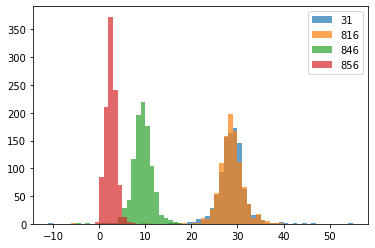

In [17]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 29
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 2


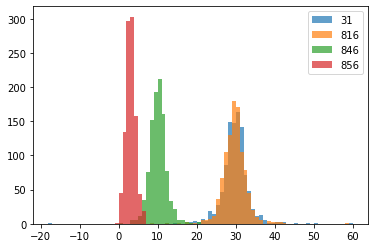

In [21]:
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


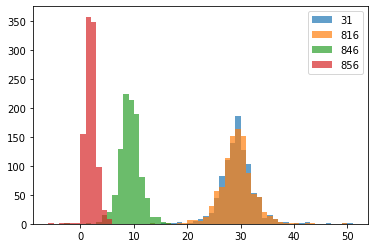

In [31]:
run_test(t[mid], s[mid], [31,816,846,856])

In [18]:
pitmodel = save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:45<00:00, 212.76it/s]


{
    "MSE": 2.170506532513962,
    "abs_error": 65189.56205482768,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.307561021850031,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 42642.29159956571,
    "Coverage[0.1]": 0.7902515395052708,
    "QuantileLoss[0.5]": 65189.56205482768,
    "Coverage[0.5]": 0.9017847823817973,
    "QuantileLoss[0.9]": 24779.233726898732,
    "Coverage[0.9]": 0.9175242667779981,
    "RMSE": 1.4732639045717375,
    "NRMSE": 0.8361152696082771,
    "ND": 0.7722942922792668,
    "wQuantileLoss[0.1]": 0.5051790098598137,
    "wQuantileLoss[0.5]": 0.7722942922792668,
    "wQuantileLoss[0.9]": 0.2935571304842137,
    "mean_wQuantileLoss": 0.5236768108744314,
    "MAE_Coverage": 0.36985352955502204
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.80it/s, avg_epoch_loss=1.46]
INFO:root:Epoch[0] Elapsed time 0.598 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.459769
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.31it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[1] Elapsed time 0.572 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.156980
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=1.04]
INFO:root:Epoch[2] Elapsed time 0.564 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.044083
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.45it/s, avg_epoch_loss=0.999]
INFO:root:Epoch[3] Elapsed time 0.621 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.998903
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.63it/s,

INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=0.886]
INFO:root:Epoch[72] Elapsed time 0.603 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.886178
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.96it/s, avg_epoch_loss=0.859]
INFO:root:Epoch[73] Elapsed time 0.567 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.858979
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 180.35it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[74] Elapsed time 0.556 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.841856
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.64it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[75] Elapsed time 0.558 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.848252
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 160.43it/s,

100%|██████████| 100/100 [00:00<00:00, 182.21it/s, avg_epoch_loss=0.846]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.846030
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.43it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[145] Elapsed time 0.565 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.829087
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.57it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[146] Elapsed time 0.558 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.856435
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.09it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[147] Elapsed time 0.563 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.890187
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.51it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 185.29it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[216] Elapsed time 0.541 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.844898
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.51it/s, avg_epoch_loss=0.875]
INFO:root:Epoch[217] Elapsed time 0.552 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.874910
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.61it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[218] Elapsed time 0.546 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.880921
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[219] Elapsed time 0.591 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.852101
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.42it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 181.26it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[288] Elapsed time 0.553 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.860981
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[289] Elapsed time 0.610 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.889782
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.86it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[290] Elapsed time 0.612 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.867584
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.31it/s, avg_epoch_loss=0.862]
INFO:root:Epoch[291] Elapsed time 0.610 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.862231
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.29it/s, avg_epoch_loss=0.822]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:00<00:00, 178.27it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[360] Elapsed time 0.562 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.846922
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[361] Elapsed time 0.558 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.848332
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.38it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[362] Elapsed time 0.559 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.838736
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.22it/s, avg_epoch_loss=0.832]
INFO:root:Epoch[363] Elapsed time 0.559 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.831727
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.27it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[364] El

100%|██████████| 100/100 [00:00<00:00, 161.93it/s, avg_epoch_loss=0.831]
INFO:root:Epoch[432] Elapsed time 0.619 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.830536
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.62it/s, avg_epoch_loss=0.825]
INFO:root:Epoch[433] Elapsed time 0.588 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.824616
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.82]
INFO:root:Epoch[434] Elapsed time 0.558 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.819503
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.88it/s, avg_epoch_loss=0.865]
INFO:root:Epoch[435] Elapsed time 0.563 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.864777
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=0.874]
INFO:root:Epoch[436] Ela

{
    "MSE": 1.039188971481898,
    "abs_error": 3980.5667862393107,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1213061459566063,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1520.6758291516526,
    "Coverage[0.1]": 0.10752032520325203,
    "QuantileLoss[0.5]": 3980.5667862393107,
    "Coverage[0.5]": 0.2733739837398374,
    "QuantileLoss[0.9]": 1921.0672762691524,
    "Coverage[0.9]": 0.6359756097560976,
    "RMSE": 1.0194061857188714,
    "NRMSE": 0.9968965786489538,
    "ND": 0.7911933951491565,
    "wQuantileLoss[0.1]": 0.30225561755351027,
    "wQuantileLoss[0.5]": 0.7911933951491565,
    "wQuantileLoss[0.9]": 0.38183902500410283,
    "mean_wQuantileLoss": 0.49176267923558986,
    "MAE_Coverage": 0.16605691056910568
}
mae =  7.400609756097561
idx: 31 t: 18 p: 23
idx: 816 t: 20 p: 10
idx: 846 t: 21 p: 16
idx: 856 t: 11 p: 8
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.06it/s]


{
    "MSE": 0.37917199785837763,
    "abs_error": 24063.23176426623,
    "abs_target_sum": 77647.07225634674,
    "abs_target_mean": 1.6208552814183643,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.39190953368788845,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5534.42109281975,
    "Coverage[0.1]": 0.36827053543471455,
    "QuantileLoss[0.5]": 24063.23176426623,
    "Coverage[0.5]": 0.7598998016908465,
    "QuantileLoss[0.9]": 13768.186262890615,
    "Coverage[0.9]": 0.8316459659743242,
    "RMSE": 0.6157694356318586,
    "NRMSE": 0.3799040190022494,
    "ND": 0.3099052039569894,
    "wQuantileLoss[0.1]": 0.07127662295557287,
    "wQuantileLoss[0.5]": 0.3099052039569894,
    "wQuantileLoss[0.9]": 0.17731751967976134,
    "mean_wQuantileLoss": 0.18616644886410785,
    "MAE_Coverage": 0.1988414570504123
}
save model pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


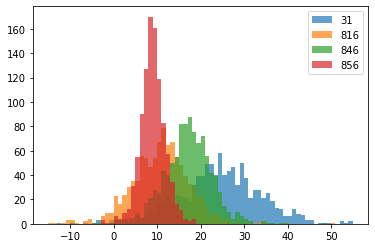

In [32]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, 'all', maxgap=65)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.64it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.469403
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.18it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[1] Elapsed time 0.638 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.137794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.69it/s, avg_epoch_loss=0.915]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.914556
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.43it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[3] Elapsed time 0.592 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.870562
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.33it/s

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.718308
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 177.85it/s, avg_epoch_loss=0.681]
INFO:root:Epoch[73] Elapsed time 0.564 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.681050
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 179.53it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[74] Elapsed time 0.558 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.732549
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 174.43it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[75] Elapsed time 0.575 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.738408
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 178.53it/s,

100%|██████████| 100/100 [00:00<00:00, 181.94it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[108] Elapsed time 0.551 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.740352
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.20it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[109] Elapsed time 0.559 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.704802
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.39it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[110] Elapsed time 0.553 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.686689
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.09it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[111] Elapsed time 0.570 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.712036
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.99it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 179.78it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[180] Elapsed time 0.558 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.727965
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.58it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[181] Elapsed time 0.544 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.730786
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.39it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[182] Elapsed time 0.547 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.735243
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.64it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[183] Elapsed time 0.610 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.718372
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.66it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 179.66it/s, avg_epoch_loss=0.702]
INFO:root:Epoch[252] Elapsed time 0.558 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.702363
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.64it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[253] Elapsed time 0.540 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.705442
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.54it/s, avg_epoch_loss=0.706]
INFO:root:Epoch[254] Elapsed time 0.549 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.705993
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[255] Elapsed time 0.614 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.717514
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.91it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 161.74it/s, avg_epoch_loss=0.68]
INFO:root:Epoch[324] Elapsed time 0.620 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.679599
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[325] Elapsed time 0.583 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.692864
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.70it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[326] Elapsed time 0.580 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.701017
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.78it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[327] Elapsed time 0.542 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.711806
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.88it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 179.21it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[396] Elapsed time 0.559 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.719797
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[397] Elapsed time 0.587 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.717534
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.13it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[398] Elapsed time 0.663 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.688146
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.50it/s, avg_epoch_loss=0.682]
INFO:root:Epoch[399] Elapsed time 0.578 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.681879
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.05it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[400] Ela

100%|██████████| 100/100 [00:00<00:00, 193.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[468] Elapsed time 0.517 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.719060
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.86it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[469] Elapsed time 0.523 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.692263
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.75it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[470] Elapsed time 0.520 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.707448
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.76it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[471] Elapsed time 0.523 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.731722
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.99it/s, avg_epoch_loss=0.679]
INFO:root:Epoch[472] El

{
    "MSE": 0.922615022583552,
    "abs_error": 3605.5270269594307,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0353874601944504,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1409.861401869293,
    "Coverage[0.1]": 0.13667856393029604,
    "QuantileLoss[0.5]": 3605.5270269594307,
    "Coverage[0.5]": 0.262019735460844,
    "QuantileLoss[0.9]": 1969.5693903192528,
    "Coverage[0.9]": 0.5903842116313248,
    "RMSE": 0.9605285121138009,
    "NRMSE": 0.9368020482656689,
    "ND": 0.7382878896063508,
    "wQuantileLoss[0.1]": 0.2886911098545604,
    "wQuantileLoss[0.5]": 0.7382878896063508,
    "wQuantileLoss[0.9]": 0.4033000495459688,
    "mean_wQuantileLoss": 0.4767596830022934,
    "MAE_Coverage": 0.19475820561270907
}
mae =  6.912240184757506
idx: 31 t: 18 p: 25
idx: 816 t: 2 p: 2
idx: 846 t: 35 p: 15
idx: 856 t: 25 p: 6
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.33it/s]


{
    "MSE": 2.072099756308953,
    "abs_error": 58884.045941364646,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5440069127184829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18850.915041648448,
    "Coverage[0.1]": 0.05383571652228369,
    "QuantileLoss[0.5]": 58884.045941364646,
    "Coverage[0.5]": 0.18883206345892914,
    "QuantileLoss[0.9]": 53647.7137817443,
    "Coverage[0.9]": 0.3778519987475211,
    "RMSE": 1.4394789877969574,
    "NRMSE": 0.8526986761726671,
    "ND": 0.7281268686526193,
    "wQuantileLoss[0.1]": 0.2330997729704228,
    "wQuantileLoss[0.5]": 0.7281268686526193,
    "wQuantileLoss[0.9]": 0.6633773413798844,
    "mean_wQuantileLoss": 0.5415346610009756,
    "MAE_Coverage": 0.2931600737570887
}
save model pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


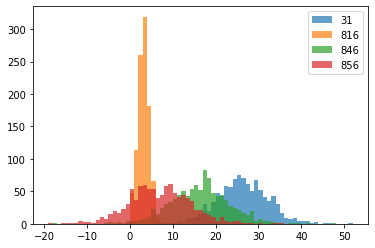

In [40]:
### run train on all data
tid = 'noshort'
trainset, testset, train_ds, test_ds, scaler = _data[tid]

pm, mid = train_model(500,dropout = 0.1,id=tid)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, tid, maxgap=65)

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [18]:
test_car12 = df_test[df_test['carno']==12]

In [19]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [20]:
len(test_set)

170

In [21]:
test

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

In [23]:
test_car12[test_car12['lap']==31]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1059,18.0,0.0,0.0,1.0,12,5,31,18.0


In [24]:
test_car12[test_car12['lap']==30]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1058,1.0,0.0,31.0,0.0,12,5,30,31.0


In [25]:
test_ds

[{'target': array([1.88149958]),
  'feat': array([-0.70945244, -1.40995345]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.76852039]),
  'feat': array([-0.70945244, -1.29736294]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.6555412]),
  'feat': array([-0.70945244, -1.18477243]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.54256201]),
  'feat': array([-0.70945244, -1.07218192]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.42958282]),
  'feat': array([-0.70945244, -0.95959142]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target':

In [26]:
len(test_ds)

170

In [28]:
test_set

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

### test

In [19]:
df12 = df_test[(df_test['eid']==5) & (df_test['carno']==12)]

In [20]:
df12[(df12['lap']>=45) & (df12['lap']<55)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1073,4.0,0.0,14.0,1.0,12,5,45,18.0,0.0
1074,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1075,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1076,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1077,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1078,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1079,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1080,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0
1081,40.0,4.0,4.0,0.0,12,5,53,44.0,4.0
1082,39.0,4.0,5.0,0.0,12,5,54,44.0,0.0


In [21]:
df12

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1028,31.0,0.0,1.0,0.0,12,5,0,31.0,0.0
1029,30.0,0.0,2.0,0.0,12,5,1,31.0,0.0
1030,29.0,0.0,3.0,0.0,12,5,2,31.0,0.0
1031,28.0,0.0,4.0,0.0,12,5,3,31.0,0.0
1032,27.0,0.0,5.0,0.0,12,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
1193,5.0,20.0,37.0,0.0,12,5,165,42.0,0.0
1194,4.0,20.0,38.0,0.0,12,5,166,42.0,0.0
1195,3.0,20.0,39.0,0.0,12,5,167,42.0,0.0
1196,2.0,20.0,40.0,0.0,12,5,168,42.0,0.0


In [22]:
df12.cur_cautionlaps.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       2., 3., 4., 0., 0., 0., 1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 1.,
       2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 7., 0.,
       1., 2., 3., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
train_set

array([[ 1.56895685, -0.64173227, -1.57348481, -0.21381922],
       [ 1.24715782, -0.64173227, -1.68074602, -0.21381922],
       [ 0.60355976, -0.64173227, -0.60813392, -0.21381922],
       ...,
       [ 0.06722804,  1.35544334,  0.35721696, -0.21381922],
       [-0.89816905,  0.35685554,  0.67900059, -0.21381922],
       [-0.68363636,  3.01975635,  1.53709027, -0.21381922]])

In [33]:
samples = np.zeros((1000))
for i in range(1000):
    samples[i] = pitmodel.predict(1,16,1)
    
samples[samples<5]

array([4., 4., 2., 2., 4., 4., 4., 3., 4., 1., 2., 4., 2., 3., 3., 2., 2.,
       3., 4., 4., 1., 3., 2., 2., 3., 4., 2., 4., 3., 4., 4., 1., 4., 3.,
       1., 4., 1., 1., 2., 1., 3., 1., 4., 2., 4., 3., 4., 2., 3., 4., 4.,
       2., 2., 1., 4., 2., 3., 3., 2., 2., 2., 4., 4., 4., 4., 1., 1., 3.,
       2., 2., 4., 4., 2., 1., 2., 1., 2., 3., 1., 3., 2., 2., 4., 2., 2.,
       1., 2., 4., 4., 2., 1., 4., 4., 2., 2., 1., 4., 4., 2., 3., 4., 4.,
       3., 3., 1., 3., 4., 4., 2., 2., 3., 4., 4., 3., 4.])

In [34]:
np.sum(samples<5)

115

In [35]:
np.min(samples)

1.0

In [36]:
np.max(samples)

39.0

In [34]:
test_all

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0


In [35]:
df_test

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0
